# Generative Model

This notebook deals with finding a good generative model.

In [59]:
# Imports
import import_ipynb

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR, ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchsummary import summary
from utils import * # type: ignore
import os
import polars as pl
import matplotlib.pyplot as plt
import umap.umap_ as umap
import warnings
from torchvision.transforms import v2
import torch.optim as optim
import math
import torchvision.utils as vutils

In [60]:
# Global variables

# Hyperparameters
BATCH_SIZE = 128
LEARNING_RATE = 0.0002
NUM_EPOCHS = 50

NOISE_DIM = 150

## Conditional Variatonal Autoencoder

First of all I want to start with a CNN-based variatonal Autoencoder. This way I can apply the knowledge that I gained while building the Classifier Model earlier.

In order to put more focus on the class label I did embed the labels before passing them into the encoder, as well concatonating the image label to the decoder input.

In [61]:
# No normalization needed for CVAE
vae_train_transforms = v2.Compose([
    # Include data augmentation, but exclude normalization
    *train_transforms.transforms[:-1],
])

# Create Train and Test Datasets
train_data = QuickDrawDataset('../dataset/train.csv', '../dataset/images', vae_train_transforms)

# Data loaders
TRAIN_LOADER = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=6)

In [62]:
# VAE loss function - combines reconstruction loss and KL divergence
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    recon = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon, KLD, (recon + beta * KLD)

In [63]:
# Define the Conditional Variational Autoencoder (CVAE) model
class CVAE(nn.Module):
    def __init__(self, latent_dim=150, num_classes=5, base_channels=64):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Label embedding
        self.label_embedding = nn.Embedding(num_classes, 8)

        # Calculate channel sizes based on base
        self.base_channels = base_channels
        ch2 = base_channels 
        ch3 = base_channels * 2

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1 + 8, ch2, kernel_size=3, padding=1), 
            nn.LeakyReLU(),
            nn.BatchNorm2d(ch2),

            nn.Conv2d(ch2, ch2, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(ch2),

            nn.Conv2d(ch2, ch2, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(ch2),

            nn.Conv2d(ch2, ch3, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(ch3),

            nn.Conv2d(ch3, ch3, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(ch3),

            nn.Conv2d(ch3, ch3, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(ch3),
        )

        # Flattened feature size 
        self.feature_map_size = 7 
        self.fc_input_dim = ch3 * self.feature_map_size * self.feature_map_size

        # Latent space
        self.fc_mu = nn.Linear(self.fc_input_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.fc_input_dim, latent_dim)

        # Decoder input projection
        self.fc_decode = nn.Linear(latent_dim + num_classes, self.fc_input_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(ch3, ch3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(ch3),
            nn.Dropout(0.2),

            nn.Conv2d(ch3, ch3, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(ch3),

            nn.ConvTranspose2d(ch3, ch2, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(ch2),
            nn.Dropout(0.2),

            nn.Conv2d(ch2, ch2, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(ch2),

            nn.Conv2d(ch2, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    # Reparameterization trick to sample from the latent space
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, y):
        batch_size = x.size(0)

        # Embed image label 
        label_embed = self.label_embedding(y)
        label_map = label_embed.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, 28, 28)
        x_cat = torch.cat([x, label_map], dim=1) 

        # Encode
        x_encoded = self.encoder(x_cat)

        # mu + log_var
        x_flat = x_encoded.view(batch_size, -1)
        mu = self.fc_mu(x_flat)
        logvar = self.fc_logvar(x_flat)
        
        z = self.reparameterize(mu, logvar)

        # Decode + add class label
        y_onehot = F.one_hot(y, self.num_classes).float().to(x.device)
        z_cat = torch.cat([z, y_onehot], dim=1)
        x_decoded = self.fc_decode(z_cat)
        x_decoded = x_decoded.view(batch_size, self.base_channels * 2, 7, 7)
        recon_x = self.decoder(x_decoded)

        return recon_x, mu, logvar, z

    def sample(self, z, y):
        y_onehot = F.one_hot(y, self.num_classes).float().to(z.device)
        z_cat = torch.cat([z, y_onehot], dim=1)
        x_decoded = self.fc_decode(z_cat)
        x_decoded = x_decoded.view(z.size(0), self.base_channels * 2, 7, 7)
        samples = self.decoder(x_decoded)

        # When adjusting the KL divergence in the end the images become quite blurry, but when using this static sharpeng trick 
        # the images tend to look better ;-)
        sharpening_kernel = torch.tensor([[[[0, -1, 0],
                             [-1, 5, -1],
                             [0, -1, 0]]]], dtype=torch.float32, device=DEVICE)
        sharpened = F.conv2d(samples, sharpening_kernel, padding=1)
        return torch.clamp(sharpened, 0, 1)

In [64]:
# Function to sample an image of each class for inspection
def sample_conditional_images(model, epoch, z, y,num_classes=5):
    with torch.no_grad():
        samples = model.sample(z, y).cpu()

        _, axes = plt.subplots(1, num_classes, figsize=(num_classes*2, 2))
        for i in range(num_classes):
            ax = axes[i]
            ax.imshow(samples[i].squeeze(), cmap='gray')
            ax.axis('off')
            ax.set_title(classes[i])

        plt.suptitle(f'Sampled Images at Epoch {epoch}', y=1.05)
        plt.subplots_adjust(top=0.8)
        plt.show()

### KL Divergence Scheduling

By scheduling to KL Divergence I want the model to fisrt focus on achieving good reconstruction loss and then worry about fitting the distribution later

In [65]:
# Sigmoid like anealing
def kl_anneal_sigmoid(epoch, total_epochs, max_beta=1.0, k=0.1, x0=None):
    if x0 is None:
        # midpoint of annealing
        x0 = total_epochs / 2  
    beta = max_beta / (1 + math.exp(-k * (epoch - x0)))
    return beta


Epoch 1 | LR 0.0002 | Loss: 81.3514 | Reconstruction: 71.0649 | Beta: 0.3793 | KL: 27.1204
Epoch 2 | LR 0.0002 | Loss: 65.3938 | Reconstruction: 52.4700 | Beta: 0.4159 | KL: 31.0771
Epoch 3 | LR 0.0002 | Loss: 61.6013 | Reconstruction: 46.2449 | Beta: 0.4556 | KL: 33.7047
Epoch 4 | LR 0.0002 | Loss: 59.9763 | Reconstruction: 43.6028 | Beta: 0.4988 | KL: 32.8289
Epoch 5 | LR 0.0002 | Loss: 59.6422 | Reconstruction: 42.8241 | Beta: 0.5455 | KL: 30.8316
Epoch 6 | LR 0.0002 | Loss: 59.9188 | Reconstruction: 42.9101 | Beta: 0.5960 | KL: 28.5375
Epoch 7 | LR 0.0002 | Loss: 60.5055 | Reconstruction: 43.4469 | Beta: 0.6505 | KL: 26.2221
Epoch 8 | LR 0.0002 | Loss: 61.2318 | Reconstruction: 44.2542 | Beta: 0.7093 | KL: 23.9372
Epoch 9 | LR 0.0002 | Loss: 62.1848 | Reconstruction: 45.3236 | Beta: 0.7723 | KL: 21.8317
Epoch 10 | LR 0.0002 | Loss: 63.0824 | Reconstruction: 46.4637 | Beta: 0.8399 | KL: 19.7864


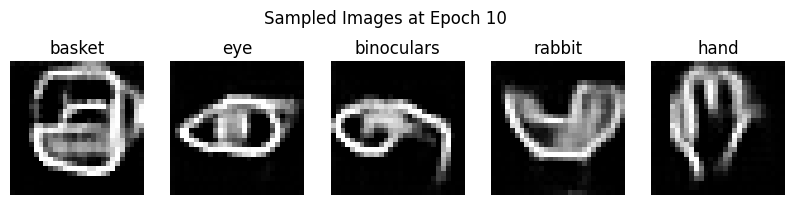

Epoch 11 | LR 0.0002 | Loss: 64.0277 | Reconstruction: 47.7102 | Beta: 0.9121 | KL: 17.8895
Epoch 12 | LR 0.0002 | Loss: 64.9317 | Reconstruction: 48.9699 | Beta: 0.9891 | KL: 16.1380
Epoch 13 | LR 0.0002 | Loss: 65.8585 | Reconstruction: 50.3161 | Beta: 1.0708 | KL: 14.5144
Epoch 14 | LR 0.0002 | Loss: 67.0620 | Reconstruction: 52.0034 | Beta: 1.1574 | KL: 13.0110
Epoch 15 | LR 0.0002 | Loss: 67.8654 | Reconstruction: 53.4525 | Beta: 1.2487 | KL: 11.5424
Epoch 16 | LR 0.0002 | Loss: 68.4439 | Reconstruction: 54.6869 | Beta: 1.3447 | KL: 10.2305
Epoch 17 | LR 0.0002 | Loss: 69.2468 | Reconstruction: 56.0478 | Beta: 1.4453 | KL: 9.1327
Epoch 18 | LR 0.0002 | Loss: 70.1516 | Reconstruction: 57.6047 | Beta: 1.5501 | KL: 8.0941
Epoch 19 | LR 0.0002 | Loss: 70.5739 | Reconstruction: 58.7187 | Beta: 1.6591 | KL: 7.1457
Epoch 20 | LR 0.0002 | Loss: 71.1566 | Reconstruction: 59.8665 | Beta: 1.7717 | KL: 6.3724


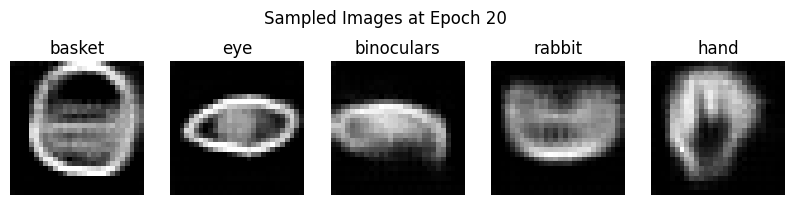

Epoch 21 | LR 0.0002 | Loss: 71.6686 | Reconstruction: 60.8928 | Beta: 1.8877 | KL: 5.7084
Epoch 22 | LR 0.0002 | Loss: 72.3193 | Reconstruction: 61.8941 | Beta: 2.0066 | KL: 5.1956
Epoch 23 | LR 0.0002 | Loss: 72.6260 | Reconstruction: 62.7998 | Beta: 2.1278 | KL: 4.6180
Epoch 24 | LR 0.0002 | Loss: 73.0394 | Reconstruction: 63.6115 | Beta: 2.2508 | KL: 4.1886
Epoch 25 | LR 0.0002 | Loss: 73.4291 | Reconstruction: 64.3966 | Beta: 2.3751 | KL: 3.8030
Epoch 26 | LR 0.0002 | Loss: 73.9598 | Reconstruction: 65.2695 | Beta: 2.5000 | KL: 3.4761
Epoch 27 | LR 0.0002 | Loss: 74.1469 | Reconstruction: 65.9666 | Beta: 2.6249 | KL: 3.1164
Epoch 28 | LR 0.0002 | Loss: 74.4452 | Reconstruction: 66.6468 | Beta: 2.7492 | KL: 2.8366
Epoch 29 | LR 0.0002 | Loss: 74.7230 | Reconstruction: 67.2837 | Beta: 2.8722 | KL: 2.5901
Epoch 30 | LR 0.0002 | Loss: 74.9582 | Reconstruction: 67.9122 | Beta: 2.9934 | KL: 2.3538


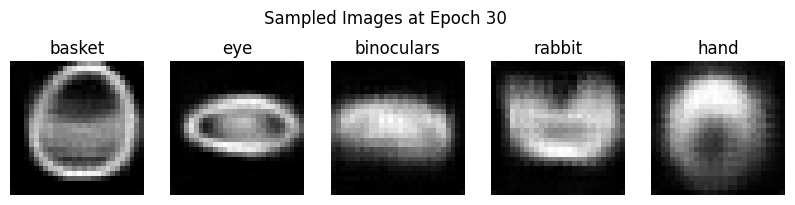

Epoch 31 | LR 0.0002 | Loss: 75.1194 | Reconstruction: 68.3915 | Beta: 3.1123 | KL: 2.1617
Epoch 32 | LR 0.0002 | Loss: 75.3414 | Reconstruction: 68.8985 | Beta: 3.2283 | KL: 1.9958
Epoch 33 | LR 0.0002 | Loss: 75.4785 | Reconstruction: 69.3184 | Beta: 3.3409 | KL: 1.8438
Epoch 34 | LR 0.0002 | Loss: 75.6248 | Reconstruction: 69.6965 | Beta: 3.4499 | KL: 1.7184
Epoch 35 | LR 0.0002 | Loss: 75.7829 | Reconstruction: 70.1035 | Beta: 3.5547 | KL: 1.5977
Epoch 36 | LR 0.0002 | Loss: 75.8446 | Reconstruction: 70.3750 | Beta: 3.6553 | KL: 1.4964
Epoch 37 | LR 0.0002 | Loss: 75.9969 | Reconstruction: 70.7066 | Beta: 3.7513 | KL: 1.4103
Epoch 38 | LR 0.0002 | Loss: 76.0932 | Reconstruction: 70.9924 | Beta: 3.8426 | KL: 1.3274
Epoch 39 | LR 0.0002 | Loss: 76.1732 | Reconstruction: 71.2335 | Beta: 3.9292 | KL: 1.2572
Epoch 40 | LR 0.0002 | Loss: 76.2523 | Reconstruction: 71.4937 | Beta: 4.0109 | KL: 1.1864


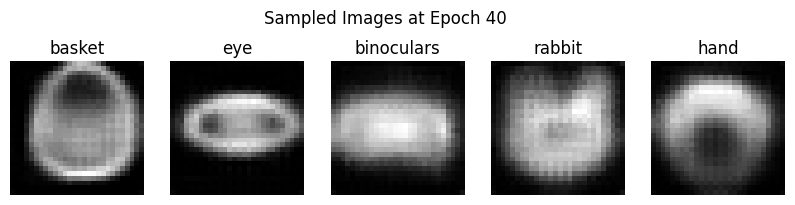

Epoch 41 | LR 0.0002 | Loss: 76.3002 | Reconstruction: 71.7040 | Beta: 4.0879 | KL: 1.1244
Epoch 42 | LR 0.0002 | Loss: 76.3625 | Reconstruction: 71.9134 | Beta: 4.1601 | KL: 1.0695
Epoch 43 | LR 0.0002 | Loss: 76.3878 | Reconstruction: 72.0370 | Beta: 4.2277 | KL: 1.0291
Epoch 44 | LR 0.0002 | Loss: 76.4978 | Reconstruction: 72.2918 | Beta: 4.2907 | KL: 0.9802
Epoch 45 | LR 0.0002 | Loss: 76.5635 | Reconstruction: 72.4899 | Beta: 4.3495 | KL: 0.9366
Epoch 46 | LR 0.0002 | Loss: 76.5475 | Reconstruction: 72.5646 | Beta: 4.4040 | KL: 0.9044
Epoch 47 | LR 0.0002 | Loss: 76.5857 | Reconstruction: 72.6544 | Beta: 4.4545 | KL: 0.8825
Epoch 48 | LR 0.0002 | Loss: 76.6703 | Reconstruction: 72.8049 | Beta: 4.5012 | KL: 0.8587
Epoch 49 | LR 0.0002 | Loss: 76.7066 | Reconstruction: 72.9383 | Beta: 4.5444 | KL: 0.8292
Epoch 50 | LR 0.0002 | Loss: 76.6904 | Reconstruction: 72.9838 | Beta: 4.5841 | KL: 0.8086


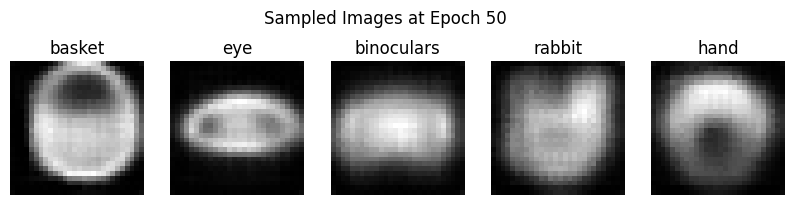

In [66]:
# Training and evaluation loop for the CVAE model
kl = []
recon = []
loss = []

# Beta parameter for KL divergence weighting
beta = 2

model = CVAE(latent_dim=100*5, base_channels=32*5).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Save best model
best_loss = float('inf')

# Fixed latent vector to check for improvement during training
z_fixed = torch.randn(model.num_classes, model.latent_dim).to(DEVICE)
y_fixed = torch.arange(model.num_classes).to(DEVICE)

# Create directories for saving weights if they don't exist
os.makedirs(os.path.dirname(f'../weights/generative/cvae/cvae.pt'), exist_ok=True)

model.train()
for epoch in range(NUM_EPOCHS):

    recon_epoch = 0.0
    kl_epoch = 0.0
    total_epoch = 0.0
    n_samples = 0

    current_beta = kl_anneal_sigmoid(epoch, NUM_EPOCHS, beta)
    
    for i, (x, labels) in enumerate(TRAIN_LOADER):
        x = x.to(DEVICE)
        labels = labels.to(DEVICE)

        x_reconst, mu, log_var, z = model(x,labels)
        recon_loss, kl_div, train_loss = vae_loss(x_reconst, x, mu, log_var, current_beta)

        # Accumulate sums
        batch_size = x.size(0)
        recon_epoch += recon_loss.item()
        kl_epoch += kl_div.item()
        total_epoch += train_loss.item()
        n_samples += batch_size

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

    # Compute mean over epoch
    mean_recon = recon_epoch / n_samples
    mean_kl = kl_epoch / n_samples
    mean_total = total_epoch / n_samples

    recon.append(mean_recon)
    kl.append(mean_kl)
    loss.append(mean_total)

    if (mean_recon + mean_kl) < best_loss:
        best_loss = (mean_recon + mean_kl)
        torch.save(model, save_path)

    print(f"Epoch {epoch + 1} | LR {optimizer.param_groups[0]['lr']:.4f} | "
              f"Loss: {mean_total:.4f} | "
              f"Reconstruction: {mean_recon:.4f} | "
              f"Beta: {current_beta:.4f} | KL: {mean_kl:.4f}")

    # Visual Inspections
    if (epoch + 1) % 10 == 0:
        model.eval()
        sample_conditional_images(model, epoch + 1, z_fixed, y_fixed, model.num_classes)
        model.train()

## Variatonal Autoencoder

The Conditional Variatonal Autoencoder didn't seem to work. So maybe 5 non-conditionals ones work better.

In [67]:
# Define the Variational Autoencoder (VAE) model
class VAE(nn.Module):
    def __init__(self, latent_dim=150, base_channels=64):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Calculate channel sizes based on base
        ch2 = base_channels 
        ch3 = base_channels * 2
        self.ch3 = ch3

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, ch2, kernel_size=3, padding=1), 
            nn.LeakyReLU(),
            nn.BatchNorm2d(ch2),

            nn.Conv2d(ch2, ch2, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(ch2),

            nn.Conv2d(ch2, ch2, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(ch2),

            nn.Conv2d(ch2, ch3, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(ch3),

            nn.Conv2d(ch3, ch3, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(ch3),

            nn.Conv2d(ch3, ch3, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(ch3),
        )

        # Flattened feature size 
        self.feature_map_size = 7 
        self.fc_input_dim = ch3 * self.feature_map_size * self.feature_map_size

        # Latent space
        self.fc_mu = nn.Linear(self.fc_input_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.fc_input_dim, latent_dim)

        # Decoder input projection
        self.fc_decode = nn.Linear(latent_dim, self.fc_input_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(ch3, ch3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(ch3),
            nn.Dropout(0.2),

            nn.Conv2d(ch3, ch3, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(ch3),

            nn.ConvTranspose2d(ch3, ch2, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(ch2),
            nn.Dropout(0.2),

            nn.Conv2d(ch2, ch2, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(ch2),

            nn.Conv2d(ch2, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    # Reparameterization trick to sample from the latent space
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        batch_size = x.size(0)

        # Encode
        x_encoded = self.encoder(x)

        # mu + log_var
        x_flat = x_encoded.view(batch_size, -1)
        mu = self.fc_mu(x_flat)
        logvar = self.fc_logvar(x_flat)
        
        z = self.reparameterize(mu, logvar)

        # Decode
        x_decoded = self.fc_decode(z)
        x_decoded = x_decoded.view(z.size(0), self.ch3, 7, 7)
        recon_x = self.decoder(x_decoded)

        return recon_x, mu, logvar, z

    def sample(self, z):
        x_decoded = self.fc_decode(z)
        x_decoded = x_decoded.view(z.size(0), self.ch3, 7, 7)
        samples = self.decoder(x_decoded)

        # When adjusting the KL divergence in the end the images become quite blurry, but when using this static sharpeng trick 
        # the images tend to look better ;-)
        sharpening_kernel = torch.tensor([[[[0, -1, 0],
                             [-1, 5, -1],
                             [0, -1, 0]]]], dtype=torch.float32, device=DEVICE)
        sharpened = F.conv2d(samples, sharpening_kernel, padding=1)
        return torch.clamp(sharpened, 0, 1)

In [68]:
# Function to sample 5 images for inspection
def sample_vae_image(model, epoch, z):
    with torch.no_grad():
        samples = model.sample(z).cpu()

        _, axes = plt.subplots(1, 5, figsize=(5*2, 2))
        for i in range(5):
            ax = axes[i]
            ax.imshow(samples[i].squeeze(), cmap='gray')
            ax.axis('off')

        plt.suptitle(f'Sampled Images at Epoch {epoch}')
        plt.show()

In [69]:
def train_vae_model(
    name,
    model,
    train_loader,
    save_path,
):
    model.to(DEVICE)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    beta = 2.5

    # Loss tracking
    kl = []
    recon = []
    total = []

    # Save best model
    best_loss = float('inf')

    # Fixed latent vector (for consistent sampling)
    z_fixed = torch.randn(5, model.latent_dim).to(DEVICE)

    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    print(f'Start training {name}')

    for epoch in range(NUM_EPOCHS):

        recon_epoch = 0.0
        kl_epoch = 0.0
        total_epoch = 0.0
        n_samples = 0

        # Midpoint at epoch 35 -> prioritises reconstruction loss a bit more
        current_beta = kl_anneal_sigmoid(epoch, NUM_EPOCHS, beta, x0=35) 
        
        for i, (x, labels) in enumerate(train_loader):
            x = x.to(DEVICE)
            labels = labels.to(DEVICE)

            x_reconst, mu, log_var, z = model(x)
            recon_loss, kl_div, train_loss = vae_loss(x_reconst, x, mu, log_var, current_beta)

            # Accumulate sums
            batch_size = x.size(0)
            recon_epoch += recon_loss.item()
            kl_epoch += kl_div.item()
            total_epoch += train_loss.item()
            n_samples += batch_size

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

        # Compute mean over epoch
        mean_recon = recon_epoch / n_samples
        mean_kl = kl_epoch / n_samples
        mean_total = total_epoch / n_samples

        recon.append(mean_recon)
        kl.append(mean_kl)
        total.append(mean_total)

        # kl_div needs to be < 55 to be able to visually good images
        if kl_div < 55 and (mean_recon + mean_kl) < best_loss:
            best_loss = (mean_recon + mean_kl)
            torch.save(model, save_path)

        print(f"Epoch {epoch + 1} | LR {optimizer.param_groups[0]['lr']:.4f} | "
              f"Loss: {mean_total:.4f} | "
              f"Reconstruction: {mean_recon:.4f} | "
              f"Beta: {current_beta:.4f} | KL: {mean_kl:.4f}")

        # Visual inspection
        if (epoch + 1) % 10 == 0:
            model.eval()
            sample_vae_image(model, epoch + 1, z_fixed)
            model.train()

    print(f'Training {name} completed!')

    return kl, recon

Start training vae-basket
Epoch 1 | LR 0.0002 | Loss: 104.9684 | Reconstruction: 99.3637 | Beta: 0.0733 | KL: 76.4829
Epoch 2 | LR 0.0002 | Loss: 63.2074 | Reconstruction: 54.9128 | Beta: 0.0807 | KL: 102.7339
Epoch 3 | LR 0.0002 | Loss: 52.2978 | Reconstruction: 42.2552 | Beta: 0.0889 | KL: 112.9294
Epoch 4 | LR 0.0002 | Loss: 47.3452 | Reconstruction: 36.3166 | Beta: 0.0979 | KL: 112.6354
Epoch 5 | LR 0.0002 | Loss: 44.9313 | Reconstruction: 33.0556 | Beta: 0.1078 | KL: 110.1972
Epoch 6 | LR 0.0002 | Loss: 43.7723 | Reconstruction: 31.1244 | Beta: 0.1186 | KL: 106.6749
Epoch 7 | LR 0.0002 | Loss: 43.1413 | Reconstruction: 29.8145 | Beta: 0.1304 | KL: 102.2121
Epoch 8 | LR 0.0002 | Loss: 43.0298 | Reconstruction: 29.0369 | Beta: 0.1433 | KL: 97.6405
Epoch 9 | LR 0.0002 | Loss: 43.0923 | Reconstruction: 28.4596 | Beta: 0.1574 | KL: 92.9449
Epoch 10 | LR 0.0002 | Loss: 43.3785 | Reconstruction: 28.1241 | Beta: 0.1728 | KL: 88.2546


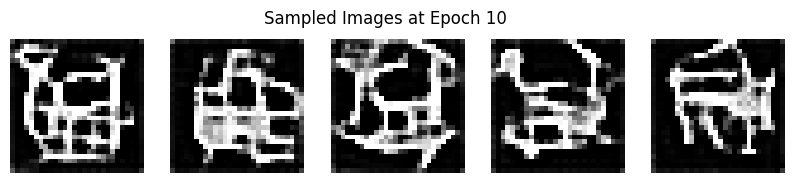

Epoch 11 | LR 0.0002 | Loss: 43.9381 | Reconstruction: 28.0233 | Beta: 0.1896 | KL: 83.9188
Epoch 12 | LR 0.0002 | Loss: 44.6306 | Reconstruction: 28.1674 | Beta: 0.2079 | KL: 79.1763
Epoch 13 | LR 0.0002 | Loss: 45.5267 | Reconstruction: 28.4591 | Beta: 0.2278 | KL: 74.9212
Epoch 14 | LR 0.0002 | Loss: 46.5199 | Reconstruction: 28.8537 | Beta: 0.2494 | KL: 70.8415
Epoch 15 | LR 0.0002 | Loss: 47.5873 | Reconstruction: 29.4253 | Beta: 0.2727 | KL: 66.5905
Epoch 16 | LR 0.0002 | Loss: 48.7744 | Reconstruction: 30.0908 | Beta: 0.2980 | KL: 62.6953
Epoch 17 | LR 0.0002 | Loss: 50.0420 | Reconstruction: 30.8760 | Beta: 0.3253 | KL: 58.9232
Epoch 18 | LR 0.0002 | Loss: 51.3162 | Reconstruction: 31.7624 | Beta: 0.3546 | KL: 55.1391
Epoch 19 | LR 0.0002 | Loss: 52.5962 | Reconstruction: 32.6197 | Beta: 0.3862 | KL: 51.7305
Epoch 20 | LR 0.0002 | Loss: 54.0604 | Reconstruction: 33.6854 | Beta: 0.4200 | KL: 48.5172


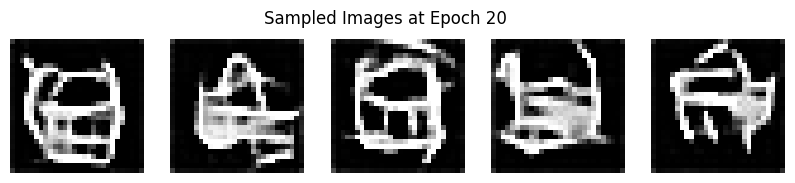

Epoch 21 | LR 0.0002 | Loss: 55.4901 | Reconstruction: 34.8285 | Beta: 0.4561 | KL: 45.3041
Epoch 22 | LR 0.0002 | Loss: 56.7519 | Reconstruction: 35.8691 | Beta: 0.4945 | KL: 42.2267
Epoch 23 | LR 0.0002 | Loss: 58.1534 | Reconstruction: 37.0831 | Beta: 0.5354 | KL: 39.3534
Epoch 24 | LR 0.0002 | Loss: 60.1506 | Reconstruction: 38.5936 | Beta: 0.5787 | KL: 37.2516
Epoch 25 | LR 0.0002 | Loss: 60.8096 | Reconstruction: 39.5480 | Beta: 0.6243 | KL: 34.0539
Epoch 26 | LR 0.0002 | Loss: 62.0930 | Reconstruction: 40.7984 | Beta: 0.6724 | KL: 31.6716
Epoch 27 | LR 0.0002 | Loss: 63.4359 | Reconstruction: 42.1093 | Beta: 0.7226 | KL: 29.5127
Epoch 28 | LR 0.0002 | Loss: 64.5656 | Reconstruction: 43.2512 | Beta: 0.7751 | KL: 27.5001
Epoch 29 | LR 0.0002 | Loss: 65.7371 | Reconstruction: 44.6037 | Beta: 0.8295 | KL: 25.4763
Epoch 30 | LR 0.0002 | Loss: 67.4612 | Reconstruction: 46.0364 | Beta: 0.8859 | KL: 24.1853


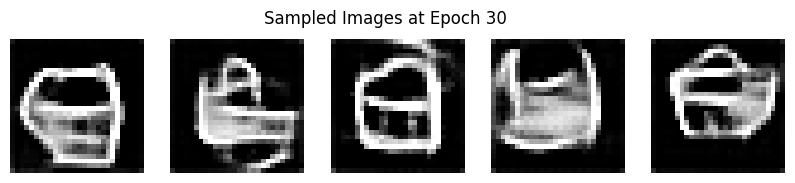

Epoch 31 | LR 0.0002 | Loss: 67.9270 | Reconstruction: 47.0430 | Beta: 0.9439 | KL: 22.1263
Epoch 32 | LR 0.0002 | Loss: 68.9984 | Reconstruction: 48.2710 | Beta: 1.0033 | KL: 20.6596
Epoch 33 | LR 0.0002 | Loss: 69.9513 | Reconstruction: 49.3435 | Beta: 1.0639 | KL: 19.3702
Epoch 34 | LR 0.0002 | Loss: 70.8906 | Reconstruction: 50.4912 | Beta: 1.1254 | KL: 18.1262
Epoch 35 | LR 0.0002 | Loss: 71.8269 | Reconstruction: 51.5452 | Beta: 1.1876 | KL: 17.0786
Epoch 36 | LR 0.0002 | Loss: 72.5634 | Reconstruction: 52.5984 | Beta: 1.2500 | KL: 15.9720
Epoch 37 | LR 0.0002 | Loss: 76.5175 | Reconstruction: 54.8559 | Beta: 1.3124 | KL: 16.5047
Epoch 38 | LR 0.0002 | Loss: 74.6884 | Reconstruction: 55.3156 | Beta: 1.3746 | KL: 14.0936
Epoch 39 | LR 0.0002 | Loss: 74.8327 | Reconstruction: 55.7509 | Beta: 1.4361 | KL: 13.2872
Epoch 40 | LR 0.0002 | Loss: 75.3891 | Reconstruction: 56.4430 | Beta: 1.4967 | KL: 12.6585


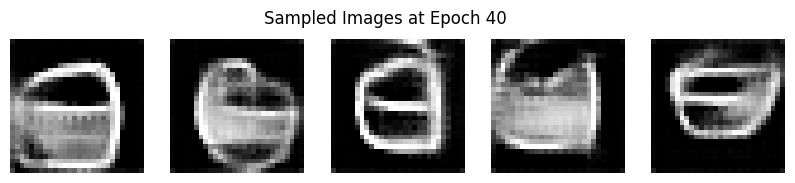

Epoch 41 | LR 0.0002 | Loss: 76.0398 | Reconstruction: 57.2932 | Beta: 1.5561 | KL: 12.0468
Epoch 42 | LR 0.0002 | Loss: 76.5559 | Reconstruction: 58.0383 | Beta: 1.6141 | KL: 11.4721
Epoch 43 | LR 0.0002 | Loss: 76.9306 | Reconstruction: 58.6700 | Beta: 1.6705 | KL: 10.9314
Epoch 44 | LR 0.0002 | Loss: 77.4256 | Reconstruction: 59.3307 | Beta: 1.7249 | KL: 10.4902
Epoch 45 | LR 0.0002 | Loss: 77.8405 | Reconstruction: 60.0124 | Beta: 1.7774 | KL: 10.0306
Epoch 46 | LR 0.0002 | Loss: 78.2989 | Reconstruction: 60.6557 | Beta: 1.8276 | KL: 9.6535
Epoch 47 | LR 0.0002 | Loss: 78.6529 | Reconstruction: 61.2303 | Beta: 1.8757 | KL: 9.2888
Epoch 48 | LR 0.0002 | Loss: 78.8535 | Reconstruction: 61.6583 | Beta: 1.9213 | KL: 8.9497
Epoch 49 | LR 0.0002 | Loss: 79.2086 | Reconstruction: 62.2194 | Beta: 1.9646 | KL: 8.6477
Epoch 50 | LR 0.0002 | Loss: 79.3720 | Reconstruction: 62.6237 | Beta: 2.0055 | KL: 8.3514


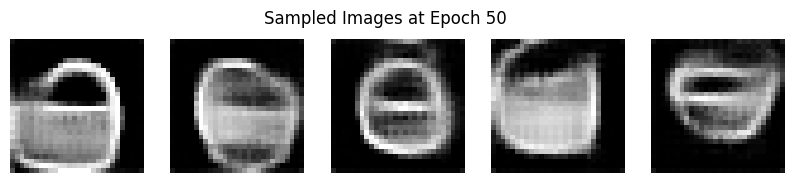

Training vae-basket completed!
Start training vae-eye
Epoch 1 | LR 0.0002 | Loss: 105.0244 | Reconstruction: 100.1018 | Beta: 0.0733 | KL: 67.1745
Epoch 2 | LR 0.0002 | Loss: 56.5974 | Reconstruction: 50.0226 | Beta: 0.0807 | KL: 81.4333
Epoch 3 | LR 0.0002 | Loss: 44.3344 | Reconstruction: 36.6119 | Beta: 0.0889 | KL: 86.8403
Epoch 4 | LR 0.0002 | Loss: 38.5794 | Reconstruction: 30.0309 | Beta: 0.0979 | KL: 87.3061
Epoch 5 | LR 0.0002 | Loss: 35.4729 | Reconstruction: 26.0225 | Beta: 0.1078 | KL: 87.6918
Epoch 6 | LR 0.0002 | Loss: 33.7317 | Reconstruction: 23.5210 | Beta: 0.1186 | KL: 86.1196
Epoch 7 | LR 0.0002 | Loss: 32.8917 | Reconstruction: 21.9815 | Beta: 0.1304 | KL: 83.6778
Epoch 8 | LR 0.0002 | Loss: 32.4904 | Reconstruction: 20.9835 | Beta: 0.1433 | KL: 80.2936
Epoch 9 | LR 0.0002 | Loss: 32.5005 | Reconstruction: 20.4555 | Beta: 0.1574 | KL: 76.5083
Epoch 10 | LR 0.0002 | Loss: 32.7682 | Reconstruction: 20.2160 | Beta: 0.1728 | KL: 72.6208


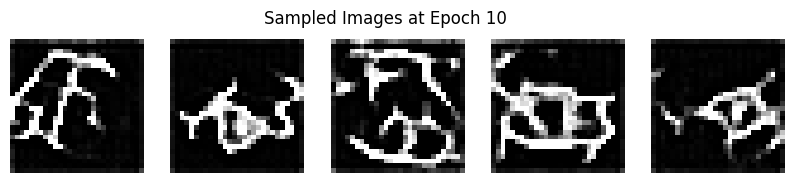

Epoch 11 | LR 0.0002 | Loss: 33.0781 | Reconstruction: 20.0996 | Beta: 0.1896 | KL: 68.4357
Epoch 12 | LR 0.0002 | Loss: 33.6725 | Reconstruction: 20.2341 | Beta: 0.2079 | KL: 64.6289
Epoch 13 | LR 0.0002 | Loss: 34.3934 | Reconstruction: 20.5066 | Beta: 0.2278 | KL: 60.9584
Epoch 14 | LR 0.0002 | Loss: 35.1365 | Reconstruction: 20.8205 | Beta: 0.2494 | KL: 57.4073
Epoch 15 | LR 0.0002 | Loss: 36.0476 | Reconstruction: 21.3090 | Beta: 0.2727 | KL: 54.0387
Epoch 16 | LR 0.0002 | Loss: 36.9667 | Reconstruction: 21.8647 | Beta: 0.2980 | KL: 50.6765
Epoch 17 | LR 0.0002 | Loss: 37.8708 | Reconstruction: 22.4316 | Beta: 0.3253 | KL: 47.4655
Epoch 18 | LR 0.0002 | Loss: 38.8784 | Reconstruction: 23.1561 | Beta: 0.3546 | KL: 44.3349
Epoch 19 | LR 0.0002 | Loss: 40.0006 | Reconstruction: 23.9366 | Beta: 0.3862 | KL: 41.5989
Epoch 20 | LR 0.0002 | Loss: 41.0021 | Reconstruction: 24.7358 | Beta: 0.4200 | KL: 38.7333


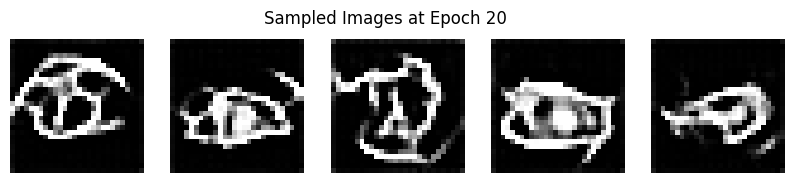

Epoch 21 | LR 0.0002 | Loss: 42.0942 | Reconstruction: 25.6406 | Beta: 0.4561 | KL: 36.0776
Epoch 22 | LR 0.0002 | Loss: 43.1614 | Reconstruction: 26.5677 | Beta: 0.4945 | KL: 33.5538
Epoch 23 | LR 0.0002 | Loss: 44.2728 | Reconstruction: 27.5544 | Beta: 0.5354 | KL: 31.2254
Epoch 24 | LR 0.0002 | Loss: 45.2881 | Reconstruction: 28.5349 | Beta: 0.5787 | KL: 28.9503
Epoch 25 | LR 0.0002 | Loss: 46.2920 | Reconstruction: 29.6121 | Beta: 0.6243 | KL: 26.7156
Epoch 26 | LR 0.0002 | Loss: 47.3563 | Reconstruction: 30.6602 | Beta: 0.6724 | KL: 24.8324
Epoch 27 | LR 0.0002 | Loss: 48.3602 | Reconstruction: 31.7678 | Beta: 0.7226 | KL: 22.9613
Epoch 28 | LR 0.0002 | Loss: 49.2674 | Reconstruction: 32.8897 | Beta: 0.7751 | KL: 21.1308
Epoch 29 | LR 0.0002 | Loss: 50.1207 | Reconstruction: 33.9241 | Beta: 0.8295 | KL: 19.5250
Epoch 30 | LR 0.0002 | Loss: 50.9471 | Reconstruction: 34.9261 | Beta: 0.8859 | KL: 18.0852


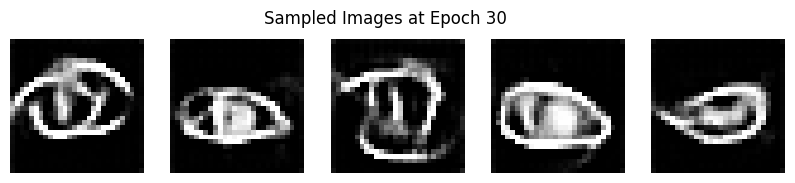

Epoch 31 | LR 0.0002 | Loss: 51.8141 | Reconstruction: 36.0505 | Beta: 0.9439 | KL: 16.7013
Epoch 32 | LR 0.0002 | Loss: 52.4753 | Reconstruction: 36.9743 | Beta: 1.0033 | KL: 15.4504
Epoch 33 | LR 0.0002 | Loss: 53.2245 | Reconstruction: 38.1355 | Beta: 1.0639 | KL: 14.1828
Epoch 34 | LR 0.0002 | Loss: 53.7880 | Reconstruction: 38.9018 | Beta: 1.1254 | KL: 13.2273
Epoch 35 | LR 0.0002 | Loss: 54.4698 | Reconstruction: 39.9007 | Beta: 1.1876 | KL: 12.2682
Epoch 36 | LR 0.0002 | Loss: 55.1393 | Reconstruction: 40.8574 | Beta: 1.2500 | KL: 11.4255
Epoch 37 | LR 0.0002 | Loss: 55.6228 | Reconstruction: 41.6893 | Beta: 1.3124 | KL: 10.6165
Epoch 38 | LR 0.0002 | Loss: 56.1277 | Reconstruction: 42.5293 | Beta: 1.3746 | KL: 9.8927
Epoch 39 | LR 0.0002 | Loss: 56.5125 | Reconstruction: 43.1817 | Beta: 1.4361 | KL: 9.2825
Epoch 40 | LR 0.0002 | Loss: 56.9615 | Reconstruction: 44.0872 | Beta: 1.4967 | KL: 8.6016


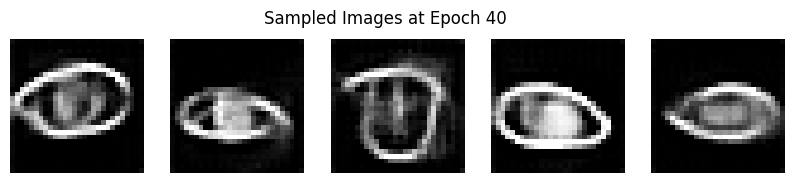

Epoch 41 | LR 0.0002 | Loss: 57.3756 | Reconstruction: 44.7280 | Beta: 1.5561 | KL: 8.1275
Epoch 42 | LR 0.0002 | Loss: 57.6985 | Reconstruction: 45.3902 | Beta: 1.6141 | KL: 7.6253
Epoch 43 | LR 0.0002 | Loss: 57.9393 | Reconstruction: 45.9135 | Beta: 1.6705 | KL: 7.1991
Epoch 44 | LR 0.0002 | Loss: 58.2531 | Reconstruction: 46.5660 | Beta: 1.7249 | KL: 6.7754
Epoch 45 | LR 0.0002 | Loss: 58.5731 | Reconstruction: 47.0846 | Beta: 1.7774 | KL: 6.4638
Epoch 46 | LR 0.0002 | Loss: 58.7531 | Reconstruction: 47.5072 | Beta: 1.8276 | KL: 6.1532
Epoch 47 | LR 0.0002 | Loss: 58.8272 | Reconstruction: 47.7664 | Beta: 1.8757 | KL: 5.8970
Epoch 48 | LR 0.0002 | Loss: 59.1910 | Reconstruction: 48.2878 | Beta: 1.9213 | KL: 5.6749
Epoch 49 | LR 0.0002 | Loss: 59.3400 | Reconstruction: 48.6184 | Beta: 1.9646 | KL: 5.4574
Epoch 50 | LR 0.0002 | Loss: 59.4322 | Reconstruction: 48.9476 | Beta: 2.0055 | KL: 5.2280


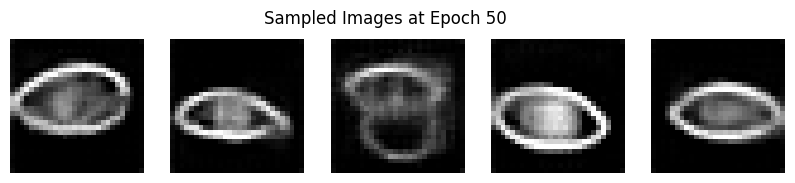

Training vae-eye completed!
Start training vae-binoculars
Epoch 1 | LR 0.0002 | Loss: 117.8204 | Reconstruction: 112.9980 | Beta: 0.0733 | KL: 65.8075
Epoch 2 | LR 0.0002 | Loss: 68.7020 | Reconstruction: 60.7736 | Beta: 0.0807 | KL: 98.1989
Epoch 3 | LR 0.0002 | Loss: 51.7499 | Reconstruction: 41.2677 | Beta: 0.0889 | KL: 117.8729
Epoch 4 | LR 0.0002 | Loss: 44.4511 | Reconstruction: 32.6194 | Beta: 0.0979 | KL: 120.8372
Epoch 5 | LR 0.0002 | Loss: 40.9626 | Reconstruction: 28.2217 | Beta: 0.1078 | KL: 118.2244
Epoch 6 | LR 0.0002 | Loss: 39.3130 | Reconstruction: 25.7610 | Beta: 0.1186 | KL: 114.3010
Epoch 7 | LR 0.0002 | Loss: 38.9187 | Reconstruction: 24.4791 | Beta: 0.1304 | KL: 110.7470
Epoch 8 | LR 0.0002 | Loss: 38.7337 | Reconstruction: 23.5777 | Beta: 0.1433 | KL: 105.7569
Epoch 9 | LR 0.0002 | Loss: 38.9700 | Reconstruction: 23.0913 | Beta: 0.1574 | KL: 100.8596
Epoch 10 | LR 0.0002 | Loss: 39.6598 | Reconstruction: 23.0245 | Beta: 0.1728 | KL: 96.2438


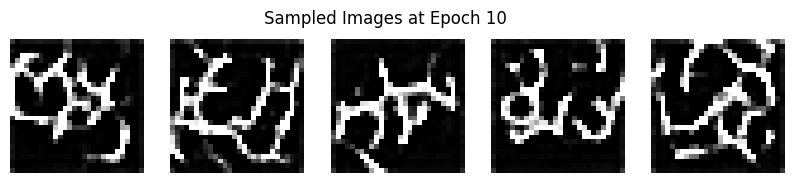

Epoch 11 | LR 0.0002 | Loss: 40.6725 | Reconstruction: 23.2742 | Beta: 0.1896 | KL: 91.7413
Epoch 12 | LR 0.0002 | Loss: 41.6787 | Reconstruction: 23.5298 | Beta: 0.2079 | KL: 87.2831
Epoch 13 | LR 0.0002 | Loss: 42.7561 | Reconstruction: 23.9323 | Beta: 0.2278 | KL: 82.6303
Epoch 14 | LR 0.0002 | Loss: 44.0972 | Reconstruction: 24.5272 | Beta: 0.2494 | KL: 78.4755
Epoch 15 | LR 0.0002 | Loss: 45.6011 | Reconstruction: 25.3002 | Beta: 0.2727 | KL: 74.4328
Epoch 16 | LR 0.0002 | Loss: 47.0166 | Reconstruction: 26.0728 | Beta: 0.2980 | KL: 70.2797
Epoch 17 | LR 0.0002 | Loss: 48.6033 | Reconstruction: 27.0617 | Beta: 0.3253 | KL: 66.2267
Epoch 18 | LR 0.0002 | Loss: 50.2060 | Reconstruction: 28.0265 | Beta: 0.3546 | KL: 62.5431
Epoch 19 | LR 0.0002 | Loss: 52.0258 | Reconstruction: 29.3328 | Beta: 0.3862 | KL: 58.7653
Epoch 20 | LR 0.0002 | Loss: 53.5675 | Reconstruction: 30.5210 | Beta: 0.4200 | KL: 54.8784


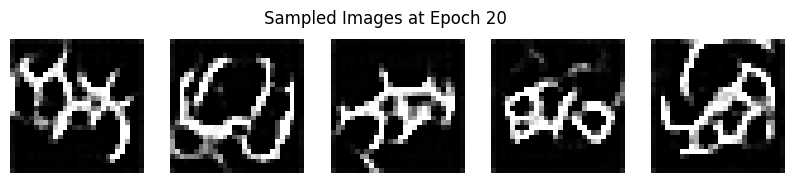

Epoch 21 | LR 0.0002 | Loss: 54.8193 | Reconstruction: 31.5557 | Beta: 0.4561 | KL: 51.0096
Epoch 22 | LR 0.0002 | Loss: 60.1365 | Reconstruction: 34.5717 | Beta: 0.4945 | KL: 51.6941
Epoch 23 | LR 0.0002 | Loss: 59.3430 | Reconstruction: 35.4299 | Beta: 0.5354 | KL: 44.6630
Epoch 24 | LR 0.0002 | Loss: 59.9001 | Reconstruction: 36.1819 | Beta: 0.5787 | KL: 40.9862
Epoch 25 | LR 0.0002 | Loss: 61.3962 | Reconstruction: 37.5943 | Beta: 0.6243 | KL: 38.1228
Epoch 26 | LR 0.0002 | Loss: 62.8059 | Reconstruction: 39.2137 | Beta: 0.6724 | KL: 35.0890
Epoch 27 | LR 0.0002 | Loss: 64.1247 | Reconstruction: 40.8045 | Beta: 0.7226 | KL: 32.2715
Epoch 28 | LR 0.0002 | Loss: 65.4768 | Reconstruction: 42.5306 | Beta: 0.7751 | KL: 29.6055
Epoch 29 | LR 0.0002 | Loss: 66.6425 | Reconstruction: 44.2120 | Beta: 0.8295 | KL: 27.0400
Epoch 30 | LR 0.0002 | Loss: 67.8578 | Reconstruction: 45.9978 | Beta: 0.8859 | KL: 24.6765


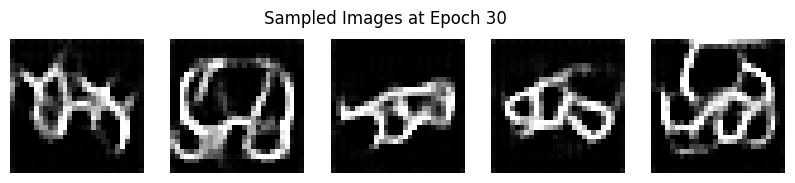

Epoch 31 | LR 0.0002 | Loss: 69.0533 | Reconstruction: 47.9507 | Beta: 0.9439 | KL: 22.3579
Epoch 32 | LR 0.0002 | Loss: 69.8900 | Reconstruction: 49.7121 | Beta: 1.0033 | KL: 20.1119
Epoch 33 | LR 0.0002 | Loss: 70.8316 | Reconstruction: 51.5723 | Beta: 1.0639 | KL: 18.1026
Epoch 34 | LR 0.0002 | Loss: 71.7009 | Reconstruction: 53.2981 | Beta: 1.1254 | KL: 16.3520
Epoch 35 | LR 0.0002 | Loss: 72.3162 | Reconstruction: 55.0337 | Beta: 1.1876 | KL: 14.5530
Epoch 36 | LR 0.0002 | Loss: 72.9661 | Reconstruction: 56.7709 | Beta: 1.2500 | KL: 12.9561
Epoch 37 | LR 0.0002 | Loss: 73.5143 | Reconstruction: 58.4700 | Beta: 1.3124 | KL: 11.4628
Epoch 38 | LR 0.0002 | Loss: 73.9370 | Reconstruction: 59.7315 | Beta: 1.3746 | KL: 10.3344
Epoch 39 | LR 0.0002 | Loss: 74.3451 | Reconstruction: 61.1178 | Beta: 1.4361 | KL: 9.2105
Epoch 40 | LR 0.0002 | Loss: 74.7164 | Reconstruction: 62.3444 | Beta: 1.4967 | KL: 8.2661


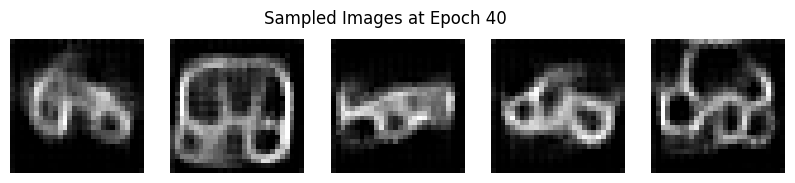

Epoch 41 | LR 0.0002 | Loss: 75.0286 | Reconstruction: 63.6859 | Beta: 1.5561 | KL: 7.2890
Epoch 42 | LR 0.0002 | Loss: 75.1513 | Reconstruction: 64.5144 | Beta: 1.6141 | KL: 6.5898
Epoch 43 | LR 0.0002 | Loss: 75.4286 | Reconstruction: 65.4470 | Beta: 1.6705 | KL: 5.9753
Epoch 44 | LR 0.0002 | Loss: 75.5402 | Reconstruction: 66.1516 | Beta: 1.7249 | KL: 5.4429
Epoch 45 | LR 0.0002 | Loss: 75.6948 | Reconstruction: 66.8321 | Beta: 1.7774 | KL: 4.9864
Epoch 46 | LR 0.0002 | Loss: 75.8726 | Reconstruction: 67.4101 | Beta: 1.8276 | KL: 4.6303
Epoch 47 | LR 0.0002 | Loss: 75.9563 | Reconstruction: 68.0217 | Beta: 1.8757 | KL: 4.2303
Epoch 48 | LR 0.0002 | Loss: 76.0800 | Reconstruction: 68.3280 | Beta: 1.9213 | KL: 4.0348
Epoch 49 | LR 0.0002 | Loss: 76.1224 | Reconstruction: 68.6714 | Beta: 1.9646 | KL: 3.7927
Epoch 50 | LR 0.0002 | Loss: 76.2812 | Reconstruction: 69.0540 | Beta: 2.0055 | KL: 3.6038


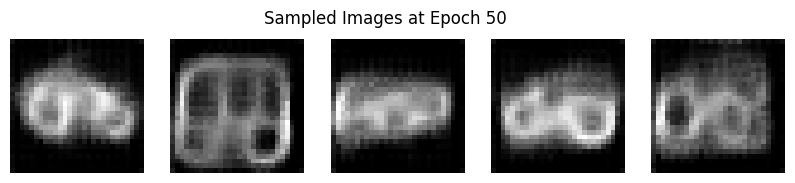

Training vae-binoculars completed!
Start training vae-rabbit
Epoch 1 | LR 0.0002 | Loss: 112.8124 | Reconstruction: 107.7067 | Beta: 0.0733 | KL: 69.6731
Epoch 2 | LR 0.0002 | Loss: 65.3567 | Reconstruction: 57.3751 | Beta: 0.0807 | KL: 98.8578
Epoch 3 | LR 0.0002 | Loss: 52.0554 | Reconstruction: 42.0027 | Beta: 0.0889 | KL: 113.0426
Epoch 4 | LR 0.0002 | Loss: 45.7258 | Reconstruction: 34.3634 | Beta: 0.0979 | KL: 116.0443
Epoch 5 | LR 0.0002 | Loss: 42.5378 | Reconstruction: 30.2006 | Beta: 0.1078 | KL: 114.4790
Epoch 6 | LR 0.0002 | Loss: 40.9286 | Reconstruction: 27.7857 | Beta: 0.1186 | KL: 110.8498
Epoch 7 | LR 0.0002 | Loss: 40.2658 | Reconstruction: 26.3072 | Beta: 0.1304 | KL: 107.0573
Epoch 8 | LR 0.0002 | Loss: 40.0780 | Reconstruction: 25.4000 | Beta: 0.1433 | KL: 102.4206
Epoch 9 | LR 0.0002 | Loss: 40.3007 | Reconstruction: 24.9591 | Beta: 0.1574 | KL: 97.4484
Epoch 10 | LR 0.0002 | Loss: 40.7771 | Reconstruction: 24.7527 | Beta: 0.1728 | KL: 92.7091


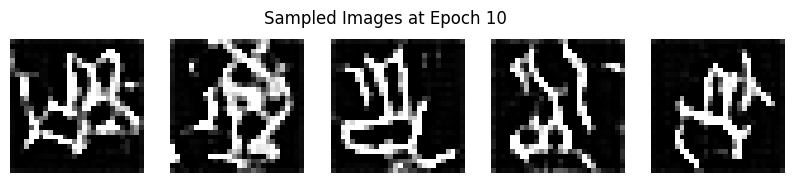

Epoch 11 | LR 0.0002 | Loss: 41.6006 | Reconstruction: 24.9047 | Beta: 0.1896 | KL: 88.0374
Epoch 12 | LR 0.0002 | Loss: 42.5275 | Reconstruction: 25.1803 | Beta: 0.2079 | KL: 83.4270
Epoch 13 | LR 0.0002 | Loss: 43.7207 | Reconstruction: 25.6885 | Beta: 0.2278 | KL: 79.1554
Epoch 14 | LR 0.0002 | Loss: 44.8708 | Reconstruction: 26.2245 | Beta: 0.2494 | KL: 74.7717
Epoch 15 | LR 0.0002 | Loss: 46.1535 | Reconstruction: 26.8864 | Beta: 0.2727 | KL: 70.6424
Epoch 16 | LR 0.0002 | Loss: 47.5278 | Reconstruction: 27.6649 | Beta: 0.2980 | KL: 66.6522
Epoch 17 | LR 0.0002 | Loss: 48.9184 | Reconstruction: 28.5970 | Beta: 0.3253 | KL: 62.4751
Epoch 18 | LR 0.0002 | Loss: 50.4499 | Reconstruction: 29.6389 | Beta: 0.3546 | KL: 58.6840
Epoch 19 | LR 0.0002 | Loss: 51.9047 | Reconstruction: 30.6655 | Beta: 0.3862 | KL: 55.0007
Epoch 20 | LR 0.0002 | Loss: 53.4756 | Reconstruction: 31.8989 | Beta: 0.4200 | KL: 51.3788


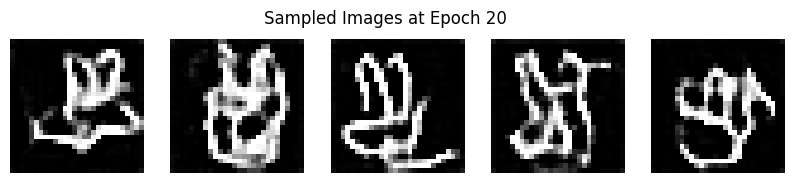

Epoch 21 | LR 0.0002 | Loss: 55.0537 | Reconstruction: 33.1526 | Beta: 0.4561 | KL: 48.0218
Epoch 22 | LR 0.0002 | Loss: 56.4689 | Reconstruction: 34.4697 | Beta: 0.4945 | KL: 44.4842
Epoch 23 | LR 0.0002 | Loss: 57.8707 | Reconstruction: 35.8236 | Beta: 0.5354 | KL: 41.1778
Epoch 24 | LR 0.0002 | Loss: 59.4249 | Reconstruction: 37.3068 | Beta: 0.5787 | KL: 38.2210
Epoch 25 | LR 0.0002 | Loss: 60.8667 | Reconstruction: 38.8552 | Beta: 0.6243 | KL: 35.2551
Epoch 26 | LR 0.0002 | Loss: 62.1751 | Reconstruction: 40.3024 | Beta: 0.6724 | KL: 32.5317
Epoch 27 | LR 0.0002 | Loss: 63.4043 | Reconstruction: 41.9328 | Beta: 0.7226 | KL: 29.7131
Epoch 28 | LR 0.0002 | Loss: 64.6970 | Reconstruction: 43.5872 | Beta: 0.7751 | KL: 27.2362
Epoch 29 | LR 0.0002 | Loss: 65.8902 | Reconstruction: 45.2525 | Beta: 0.8295 | KL: 24.8788
Epoch 30 | LR 0.0002 | Loss: 66.9687 | Reconstruction: 46.8894 | Beta: 0.8859 | KL: 22.6665


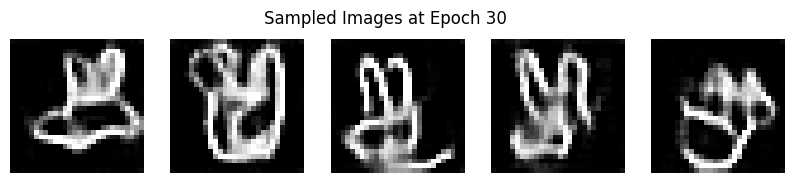

Epoch 31 | LR 0.0002 | Loss: 68.0019 | Reconstruction: 48.5204 | Beta: 0.9439 | KL: 20.6405
Epoch 32 | LR 0.0002 | Loss: 68.8822 | Reconstruction: 50.1058 | Beta: 1.0033 | KL: 18.7149
Epoch 33 | LR 0.0002 | Loss: 69.7709 | Reconstruction: 51.7388 | Beta: 1.0639 | KL: 16.9492
Epoch 34 | LR 0.0002 | Loss: 70.5408 | Reconstruction: 53.1813 | Beta: 1.1254 | KL: 15.4249
Epoch 35 | LR 0.0002 | Loss: 71.1979 | Reconstruction: 54.6686 | Beta: 1.1876 | KL: 13.9188
Epoch 36 | LR 0.0002 | Loss: 71.8675 | Reconstruction: 56.0046 | Beta: 1.2500 | KL: 12.6904
Epoch 37 | LR 0.0002 | Loss: 72.4655 | Reconstruction: 57.3484 | Beta: 1.3124 | KL: 11.5183
Epoch 38 | LR 0.0002 | Loss: 72.9585 | Reconstruction: 58.5998 | Beta: 1.3746 | KL: 10.4458
Epoch 39 | LR 0.0002 | Loss: 73.4313 | Reconstruction: 59.6250 | Beta: 1.4361 | KL: 9.6137
Epoch 40 | LR 0.0002 | Loss: 73.7729 | Reconstruction: 60.5680 | Beta: 1.4967 | KL: 8.8226


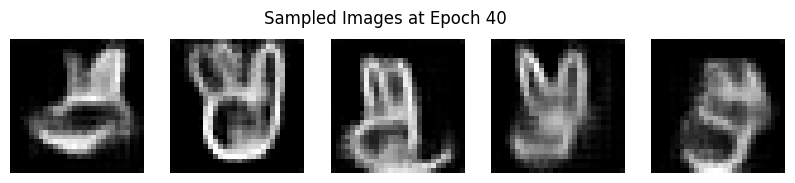

Epoch 41 | LR 0.0002 | Loss: 74.2191 | Reconstruction: 61.4711 | Beta: 1.5561 | KL: 8.1920
Epoch 42 | LR 0.0002 | Loss: 74.5137 | Reconstruction: 62.2629 | Beta: 1.6141 | KL: 7.5896
Epoch 43 | LR 0.0002 | Loss: 74.8105 | Reconstruction: 62.9958 | Beta: 1.6705 | KL: 7.0727
Epoch 44 | LR 0.0002 | Loss: 75.0655 | Reconstruction: 63.6882 | Beta: 1.7249 | KL: 6.5958
Epoch 45 | LR 0.0002 | Loss: 75.3966 | Reconstruction: 64.3592 | Beta: 1.7774 | KL: 6.2100
Epoch 46 | LR 0.0002 | Loss: 75.5951 | Reconstruction: 64.8024 | Beta: 1.8276 | KL: 5.9052
Epoch 47 | LR 0.0002 | Loss: 75.7252 | Reconstruction: 65.3150 | Beta: 1.8757 | KL: 5.5502
Epoch 48 | LR 0.0002 | Loss: 75.9910 | Reconstruction: 65.7285 | Beta: 1.9213 | KL: 5.3414
Epoch 49 | LR 0.0002 | Loss: 76.1092 | Reconstruction: 66.0767 | Beta: 1.9646 | KL: 5.1067
Epoch 50 | LR 0.0002 | Loss: 76.2759 | Reconstruction: 66.4343 | Beta: 2.0055 | KL: 4.9074


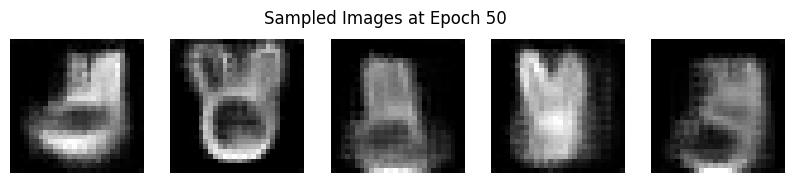

Training vae-rabbit completed!
Start training vae-hand
Epoch 1 | LR 0.0002 | Loss: 110.2050 | Reconstruction: 105.6451 | Beta: 0.0733 | KL: 62.2250
Epoch 2 | LR 0.0002 | Loss: 66.5195 | Reconstruction: 60.4828 | Beta: 0.0807 | KL: 74.7691
Epoch 3 | LR 0.0002 | Loss: 54.5777 | Reconstruction: 46.6331 | Beta: 0.0889 | KL: 89.3372
Epoch 4 | LR 0.0002 | Loss: 47.4208 | Reconstruction: 37.9183 | Beta: 0.0979 | KL: 97.0490
Epoch 5 | LR 0.0002 | Loss: 43.0349 | Reconstruction: 32.3085 | Beta: 0.1078 | KL: 99.5323
Epoch 6 | LR 0.0002 | Loss: 40.5512 | Reconstruction: 28.8513 | Beta: 0.1186 | KL: 98.6796
Epoch 7 | LR 0.0002 | Loss: 39.1363 | Reconstruction: 26.5925 | Beta: 0.1304 | KL: 96.2064
Epoch 8 | LR 0.0002 | Loss: 38.5345 | Reconstruction: 25.2610 | Beta: 0.1433 | KL: 92.6207
Epoch 9 | LR 0.0002 | Loss: 38.4939 | Reconstruction: 24.4934 | Beta: 0.1574 | KL: 88.9298
Epoch 10 | LR 0.0002 | Loss: 38.9370 | Reconstruction: 24.1894 | Beta: 0.1728 | KL: 85.3221


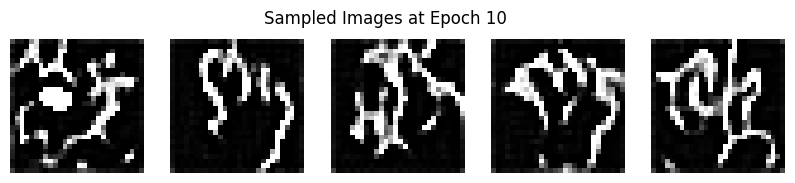

Epoch 11 | LR 0.0002 | Loss: 39.5496 | Reconstruction: 24.1329 | Beta: 0.1896 | KL: 81.2920
Epoch 12 | LR 0.0002 | Loss: 40.0769 | Reconstruction: 24.1084 | Beta: 0.2079 | KL: 76.7972
Epoch 13 | LR 0.0002 | Loss: 40.9533 | Reconstruction: 24.3819 | Beta: 0.2278 | KL: 72.7431
Epoch 14 | LR 0.0002 | Loss: 42.1020 | Reconstruction: 24.8697 | Beta: 0.2494 | KL: 69.1018
Epoch 15 | LR 0.0002 | Loss: 43.0354 | Reconstruction: 25.3237 | Beta: 0.2727 | KL: 64.9393
Epoch 16 | LR 0.0002 | Loss: 44.3687 | Reconstruction: 26.0211 | Beta: 0.2980 | KL: 61.5675
Epoch 17 | LR 0.0002 | Loss: 45.5137 | Reconstruction: 26.7805 | Beta: 0.3253 | KL: 57.5926
Epoch 18 | LR 0.0002 | Loss: 46.8042 | Reconstruction: 27.6149 | Beta: 0.3546 | KL: 54.1112
Epoch 19 | LR 0.0002 | Loss: 49.8835 | Reconstruction: 29.1667 | Beta: 0.3862 | KL: 53.6477
Epoch 20 | LR 0.0002 | Loss: 49.7529 | Reconstruction: 30.0033 | Beta: 0.4200 | KL: 47.0280


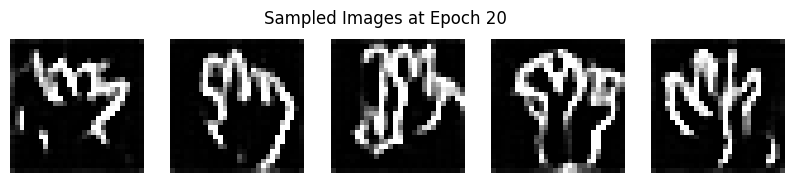

Epoch 21 | LR 0.0002 | Loss: 50.9116 | Reconstruction: 30.9519 | Beta: 0.4561 | KL: 43.7651
Epoch 22 | LR 0.0002 | Loss: 52.2716 | Reconstruction: 32.1754 | Beta: 0.4945 | KL: 40.6361
Epoch 23 | LR 0.0002 | Loss: 53.5458 | Reconstruction: 33.4085 | Beta: 0.5354 | KL: 37.6109
Epoch 24 | LR 0.0002 | Loss: 54.8298 | Reconstruction: 34.7648 | Beta: 0.5787 | KL: 34.6734
Epoch 25 | LR 0.0002 | Loss: 56.0770 | Reconstruction: 36.2020 | Beta: 0.6243 | KL: 31.8331
Epoch 26 | LR 0.0002 | Loss: 57.4620 | Reconstruction: 37.8351 | Beta: 0.6724 | KL: 29.1914
Epoch 27 | LR 0.0002 | Loss: 60.2739 | Reconstruction: 39.9619 | Beta: 0.7226 | KL: 28.1085
Epoch 28 | LR 0.0002 | Loss: 59.6649 | Reconstruction: 41.1412 | Beta: 0.7751 | KL: 23.8996
Epoch 29 | LR 0.0002 | Loss: 60.6003 | Reconstruction: 42.7403 | Beta: 0.8295 | KL: 21.5303
Epoch 30 | LR 0.0002 | Loss: 61.4523 | Reconstruction: 44.2115 | Beta: 0.8859 | KL: 19.4622


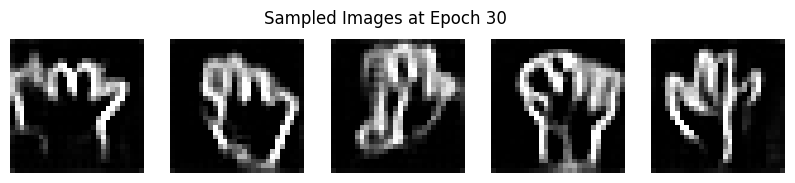

Epoch 31 | LR 0.0002 | Loss: 62.2674 | Reconstruction: 45.7911 | Beta: 0.9439 | KL: 17.4565
Epoch 32 | LR 0.0002 | Loss: 64.4546 | Reconstruction: 47.6471 | Beta: 1.0033 | KL: 16.7526
Epoch 33 | LR 0.0002 | Loss: 66.7877 | Reconstruction: 50.9173 | Beta: 1.0639 | KL: 14.9173
Epoch 34 | LR 0.0002 | Loss: 64.6391 | Reconstruction: 51.0994 | Beta: 1.1254 | KL: 12.0308
Epoch 35 | LR 0.0002 | Loss: 64.9576 | Reconstruction: 52.1502 | Beta: 1.1876 | KL: 10.7848
Epoch 36 | LR 0.0002 | Loss: 65.4037 | Reconstruction: 53.2832 | Beta: 1.2500 | KL: 9.6964
Epoch 37 | LR 0.0002 | Loss: 65.7702 | Reconstruction: 54.4566 | Beta: 1.3124 | KL: 8.6202
Epoch 38 | LR 0.0002 | Loss: 66.0348 | Reconstruction: 55.4342 | Beta: 1.3746 | KL: 7.7119
Epoch 39 | LR 0.0002 | Loss: 67.1882 | Reconstruction: 56.8426 | Beta: 1.4361 | KL: 7.2039
Epoch 40 | LR 0.0002 | Loss: 66.6388 | Reconstruction: 57.4025 | Beta: 1.4967 | KL: 6.1710


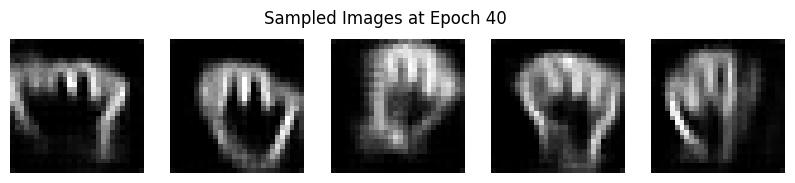

Epoch 41 | LR 0.0002 | Loss: 66.9101 | Reconstruction: 58.0075 | Beta: 1.5561 | KL: 5.7209
Epoch 42 | LR 0.0002 | Loss: 67.0860 | Reconstruction: 58.7430 | Beta: 1.6141 | KL: 5.1687
Epoch 43 | LR 0.0002 | Loss: 67.2331 | Reconstruction: 59.2701 | Beta: 1.6705 | KL: 4.7669
Epoch 44 | LR 0.0002 | Loss: 67.3648 | Reconstruction: 59.7990 | Beta: 1.7249 | KL: 4.3861
Epoch 45 | LR 0.0002 | Loss: 69.0768 | Reconstruction: 60.3934 | Beta: 1.7774 | KL: 4.8856
Epoch 46 | LR 0.0002 | Loss: 68.1632 | Reconstruction: 61.0674 | Beta: 1.8276 | KL: 3.8825
Epoch 47 | LR 0.0002 | Loss: 67.9173 | Reconstruction: 61.1655 | Beta: 1.8757 | KL: 3.5997
Epoch 48 | LR 0.0002 | Loss: 68.5104 | Reconstruction: 61.3890 | Beta: 1.9213 | KL: 3.7065
Epoch 49 | LR 0.0002 | Loss: 68.7948 | Reconstruction: 61.8701 | Beta: 1.9646 | KL: 3.5248
Epoch 50 | LR 0.0002 | Loss: 68.1841 | Reconstruction: 61.9478 | Beta: 2.0055 | KL: 3.1097


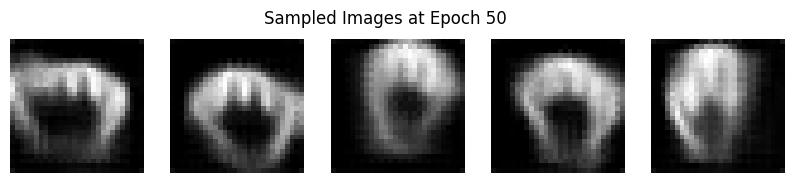

Training vae-hand completed!


In [70]:
vae_models = [VAE(latent_dim=125, base_channels=32) for i in range(len(classes))]

for idx, model in enumerate(vae_models):
    # Create Train Dataloader
    current_train_data = QuickDrawDataset('../dataset/train.csv', '../dataset/images', vae_train_transforms, class_label=idx)
    current_train_loader = DataLoader(current_train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=6)

    name = f'vae-{classes[idx]}'
    train_vae_model(name,model, current_train_loader, f'../weights/generative/vae/{name}.pt')

## Conditional GAN

Based on this [paper](https://arxiv.org/pdf/1511.06434) I want to build a conditional version that is able to create images

In [71]:
# The GAN expected images with values from [-1, 1] so we need different normalizations
cgan_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.5], [0.5])
])

# Add data augmentations during training
cgan_train_transforms = v2.Compose([
    *train_transforms.transforms[:-3],
    *cgan_transforms.transforms
])

# cGAN Dataset and Dataloader
cgan_train_data = QuickDrawDataset('../dataset/train.csv', '../dataset/images', cgan_transforms, class_label=0)
cgan_train_loader = DataLoader(cgan_train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=6, pin_memory=True)

    
# The Generator
class ConditionalGenerator(nn.Module):
    def __init__(self, noise_dim=100, num_classes=5, base_channels=64):
        super(ConditionalGenerator, self).__init__()

        # Calculate channels
        self.ch1 = base_channels
        self.ch2 = base_channels * 2
        self.ch3 = base_channels * 4

        # Conditional Part: Embedd label and add concat with input
        self.label_embed = nn.Embedding(num_classes, noise_dim)
        
        self.fc = nn.Sequential(
            nn.Linear(noise_dim * 2, self.ch3 * 7 * 7),
            nn.LayerNorm(self.ch3 * 7 * 7),
            nn.ReLU(True)
        )
        
        self.net = nn.Sequential(
            # Upsample 7x7 -> 14x14
            nn.ConvTranspose2d(self.ch3, self.ch2, kernel_size=4, stride=2, padding=1, bias=False),  
            nn.BatchNorm2d(self.ch2),
            nn.ReLU(True),

            # Upsample 14x14 -> 28x28
            nn.ConvTranspose2d(self.ch2, self.ch1, kernel_size=4, stride=2, padding=1, bias=False),  
            nn.BatchNorm2d(self.ch1),
            nn.ReLU(True),

            # Final conv to get single channel image 28x28, no stride/padding change
            nn.Conv2d(self.ch1 , 1, kernel_size=3, stride=1, padding=1),  
            nn.Tanh()  # normalize to [-1,1]
        )

    def forward(self, noise, labels):
        label_embedding = self.label_embed(labels)
        x = torch.cat([noise, label_embedding], dim=1)
        x = self.fc(x).view(-1, self.ch3, 7, 7)
        return self.net(x)

# The Discriminator
class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes=5, embedding_dim=100, base_channels=64):
        super(ConditionalDiscriminator, self).__init__()

        # Calculate channels
        self.ch1 = base_channels
        self.ch2 = base_channels * 2

        # Conditional Part: Embedd label and add concat with input
        self.label_embed = nn.Embedding(num_classes, embedding_dim)
        self.label_fc = nn.Linear(embedding_dim, 28 * 28)

        self.net = nn.Sequential(
            nn.Conv2d(2, self.ch1, kernel_size=4, stride=2, padding=1, bias=False),  # 28x28 -> 14x14
            nn.BatchNorm2d(self.ch1),
            nn.LeakyReLU(0.2, inplace=True),
        
            nn.Conv2d(self.ch1, self.ch2, kernel_size=4, stride=2, padding=1, bias=False),  # 14x14 -> 7x7
            nn.BatchNorm2d(self.ch2),
            nn.LeakyReLU(0.2, inplace=True),
        
            nn.Conv2d(self.ch2, 1, kernel_size=7, stride=1, padding=0),
            #nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_embedding = self.label_embed(labels)
        label_img = self.label_fc(label_embedding).view(-1, 1, 28, 28)
        x = torch.cat([img, label_img], dim=1)  # concat on channel dim
        return self.net(x)


In [72]:
def sample_cgan_images(generator, noise, image_labels, epoch):
    
    with torch.no_grad():
        generated_images = generator(noise, image_labels) 
        generated_images = generated_images * 0.5 + 0.5  # Unnormalize from [-1, 1] to [0, 1]

    # Plot
    # Get model predictions -> logits
    _, axs = plt.subplots(5, 5, figsize=(10, 10))
    for i, ax in enumerate(axs.flatten()):
        img = generated_images[i, 0].cpu()

        ax.imshow(img, cmap='gray')
        ax.set_title(f"Class {classes[image_labels[i].item()]}")
        ax.axis('off')
        
    plt.suptitle(f'Sampled Images at Epoch {epoch}')
    plt.show()

Epoch 1 | Loss_D: 0.3994 | Loss_G: 0.3973
D(real) mean: 0.032163355499506
D(fake) mean: 1.144742488861084
Generator grad-norm: 0.13364496701979078


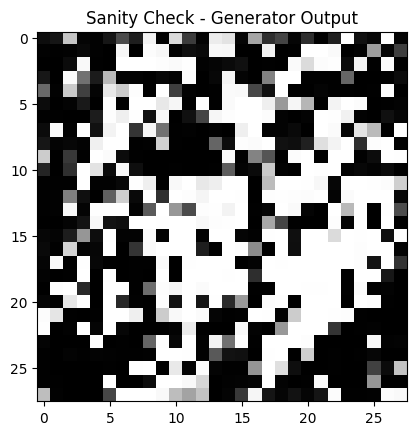

Epoch 2 | Loss_D: 0.3780 | Loss_G: 0.4354
D(real) mean: -0.20696265995502472
D(fake) mean: 1.0192843675613403
Generator grad-norm: 0.46650928939925507
Epoch 3 | Loss_D: 0.3789 | Loss_G: 0.4244
D(real) mean: -0.04308609664440155
D(fake) mean: 1.065332055091858
Generator grad-norm: 0.10796630787081085
Epoch 4 | Loss_D: 0.3754 | Loss_G: 0.4435
D(real) mean: -0.0872369259595871
D(fake) mean: 0.9319971799850464
Generator grad-norm: 0.13723400577146094
Epoch 5 | Loss_D: 0.3797 | Loss_G: 0.4369
D(real) mean: -0.09832652658224106
D(fake) mean: 1.0413198471069336
Generator grad-norm: 0.13969561355770566
Epoch 6 | Loss_D: 0.3748 | Loss_G: 0.4548
D(real) mean: -0.16517594456672668
D(fake) mean: 0.9055189490318298
Generator grad-norm: 0.2969808040361386
Epoch 7 | Loss_D: 0.3613 | Loss_G: 0.4714
D(real) mean: -0.11361096799373627
D(fake) mean: 0.8212057948112488
Generator grad-norm: 0.2524021958670346
Epoch 8 | Loss_D: 0.3770 | Loss_G: 0.4877
D(real) mean: -0.11992713809013367
D(fake) mean: 0.73154

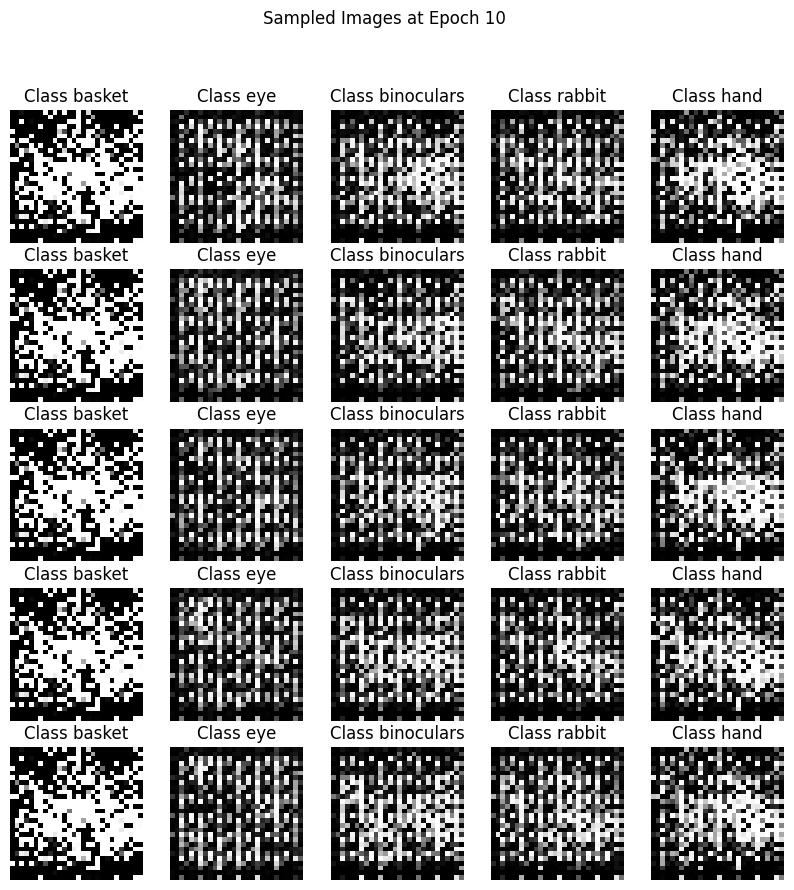

Epoch 11 | Loss_D: 0.3757 | Loss_G: 0.4593
D(real) mean: -0.43558719754219055
D(fake) mean: 0.8661606311798096
Generator grad-norm: 0.15087324440537486
Epoch 12 | Loss_D: 0.3824 | Loss_G: 0.4470
D(real) mean: -0.3999292254447937
D(fake) mean: 0.8676038384437561
Generator grad-norm: 0.16676431302039418
Epoch 13 | Loss_D: 0.3646 | Loss_G: 0.4956
D(real) mean: -0.4261491000652313
D(fake) mean: 0.688611626625061
Generator grad-norm: 0.18766294935630867
Epoch 14 | Loss_D: 0.3865 | Loss_G: 0.4978
D(real) mean: -0.35805147886276245
D(fake) mean: 0.6529662609100342
Generator grad-norm: 0.18766746352775954
Epoch 15 | Loss_D: 0.3628 | Loss_G: 0.4995
D(real) mean: -0.35655540227890015
D(fake) mean: 0.6750773191452026
Generator grad-norm: 0.17073323148360942
Epoch 16 | Loss_D: 0.3756 | Loss_G: 0.5281
D(real) mean: -0.37619447708129883
D(fake) mean: 0.5348787307739258
Generator grad-norm: 0.3062954547785921
Epoch 17 | Loss_D: 0.3754 | Loss_G: 0.4814
D(real) mean: -0.3167029321193695
D(fake) mean: 0

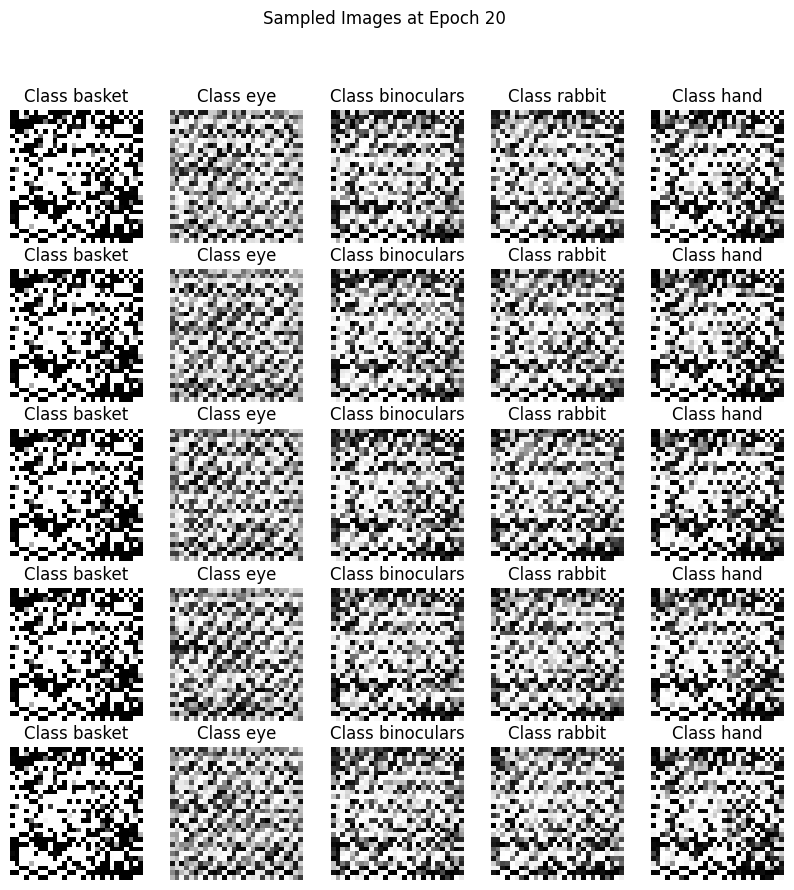

Epoch 21 | Loss_D: 0.3799 | Loss_G: 0.5119
D(real) mean: -0.24002057313919067
D(fake) mean: 0.6090463399887085
Generator grad-norm: 0.17903441853559343
Epoch 22 | Loss_D: 0.3899 | Loss_G: 0.5200
D(real) mean: -0.3484577536582947
D(fake) mean: 0.590628981590271
Generator grad-norm: 0.22335067625681404
Epoch 23 | Loss_D: 0.3880 | Loss_G: 0.5095
D(real) mean: -0.27540192008018494
D(fake) mean: 0.6267509460449219
Generator grad-norm: 0.30274608894251287
Epoch 24 | Loss_D: 0.3735 | Loss_G: 0.5123
D(real) mean: -0.27609288692474365
D(fake) mean: 0.5753408670425415
Generator grad-norm: 0.2894031555042602
Epoch 25 | Loss_D: 0.3789 | Loss_G: 0.5276
D(real) mean: -0.3219238221645355
D(fake) mean: 0.561301052570343
Generator grad-norm: 0.3727144096046686
Epoch 26 | Loss_D: 0.3729 | Loss_G: 0.5226
D(real) mean: -0.37220263481140137
D(fake) mean: 0.5606699585914612
Generator grad-norm: 0.21848749365017284
Epoch 27 | Loss_D: 0.3902 | Loss_G: 0.4936
D(real) mean: -0.3734346926212311
D(fake) mean: 0.6

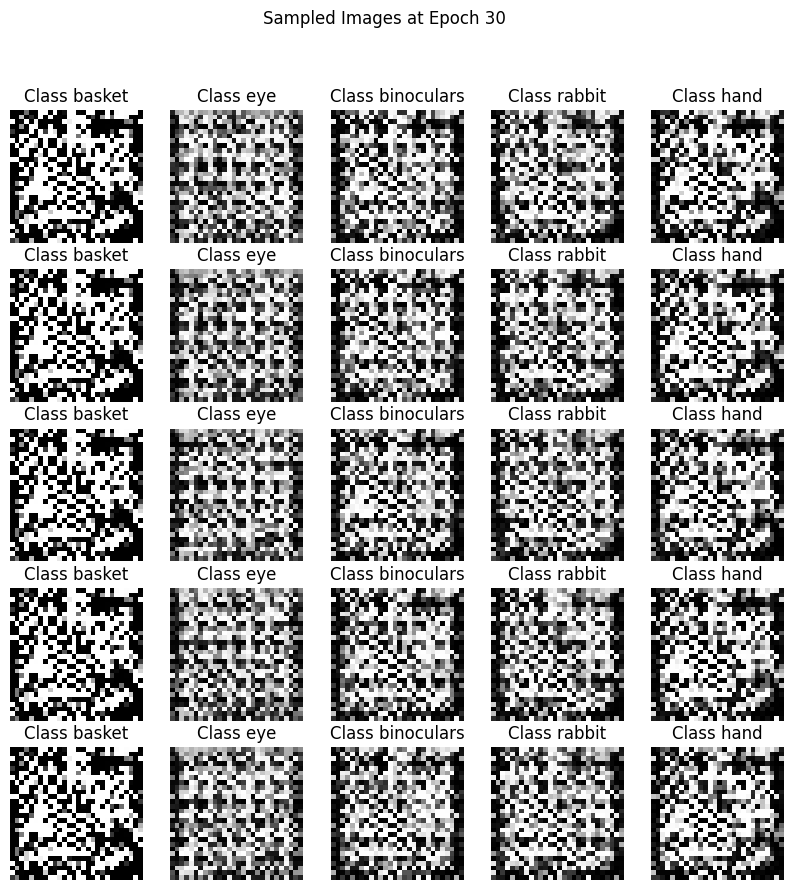

Epoch 31 | Loss_D: 0.3836 | Loss_G: 0.5208
D(real) mean: -0.463915079832077
D(fake) mean: 0.5756604671478271
Generator grad-norm: 0.3203470045409631
Epoch 32 | Loss_D: 0.3811 | Loss_G: 0.5355
D(real) mean: -0.48223328590393066
D(fake) mean: 0.5398597121238708
Generator grad-norm: 0.10431208253430668
Epoch 33 | Loss_D: 0.3732 | Loss_G: 0.5213
D(real) mean: -0.44089171290397644
D(fake) mean: 0.5401817560195923
Generator grad-norm: 0.23632548155728728
Epoch 34 | Loss_D: 0.3732 | Loss_G: 0.5294
D(real) mean: -0.40745657682418823
D(fake) mean: 0.5192041397094727
Generator grad-norm: 0.2615582670405274
Epoch 35 | Loss_D: 0.3746 | Loss_G: 0.5271
D(real) mean: -0.3954194486141205
D(fake) mean: 0.5255229473114014
Generator grad-norm: 0.21082052584097255
Epoch 36 | Loss_D: 0.3835 | Loss_G: 0.5254
D(real) mean: -0.31831037998199463
D(fake) mean: 0.5411080121994019
Generator grad-norm: 0.14856480297021335
Epoch 37 | Loss_D: 0.3662 | Loss_G: 0.5174
D(real) mean: -0.38935285806655884
D(fake) mean: 0

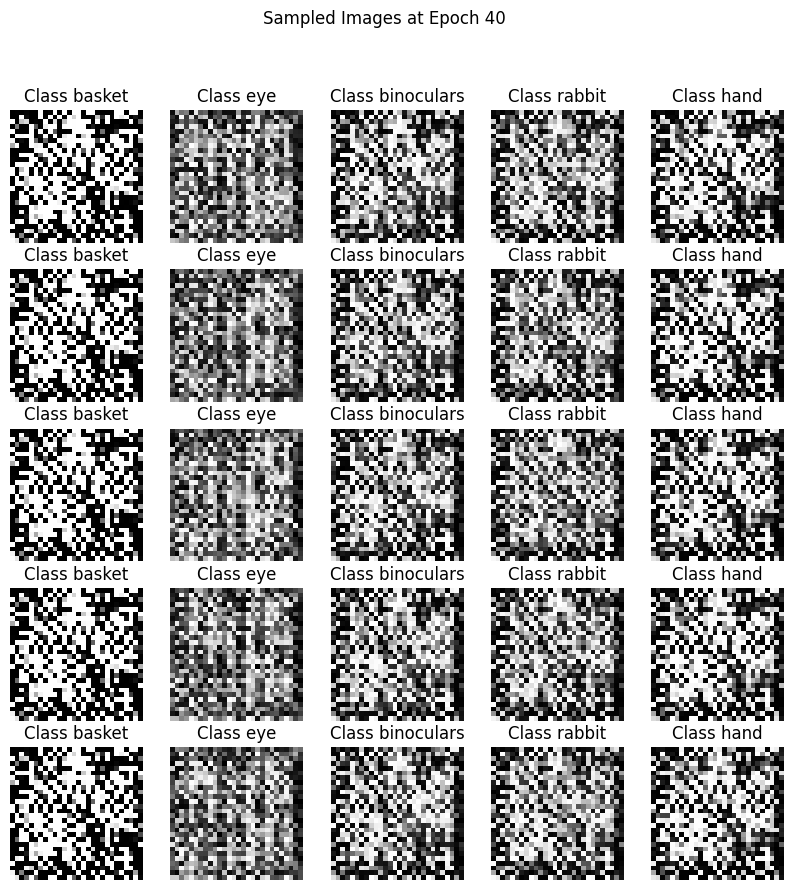

Epoch 41 | Loss_D: 0.3675 | Loss_G: 0.5509
D(real) mean: -0.3922649025917053
D(fake) mean: 0.4419807195663452
Generator grad-norm: 0.22121806867653504
Epoch 42 | Loss_D: 0.3832 | Loss_G: 0.5511
D(real) mean: -0.35518592596054077
D(fake) mean: 0.43190211057662964
Generator grad-norm: 0.36988219611521345
Epoch 43 | Loss_D: 0.3686 | Loss_G: 0.5327
D(real) mean: -0.27325496077537537
D(fake) mean: 0.5145273208618164
Generator grad-norm: 0.13022686867770972
Epoch 44 | Loss_D: 0.3701 | Loss_G: 0.5495
D(real) mean: -0.2956618666648865
D(fake) mean: 0.44883573055267334
Generator grad-norm: 0.19421021750895306
Epoch 45 | Loss_D: 0.3649 | Loss_G: 0.5700
D(real) mean: -0.3501593768596649
D(fake) mean: 0.38009631633758545
Generator grad-norm: 0.24053265128895873
Epoch 46 | Loss_D: 0.3755 | Loss_G: 0.5554
D(real) mean: -0.27682164311408997
D(fake) mean: 0.4436999559402466
Generator grad-norm: 0.1987445728300372
Epoch 47 | Loss_D: 0.3768 | Loss_G: 0.5573
D(real) mean: -0.28343963623046875
D(fake) mea

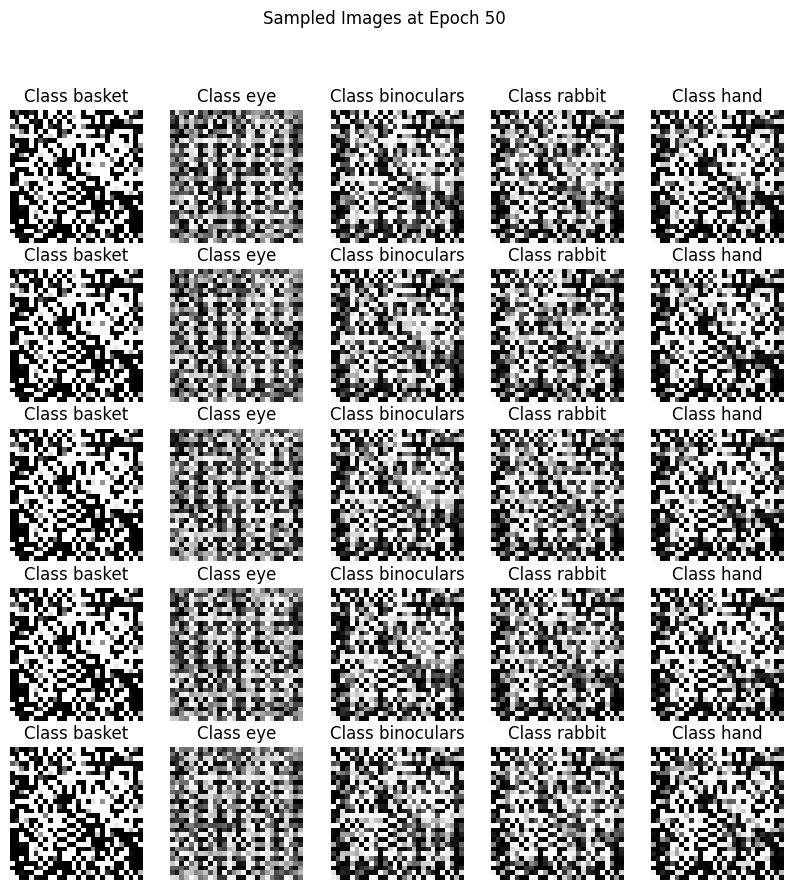

In [73]:
# Init models
G = ConditionalGenerator(noise_dim=NOISE_DIM, num_classes=len(classes), base_channels=32).to(DEVICE)
D = ConditionalDiscriminator(num_classes=len(classes), base_channels=4).to(DEVICE)

criterion = nn.BCEWithLogitsLoss()
optimizer_G = optim.Adam(G.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

# Pregenerated fixed nose and fixed labels to check if generation improves
fixed_noise = torch.randn(25, NOISE_DIM, device=DEVICE)
fixed_image_labels = torch.arange(0, len(classes)).repeat(5).to(DEVICE)

# Init weights properly
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

G.apply(weights_init_normal)
D.apply(weights_init_normal)

best_loss_G = float('inf')

save_path = '../weights/generative/cgan/conditional-gan.pt'
os.makedirs(os.path.dirname(save_path), exist_ok=True)

G_loops = 5

for epoch in range(0, NUM_EPOCHS):
    for i, (real_imgs, image_labels) in enumerate(cgan_train_loader):
        real_imgs = real_imgs.to(DEVICE)
        image_labels = image_labels.to(DEVICE)

        # Add a bit of gaussian noice to images in order to prevent the discriminator from becoming to good
        # Decay the added noise over time
        noise_std = max(0.1 * (1.0 - epoch / NUM_EPOCHS), 0.01)
        instance_noise = torch.randn_like(real_imgs) * noise_std
        noisy_real_images = real_imgs #+ instance_noise

        # Train Discriminator
        optimizer_D.zero_grad()

        # Generate fake images
        z = torch.randn(BATCH_SIZE, NOISE_DIM, device=DEVICE)
        fake_image_labels = image_labels
        fake_images = G(z, fake_image_labels)

        # Add instance noise to fake images
        noisy_fake_images = fake_images # + torch.randn_like(fake_images) * noise_std

        # Fake labels in [0.0, 0.25]
        fake_d_labels = torch.empty(BATCH_SIZE, device=DEVICE).uniform_(0.0, 0.25)
        
        # Generate real labels in [0.75, 1.0] - prevent discriminator  overconfidence
        real_d_labels = torch.empty(BATCH_SIZE, device=DEVICE).uniform_(0.75, 1.0)

        # Clamp noisy images to keep training stable
        noisy_real_images = torch.clamp(noisy_real_images, -1, 1)
        noisy_fake_images = torch.clamp(noisy_fake_images, -1, 1)

        # Shuffle real and fake images to prevent ordering bias
        all_images = torch.cat([noisy_real_images, noisy_fake_images], dim=0)
        all_image_labels = torch.cat([image_labels, fake_image_labels], dim=0)
        all_d_labels = torch.cat([real_d_labels, fake_d_labels], dim=0)

        perm = torch.randperm(all_images.size(0))
        shuffled_images = all_images[perm]
        shuffled_image_labels = all_image_labels[perm]
        shuffled_d_labels = all_d_labels[perm]

        output_D = D(all_images, all_image_labels)
        loss_D = criterion(output_D.view(-1), all_d_labels)
        loss_D.backward()
        nn.utils.clip_grad_norm_(D.parameters(), 1.0)
        optimizer_D.step()

        for _ in range(G_loops):
            # Train Generator
            optimizer_G.zero_grad()
    
            # Generate fake images again
            fake_images = G(z, fake_image_labels)
    
            # Get discriminator's prediction on these fake images with their labels
            output_D1 = D(fake_images, fake_image_labels)
    
            # Generator wants the discriminator to believe these are real
            gen_targets = torch.empty(BATCH_SIZE, device=DEVICE).uniform_(0.75, 1.0)
    
            # Compute generator loss 
            loss_G = criterion(output_D1.view(-1), gen_targets)
            
            loss_G.backward()
            nn.utils.clip_grad_norm_(G.parameters(), 1.0)
            optimizer_G.step()

        # Save best generator
        if loss_G < best_loss_G:
            best_loss_G = loss_G
            torch.save(G, save_path)

    print(f"Epoch {epoch+1} | Loss_D: {loss_D.item():.4f} | Loss_G: {loss_G.item():.4f}")
    print("D(real) mean:", D(real_imgs, image_labels).mean().item())
    print("D(fake) mean:", D(G(z, image_labels), image_labels).mean().item())

    total_norm = sum(p.grad.data.norm(2).item() for p in G.parameters() if p.grad is not None)
    print("Generator grad-norm:", total_norm)

    if epoch == 0:
        G.eval()
        with torch.no_grad():
            fake = G(torch.randn(1, NOISE_DIM, device=DEVICE), torch.tensor([0], device=DEVICE))
            plt.imshow((fake[0][0].cpu().numpy() + 1) / 2, cmap='gray')
            plt.title("Sanity Check - Generator Output")
            plt.show()
        G.train()

    # Save sample images
    if (epoch + 1) % 10 == 0:
        G.eval()
        sample_images(G, fixed_noise, fixed_image_labels, epoch+1)
        G.train()

## Non-conditional GAN

Maybe training the generator to produce output for every class is less efficient then just training five smaller models.

In [103]:
# The Generator
class Generator(nn.Module):
    def __init__(self, noise_dim=100, base_channels=64):
        super(Generator, self).__init__()
        
        # Calculate channels
        self.ch1 = base_channels
        self.ch2 = base_channels * 2
        self.ch3 = base_channels * 4

        # Project noise vector to feature map
        self.linear = nn.Linear(noise_dim, self.ch3 * 3 * 3)
        
        self.net = nn.Sequential(
            nn.ConvTranspose2d(self.ch3, self.ch3, kernel_size=4, stride=1, padding=0, bias=False),  # 3x3
            nn.BatchNorm2d(self.ch3),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(self.ch3, self.ch2, kernel_size=4, stride=2, padding=1, bias=False),  # 7x7
            nn.BatchNorm2d(self.ch2),
            nn.ReLU(True),

            nn.ConvTranspose2d(self.ch2, self.ch1, kernel_size=4, stride=2, padding=1, bias=False),  # 14x14
            nn.BatchNorm2d(self.ch1),
            nn.ReLU(True),

            nn.ConvTranspose2d(self.ch1 , 1, kernel_size=5, stride=1, padding=0),  # 28x28
            nn.Tanh()  # normalize to [-1,1]
        )

    def forward(self, noise):
        x = self.linear(noise)
        x = x.view(-1, self.ch3, 3, 3)
        return self.net(x)

# The Discriminator
class Discriminator(nn.Module):
    def __init__(self, base_channels=64):
        super(Discriminator, self).__init__()

        # Calculate channels
        self.ch1 = base_channels
        self.ch2 = base_channels * 2

        self.net = nn.Sequential(
            nn.Conv2d(1, self.ch1, kernel_size=4, stride=2, padding=1, bias=False),  # 28x28 -> 14x14
            nn.BatchNorm2d(self.ch1),
            nn.LeakyReLU(0.2, inplace=True),
        
            nn.Conv2d(self.ch1, self.ch2, kernel_size=4, stride=2, padding=1, bias=False),  # 14x14 -> 7x7
            nn.BatchNorm2d(self.ch2),
            nn.LeakyReLU(0.2, inplace=True),
        
            nn.Conv2d(self.ch2, 1, kernel_size=7, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.net(img)

In [94]:
def sample_gan_images(generator, noise, epoch):
    with torch.no_grad():
        generated_images = generator(noise) 
        generated_images = (generated_images + 1) / 2  # Unnormalize from [-1, 1] to [0, 1]

    _, axs = plt.subplots(1, 5, figsize=(5*2, 2))
    for i in range(5):
        ax = axs[i]
        img = generated_images[i, 0].cpu()

        ax.imshow(img, cmap='gray')
        ax.axis('off')
        
    plt.suptitle(f'Sampled Images at Epoch {epoch}')
    plt.show()

In [113]:
def train_gan_model(
    name,
    G,
    D,
    train_loader,
    save_path,
):
    G.to(DEVICE)
    D.to(DEVICE)
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    criterion = nn.BCELoss()
    optimizer_G = optim.Adam(G.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(D.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    
    # Pregenerated fixed nose and fixed labels to check if generation improves
    fixed_noise = torch.randn(5, NOISE_DIM, device=DEVICE)
    
    # Init weights properly
    def weights_init_normal(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)
    
    G.apply(weights_init_normal)
    D.apply(weights_init_normal)
    
    best_loss_G = float('inf')

    print(f'Start training {name}')
    
    for epoch in range(0, NUM_EPOCHS):
        for i, (real_imgs, _) in enumerate(train_loader):
            real_imgs = real_imgs.to(DEVICE)

            # Debug: Plot images from the dataloader
            #imgs = real_imgs.cpu() * 0.5 + 0.5  # if normalized to [-1,1]; skip if already [0,1]
            #grid_img = vutils.make_grid(imgs, nrow=8, padding=2, normalize=False)
            #plt.figure(figsize=(10, 10))
            #plt.imshow(grid_img.permute(1, 2, 0))  # CHW -> HWC for plt
            #plt.axis('off')
            #plt.show()
    
            # Add a bit of gaussian noice to images in order to prevent the discriminator from becoming to good
            # Decay the added noise over time
            noise_std = max(0.1 * (1.0 - epoch / NUM_EPOCHS), 0.01)
            instance_noise = torch.randn_like(real_imgs) * noise_std
            noisy_real_images = torch.clamp(real_imgs + instance_noise, -1, 1)
    
            # Train Discriminator
            optimizer_D.zero_grad()
    
            # Generate fake images
            z = torch.randn(BATCH_SIZE, NOISE_DIM, device=DEVICE)
            fake_images = G(z)
    
            # Add instance noise to fake images
            noisy_fake_images = fake_images + torch.randn_like(fake_images) * noise_std
    
            # Fake labels in [0.0, 0.25]
            fake_d_labels = torch.empty(BATCH_SIZE, device=DEVICE).uniform_(0.0, 0.25)
            
            # Generate real labels in [0.75, 1.0] - prevent discriminator  overconfidence
            real_d_labels = torch.empty(BATCH_SIZE, device=DEVICE).uniform_(0.75, 1.0)
    
            # Clamp noisy images to keep training stable
            noisy_real_images = torch.clamp(noisy_real_images, -1, 1)
            noisy_fake_images = torch.clamp(noisy_fake_images, -1, 1)
    
            # Shuffle real and fake images to prevent ordering bias
            all_images = torch.cat([noisy_real_images, noisy_fake_images], dim=0)
            all_d_labels = torch.cat([real_d_labels, fake_d_labels], dim=0)
    
            perm = torch.randperm(all_images.size(0))
            shuffled_images = all_images[perm]
            shuffled_d_labels = all_d_labels[perm]
    
            outputs = D(shuffled_images)
            loss_D = criterion(outputs.view(-1), shuffled_d_labels)
            loss_D.backward()
            optimizer_D.step()
    
            # Train Generator
            optimizer_G.zero_grad()
    
            # Generate fake images again
            fake_images = G(z)
    
            # Get discriminator's prediction on these fake images with their labels
            outputs = D(fake_images)
    
            # Generator wants the discriminator to believe these are real
            gen_targets = torch.empty(BATCH_SIZE, device=DEVICE).uniform_(0.75, 1.0)
    
            # Compute generator loss 
            loss_G = criterion(outputs.view(-1), gen_targets)
            
            loss_G.backward()
            optimizer_G.step()
    
            # Save best generator
            if loss_G < best_loss_G:
                best_loss_G = loss_G
                torch.save(G, save_path)
    
        print(f"Epoch {epoch+1} | Loss_D: {loss_D.item():.4f} | Loss_G: {loss_G.item():.4f}")
    
        # Save sample images
        if True: #(epoch) % 10 == 0:
            G.eval()
            sample_gan_images(G, fixed_noise, epoch+1)
            G.train()

    print(f'Training {name} completed!')

Start training gan-basket
Epoch 1 | Loss_D: 0.3780 | Loss_G: 0.3593


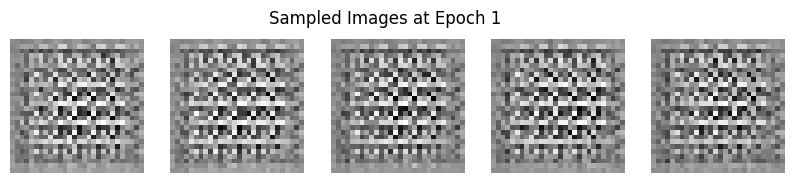

Epoch 2 | Loss_D: 0.3730 | Loss_G: 0.3574


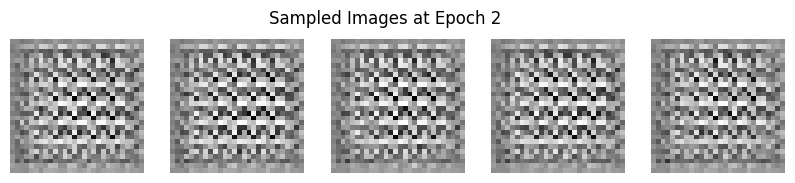

Epoch 3 | Loss_D: 0.3712 | Loss_G: 0.3575


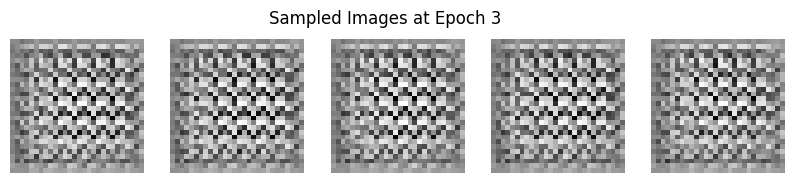

Epoch 4 | Loss_D: 0.3897 | Loss_G: 0.3602


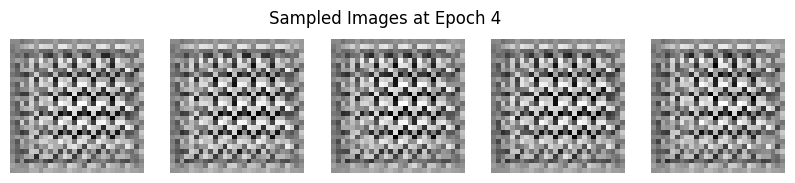

Epoch 5 | Loss_D: 0.3807 | Loss_G: 0.3684


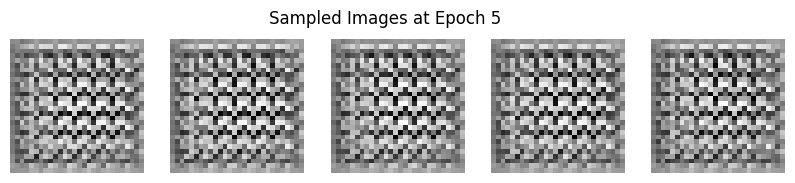

Epoch 6 | Loss_D: 0.3892 | Loss_G: 0.3868


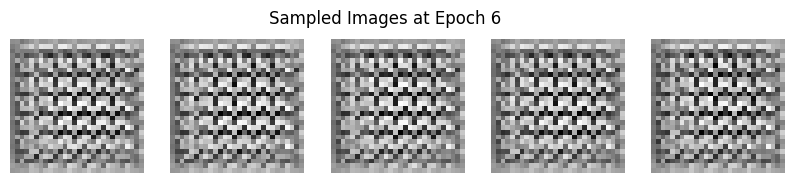

Epoch 7 | Loss_D: 0.3888 | Loss_G: 0.3755


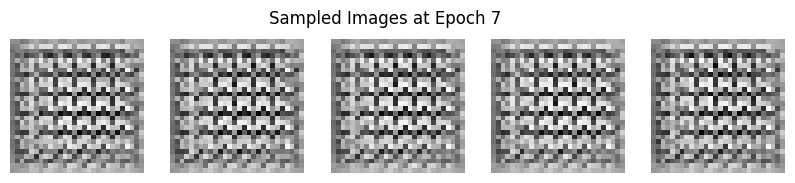

Epoch 8 | Loss_D: 0.3732 | Loss_G: 0.3796


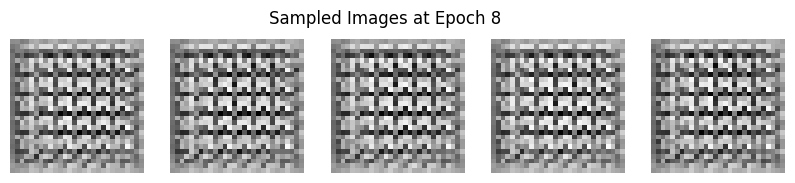

Epoch 9 | Loss_D: 0.3638 | Loss_G: 0.3949


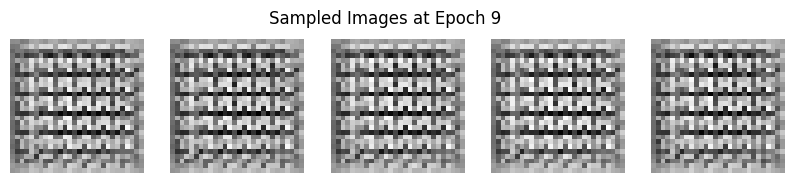

Epoch 10 | Loss_D: 0.3747 | Loss_G: 0.3922


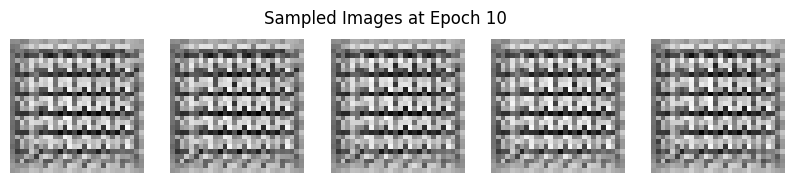

Epoch 11 | Loss_D: 0.3818 | Loss_G: 0.3842


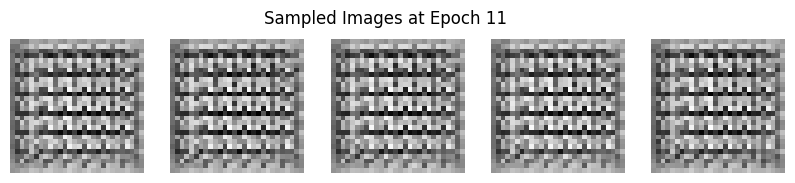

Epoch 12 | Loss_D: 0.3751 | Loss_G: 0.3732


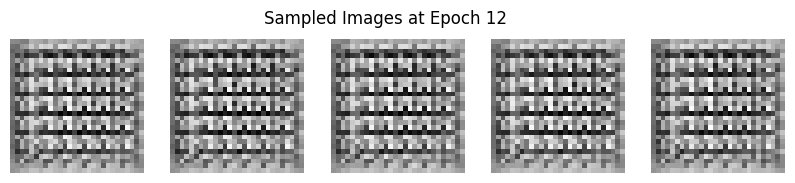

Epoch 13 | Loss_D: 0.3736 | Loss_G: 0.3787


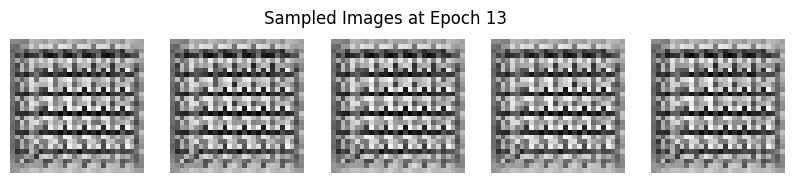

Epoch 14 | Loss_D: 0.3819 | Loss_G: 0.3929


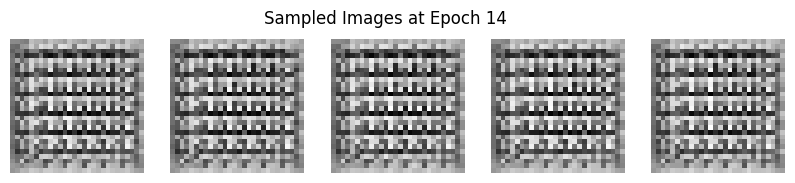

Epoch 15 | Loss_D: 0.3768 | Loss_G: 0.4137


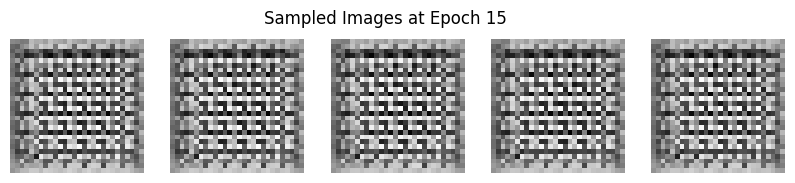

Epoch 16 | Loss_D: 0.3619 | Loss_G: 0.3711


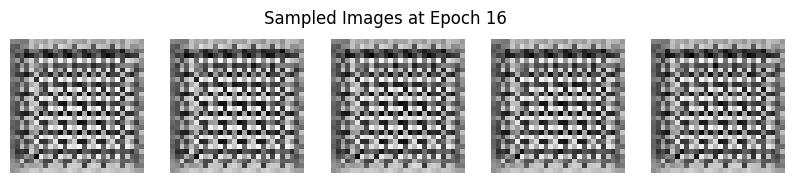

Epoch 17 | Loss_D: 0.3738 | Loss_G: 0.3834


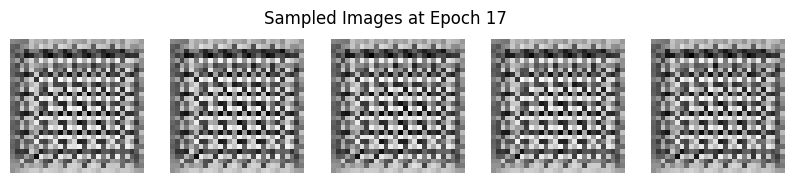

Epoch 18 | Loss_D: 0.3872 | Loss_G: 0.3784


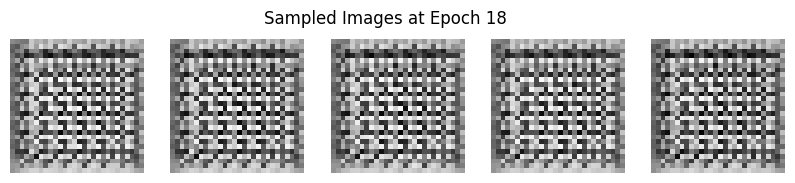

Epoch 19 | Loss_D: 0.3598 | Loss_G: 0.3499


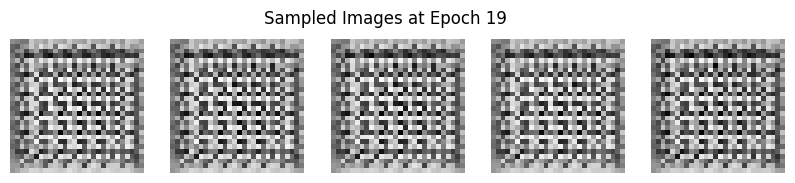

Epoch 20 | Loss_D: 0.3808 | Loss_G: 0.3721


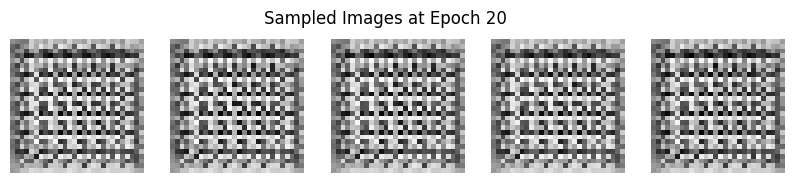

Epoch 21 | Loss_D: 0.3815 | Loss_G: 0.3563


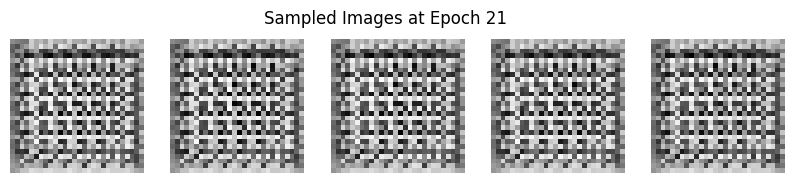

Epoch 22 | Loss_D: 0.3803 | Loss_G: 0.3750


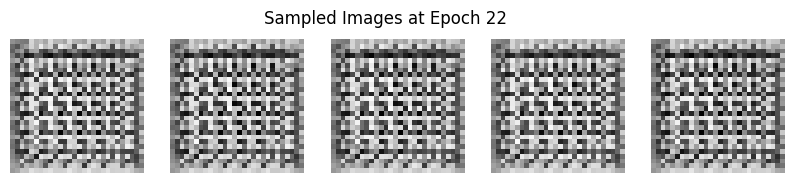

Epoch 23 | Loss_D: 0.3785 | Loss_G: 0.3717


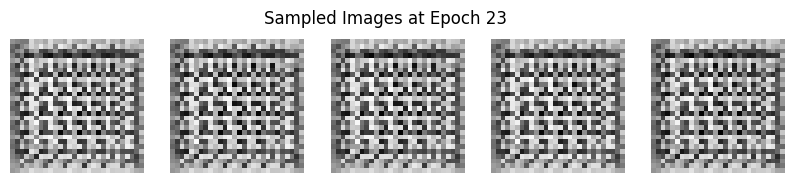

Epoch 24 | Loss_D: 0.3849 | Loss_G: 0.3725


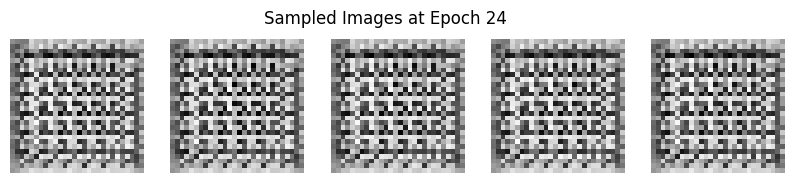

Epoch 25 | Loss_D: 0.3771 | Loss_G: 0.3817


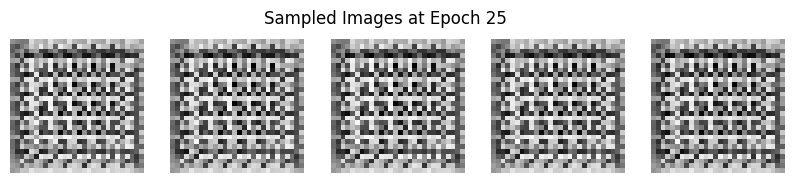

Epoch 26 | Loss_D: 0.3872 | Loss_G: 0.3716


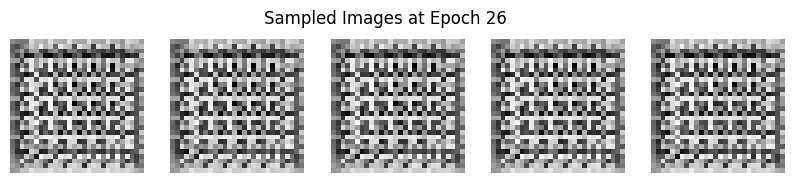

Epoch 27 | Loss_D: 0.3742 | Loss_G: 0.3896


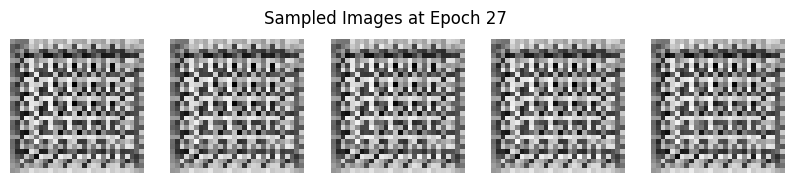

Epoch 28 | Loss_D: 0.3760 | Loss_G: 0.3762


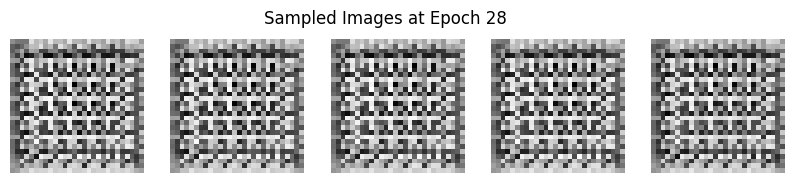

Epoch 29 | Loss_D: 0.3958 | Loss_G: 0.3775


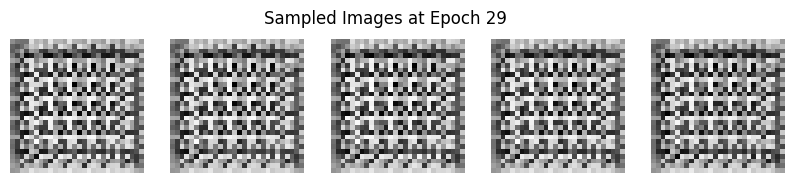

Epoch 30 | Loss_D: 0.3894 | Loss_G: 0.3713


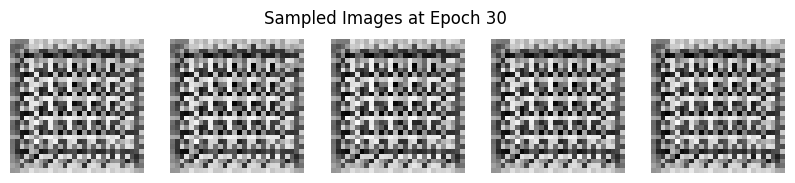

Epoch 31 | Loss_D: 0.3750 | Loss_G: 0.4006


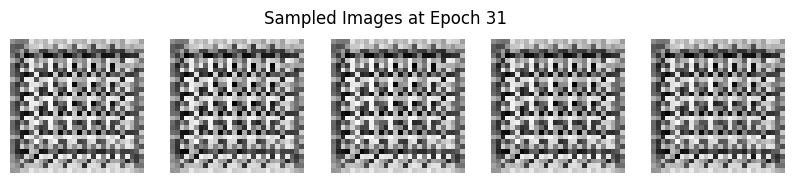

Epoch 32 | Loss_D: 0.3815 | Loss_G: 0.3759


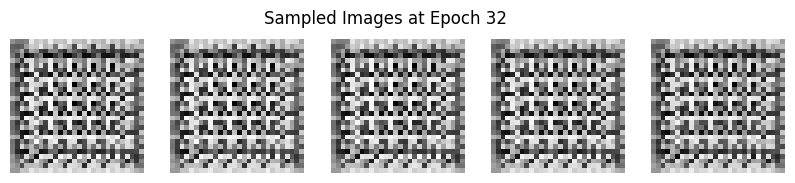

Epoch 33 | Loss_D: 0.3670 | Loss_G: 0.3572


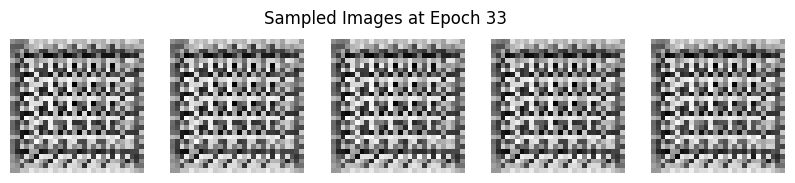

Epoch 34 | Loss_D: 0.3772 | Loss_G: 0.3816


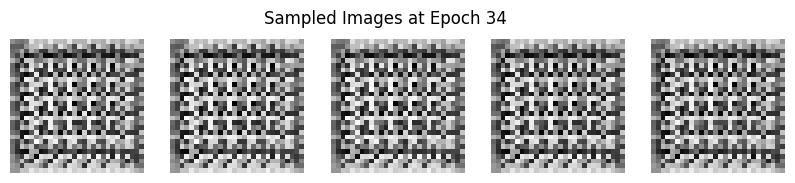

Epoch 35 | Loss_D: 0.3770 | Loss_G: 0.3669


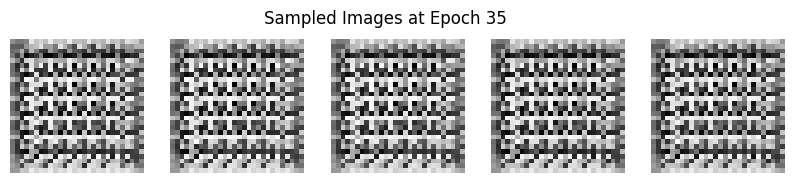

Epoch 36 | Loss_D: 0.3727 | Loss_G: 0.3958


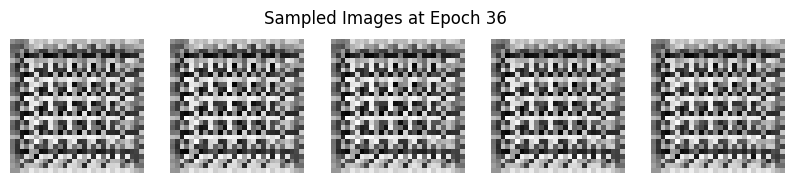

Epoch 37 | Loss_D: 0.3725 | Loss_G: 0.3706


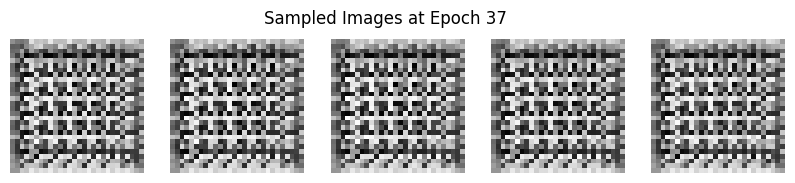

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b88c88956c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.13/dist-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.13/dist-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.13/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b88c88956c0>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.13/dist-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7b88c88956c0>self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/pyt

Epoch 38 | Loss_D: 0.3637 | Loss_G: 0.3680


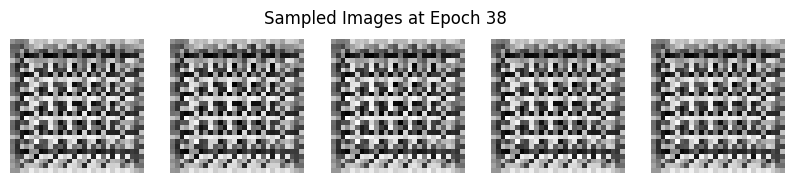

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b88c88956c0>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.13/dist-packages/torch/utils/data/dataloader.py", line 1663, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b88c88956c0>    
self._shutdown_workers()Traceback (most recent call last):

Exception ignored in:   File "/usr/local/lib/python3.13/dist-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/usr/local/lib/python3.13/dist-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7b88c88956c0>    if w.is_alive():
self._shutdown_workers()
Traceback (most recent call last):

  File "/usr/lib/python3.13/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.13/dist-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/usr/local/lib/python3.13/dist-packag

Epoch 39 | Loss_D: 0.3783 | Loss_G: 0.4041


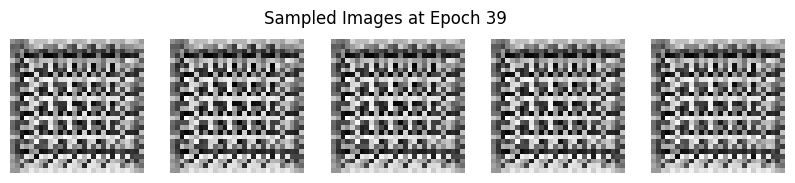

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b88c88956c0>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.13/dist-packages/torch/utils/data/dataloader.py", line 1663, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b88c88956c0>    
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.13/dist-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/usr/local/lib/python3.13/dist-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
        self._shutdown_workers()
if w.is_alive():  File "/usr/local/lib/python3.13/dist-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers

      File "/usr/lib/python3.13/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():
      File "/usr/lib/python3.13/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a

Epoch 40 | Loss_D: 0.3801 | Loss_G: 0.3704


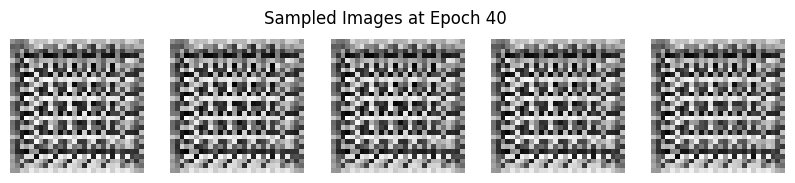

Epoch 41 | Loss_D: 0.3778 | Loss_G: 0.3697


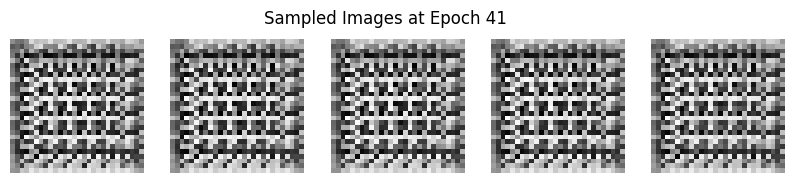

Epoch 42 | Loss_D: 0.3711 | Loss_G: 0.3636


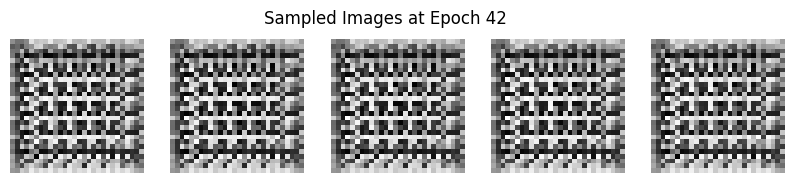

Epoch 43 | Loss_D: 0.3848 | Loss_G: 0.3587


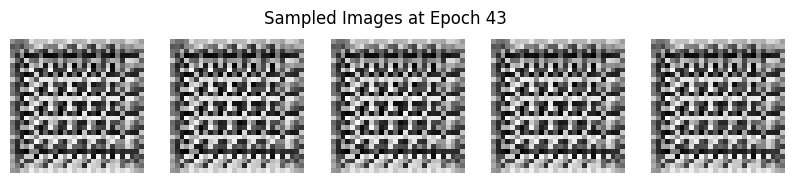

Epoch 44 | Loss_D: 0.3692 | Loss_G: 0.3778


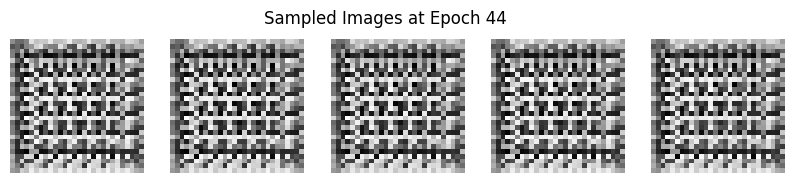

Epoch 45 | Loss_D: 0.3711 | Loss_G: 0.3772


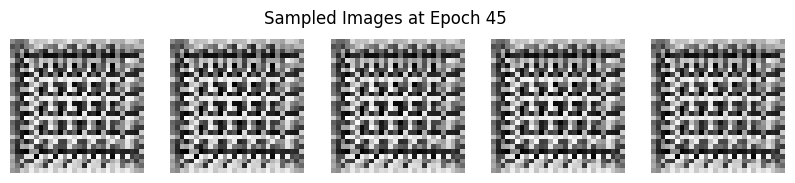

Epoch 46 | Loss_D: 0.3749 | Loss_G: 0.3964


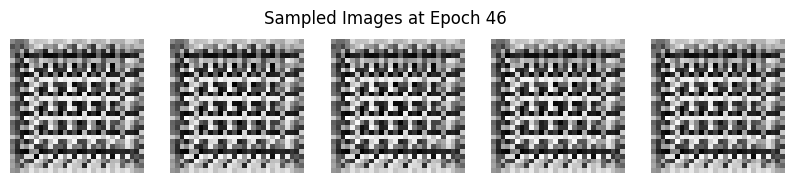

Epoch 47 | Loss_D: 0.3741 | Loss_G: 0.3780


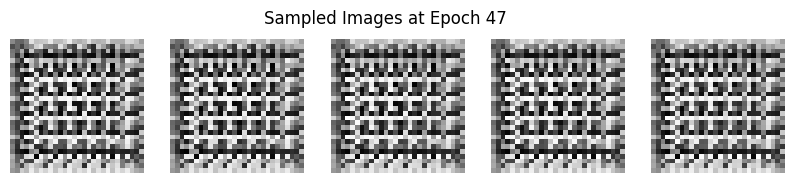

Epoch 48 | Loss_D: 0.3847 | Loss_G: 0.3622


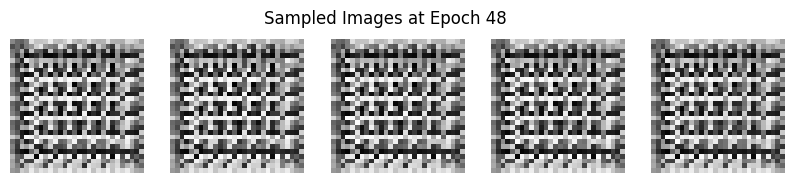

Epoch 49 | Loss_D: 0.3740 | Loss_G: 0.3915


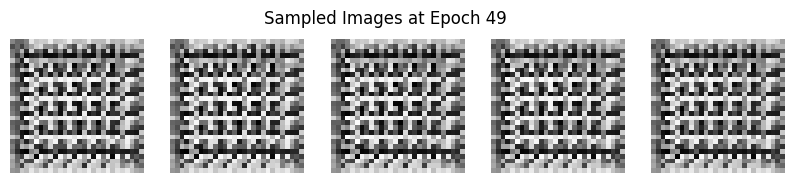

Epoch 50 | Loss_D: 0.3725 | Loss_G: 0.3625


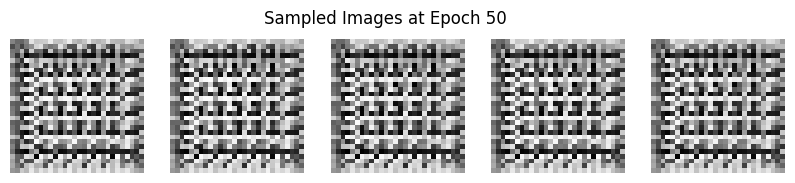

Training gan-basket completed!
Start training gan-eye
Epoch 1 | Loss_D: 0.3722 | Loss_G: 0.3623


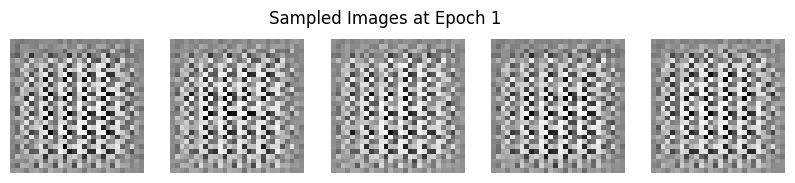

Epoch 2 | Loss_D: 0.3833 | Loss_G: 0.3633


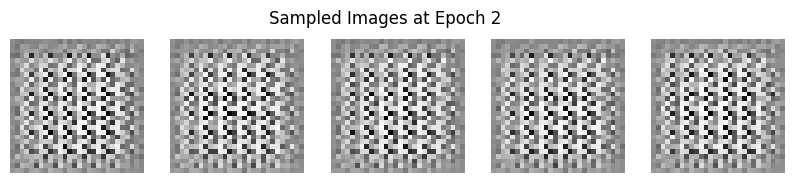

Epoch 3 | Loss_D: 0.3840 | Loss_G: 0.3744


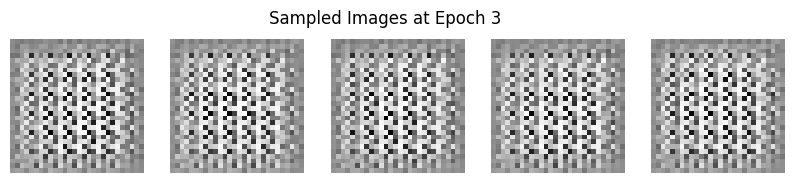

Epoch 4 | Loss_D: 0.3697 | Loss_G: 0.3693


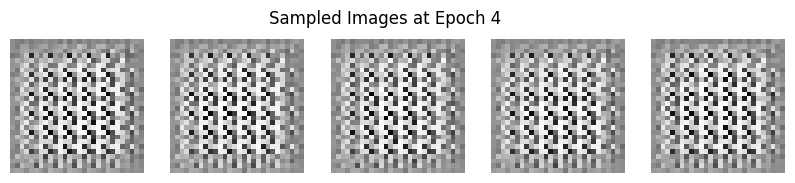

Epoch 5 | Loss_D: 0.3732 | Loss_G: 0.3749


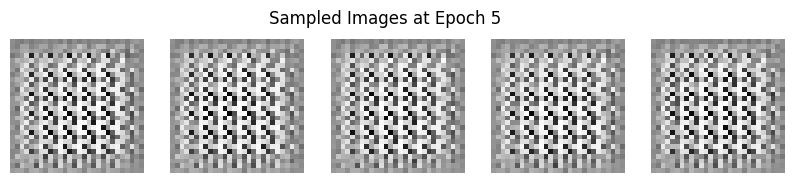

Epoch 6 | Loss_D: 0.3737 | Loss_G: 0.3810


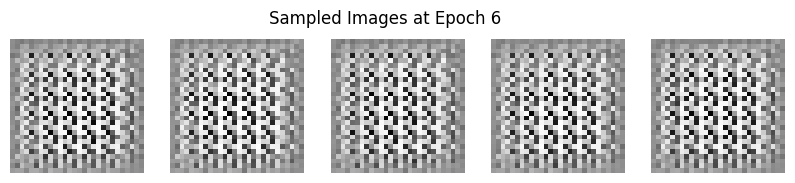

Epoch 7 | Loss_D: 0.3941 | Loss_G: 0.3810


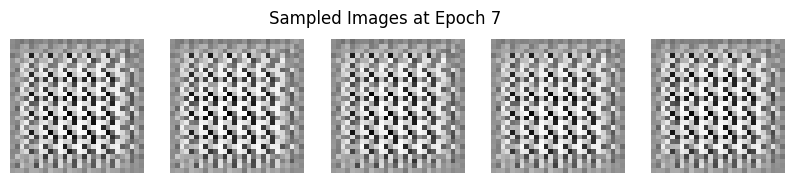

Epoch 8 | Loss_D: 0.3695 | Loss_G: 0.3666


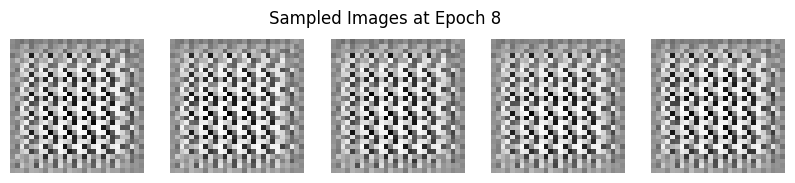

Epoch 9 | Loss_D: 0.3636 | Loss_G: 0.3661


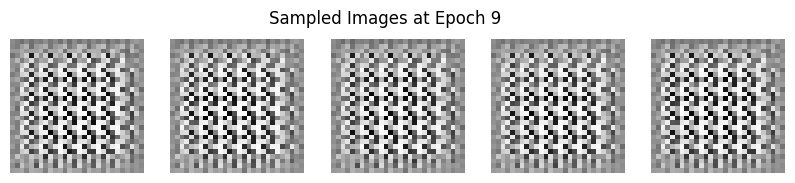

Epoch 10 | Loss_D: 0.3794 | Loss_G: 0.3676


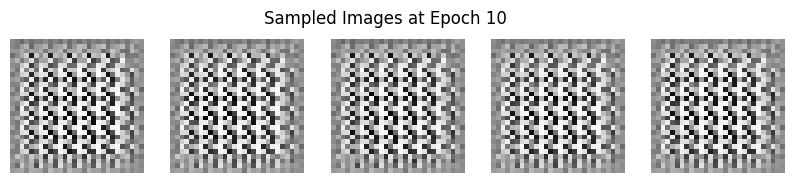

Epoch 11 | Loss_D: 0.3682 | Loss_G: 0.3819


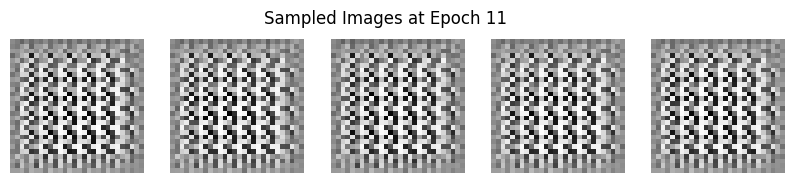

Epoch 12 | Loss_D: 0.3795 | Loss_G: 0.3799


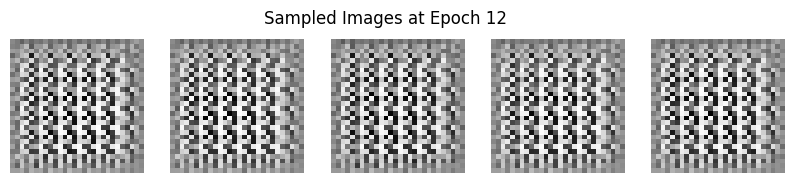

Epoch 13 | Loss_D: 0.3769 | Loss_G: 0.3755


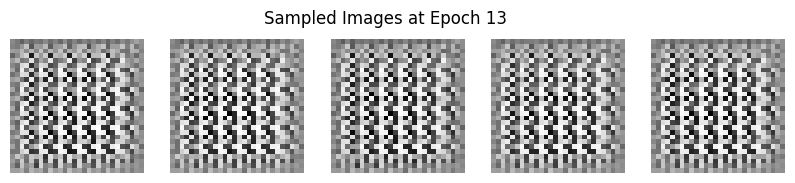

Epoch 14 | Loss_D: 0.3717 | Loss_G: 0.3640


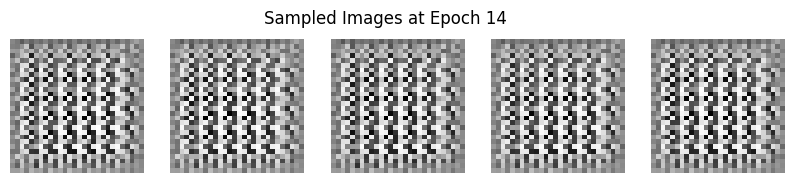

Epoch 15 | Loss_D: 0.3708 | Loss_G: 0.3916


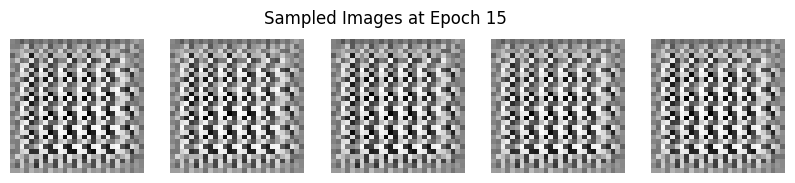

Epoch 16 | Loss_D: 0.3786 | Loss_G: 0.3701


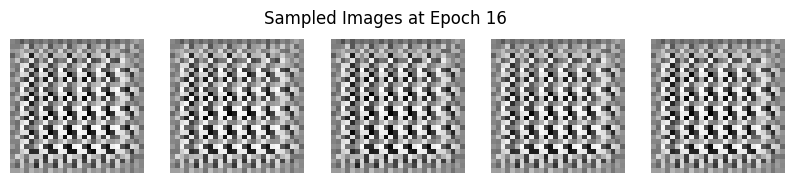

Epoch 17 | Loss_D: 0.3828 | Loss_G: 0.3796


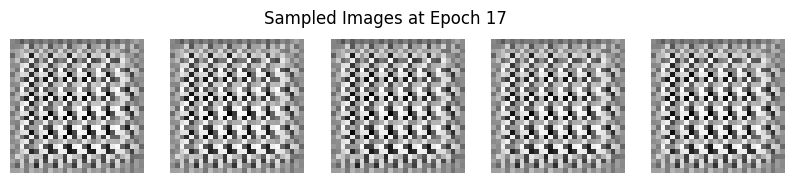

Epoch 18 | Loss_D: 0.3669 | Loss_G: 0.3990


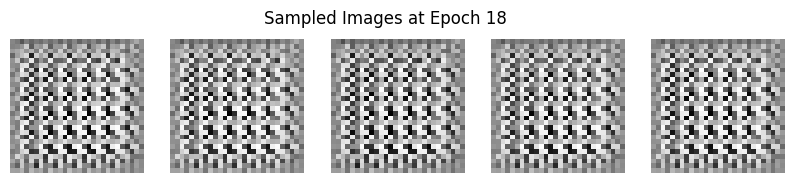

Epoch 19 | Loss_D: 0.3821 | Loss_G: 0.3843


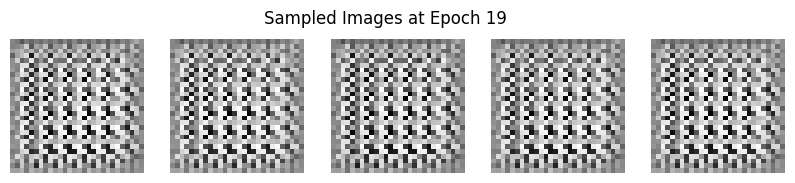

Epoch 20 | Loss_D: 0.3759 | Loss_G: 0.3766


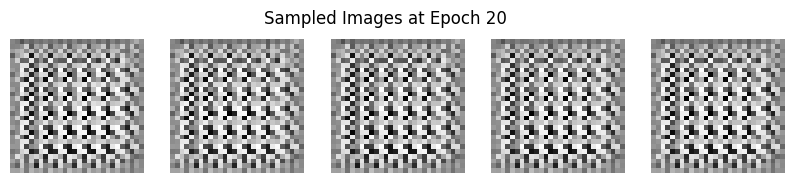

Epoch 21 | Loss_D: 0.3780 | Loss_G: 0.3847


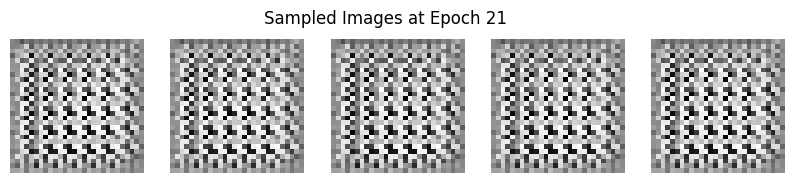

Epoch 22 | Loss_D: 0.3993 | Loss_G: 0.3768


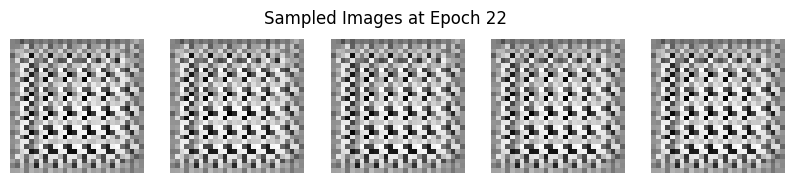

Epoch 23 | Loss_D: 0.3712 | Loss_G: 0.3814


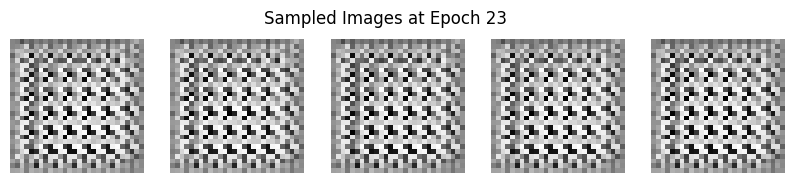

Epoch 24 | Loss_D: 0.3895 | Loss_G: 0.3725


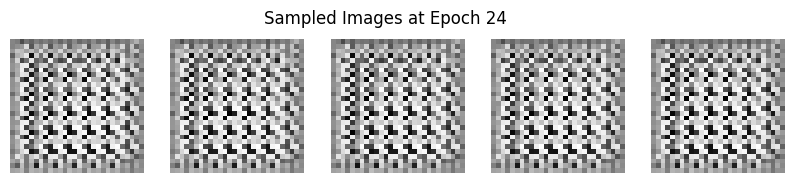

Epoch 25 | Loss_D: 0.3746 | Loss_G: 0.3697


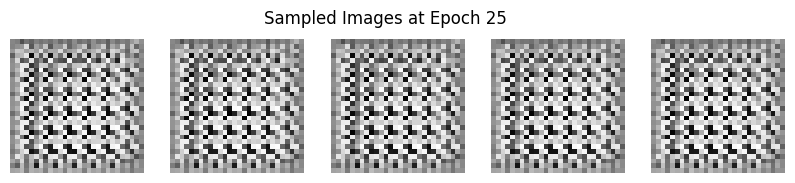

Epoch 26 | Loss_D: 0.3798 | Loss_G: 0.4093


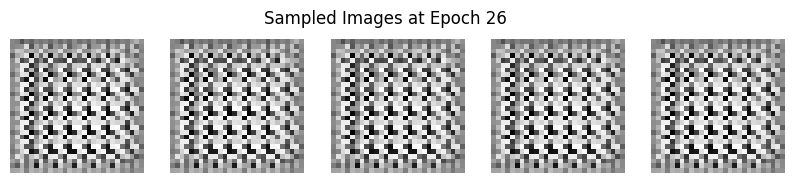

Epoch 27 | Loss_D: 0.3780 | Loss_G: 0.3901


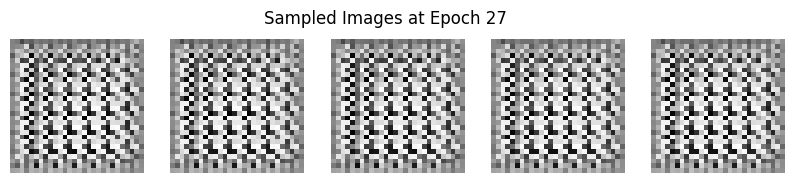

Epoch 28 | Loss_D: 0.3776 | Loss_G: 0.3634


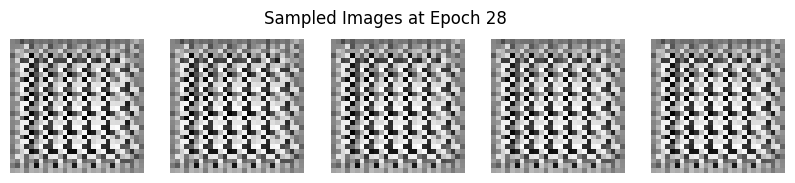

Epoch 29 | Loss_D: 0.3822 | Loss_G: 0.3845


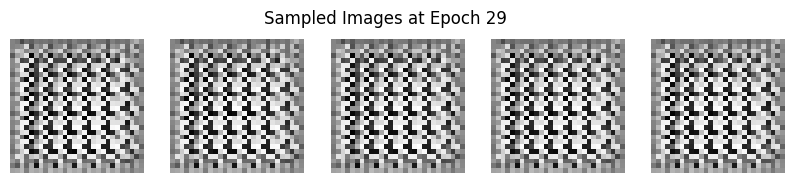

Epoch 30 | Loss_D: 0.3813 | Loss_G: 0.3821


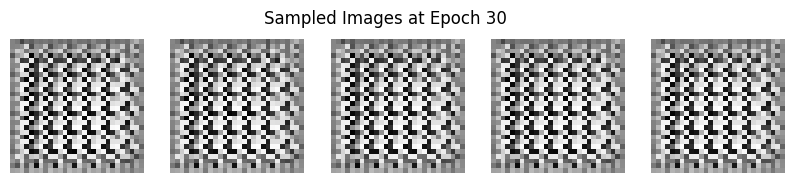

Epoch 31 | Loss_D: 0.3771 | Loss_G: 0.3849


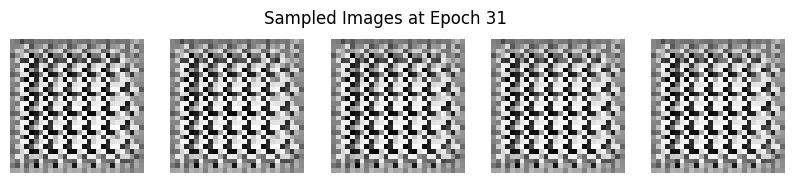

Epoch 32 | Loss_D: 0.3874 | Loss_G: 0.3792


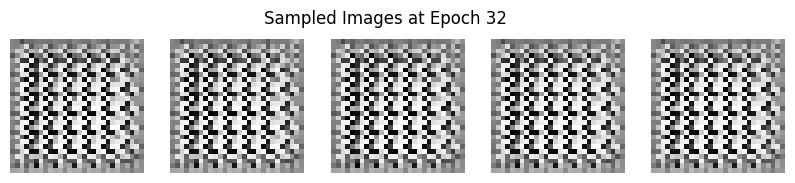

Epoch 33 | Loss_D: 0.3825 | Loss_G: 0.3677


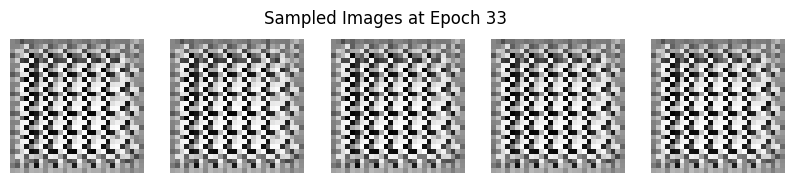

Epoch 34 | Loss_D: 0.3811 | Loss_G: 0.3913


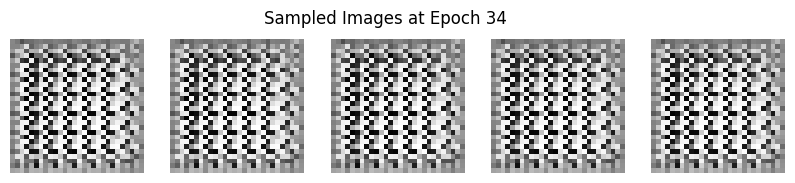

Epoch 35 | Loss_D: 0.3718 | Loss_G: 0.3577


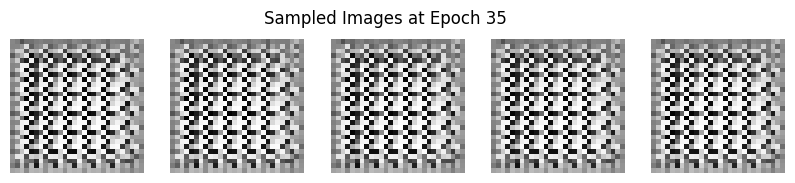

Epoch 36 | Loss_D: 0.3681 | Loss_G: 0.3685


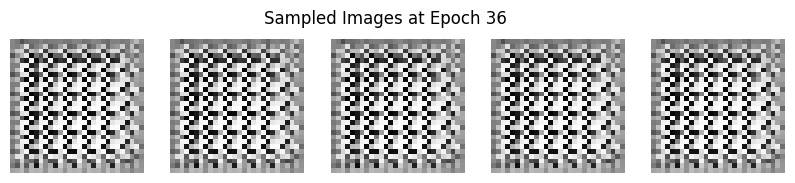

Epoch 37 | Loss_D: 0.3638 | Loss_G: 0.3718


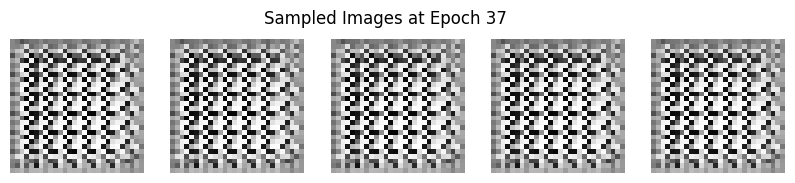

Epoch 38 | Loss_D: 0.3691 | Loss_G: 0.3921


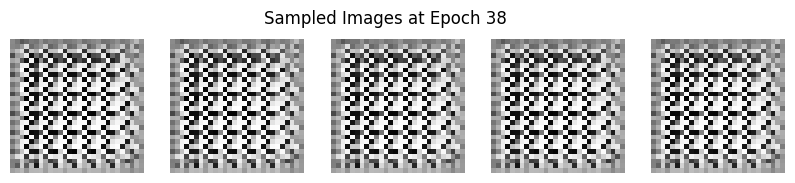

Epoch 39 | Loss_D: 0.3767 | Loss_G: 0.3718


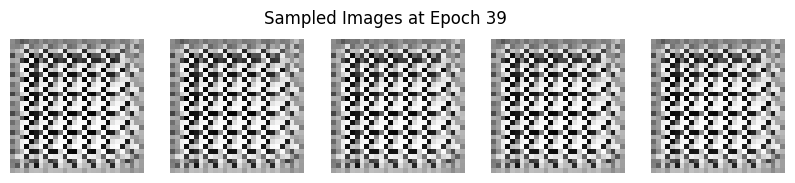

Epoch 40 | Loss_D: 0.3791 | Loss_G: 0.3892


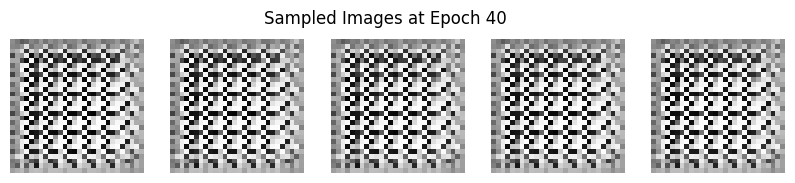

Epoch 41 | Loss_D: 0.3680 | Loss_G: 0.4039


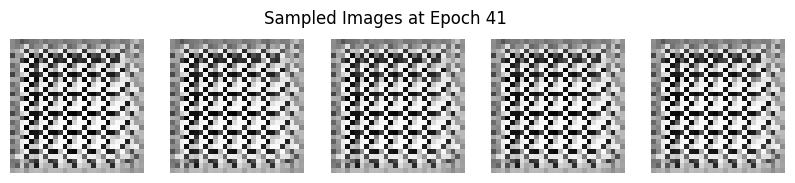

Epoch 42 | Loss_D: 0.3817 | Loss_G: 0.3689


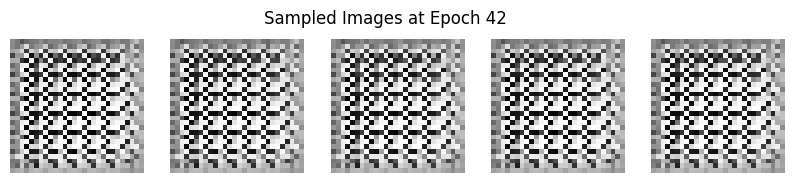

Epoch 43 | Loss_D: 0.3914 | Loss_G: 0.3861


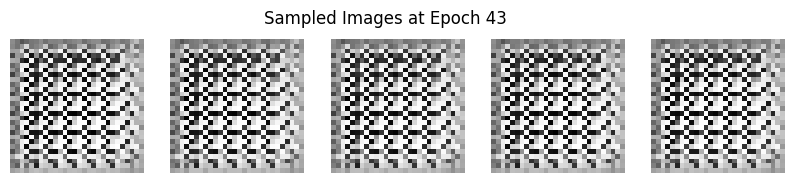

Epoch 44 | Loss_D: 0.3801 | Loss_G: 0.3687


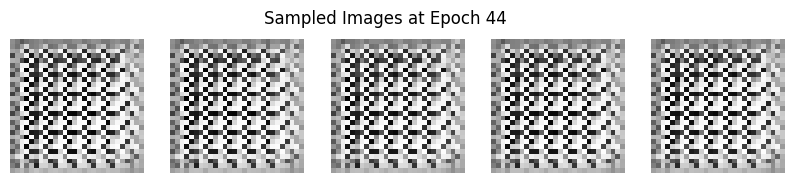

Epoch 45 | Loss_D: 0.3854 | Loss_G: 0.3871


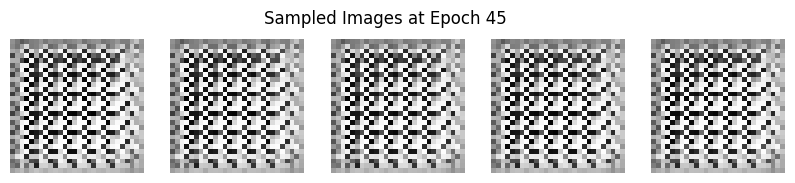

Epoch 46 | Loss_D: 0.3771 | Loss_G: 0.3698


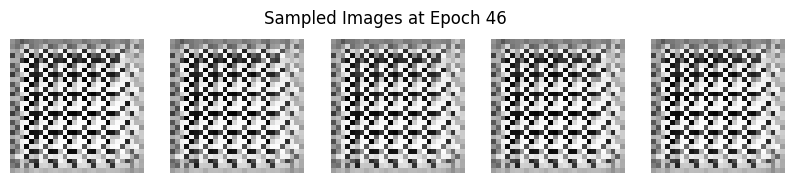

Epoch 47 | Loss_D: 0.3764 | Loss_G: 0.3611


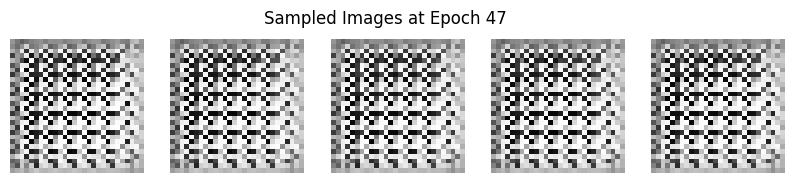

Epoch 48 | Loss_D: 0.3813 | Loss_G: 0.3770


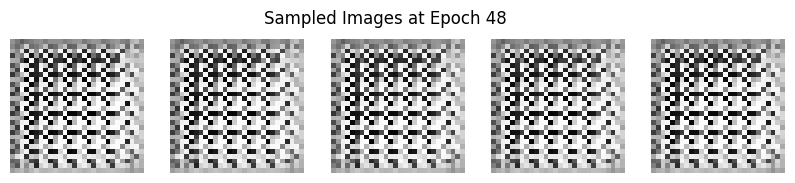

Epoch 49 | Loss_D: 0.3677 | Loss_G: 0.3941


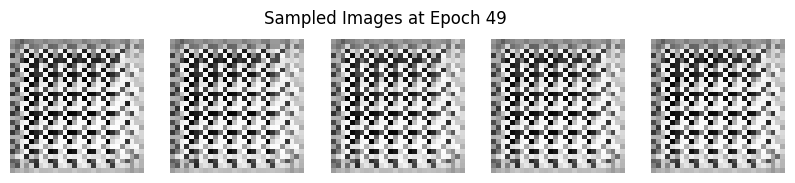

Epoch 50 | Loss_D: 0.3826 | Loss_G: 0.3649


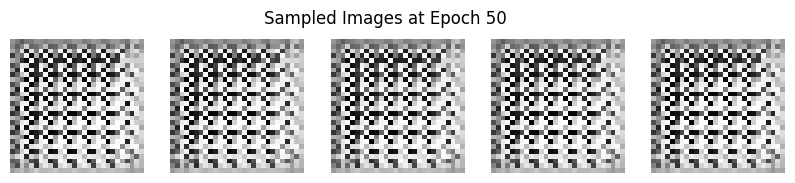

Training gan-eye completed!
Start training gan-binoculars
Epoch 1 | Loss_D: 0.3769 | Loss_G: 0.3709


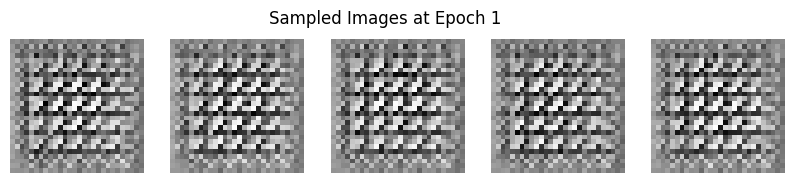

Epoch 2 | Loss_D: 0.3836 | Loss_G: 0.3877


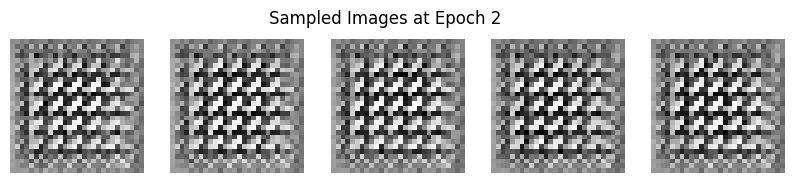

Epoch 3 | Loss_D: 0.3713 | Loss_G: 0.3756


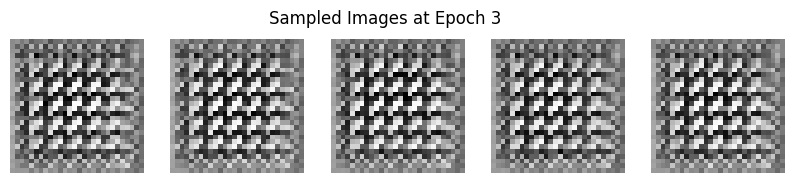

Epoch 4 | Loss_D: 0.3844 | Loss_G: 0.3672


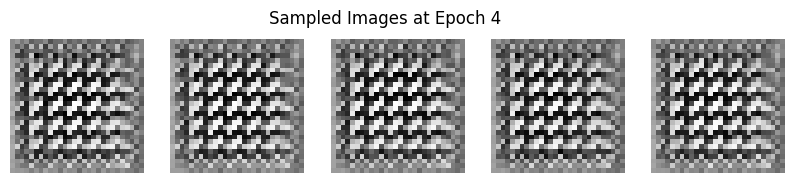

Epoch 5 | Loss_D: 0.3734 | Loss_G: 0.3743


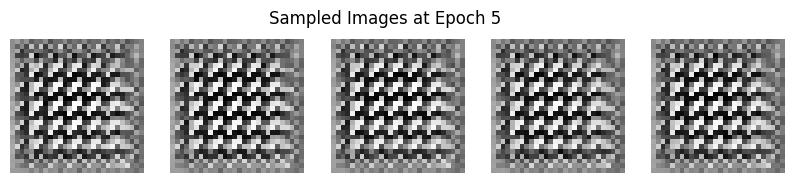

Epoch 6 | Loss_D: 0.3723 | Loss_G: 0.3789


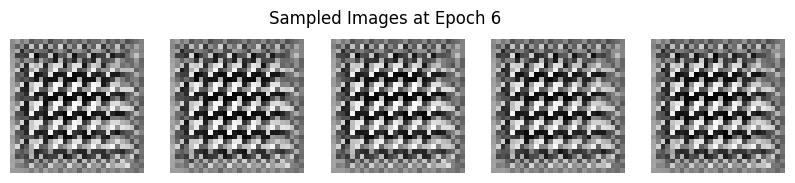

Epoch 7 | Loss_D: 0.3858 | Loss_G: 0.3625


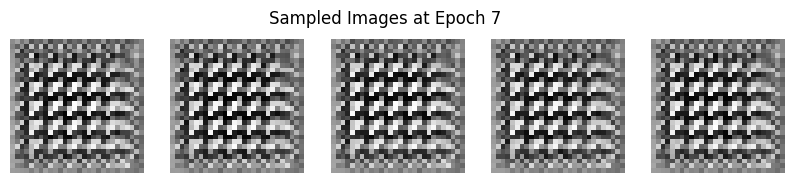

Epoch 8 | Loss_D: 0.3981 | Loss_G: 0.3783


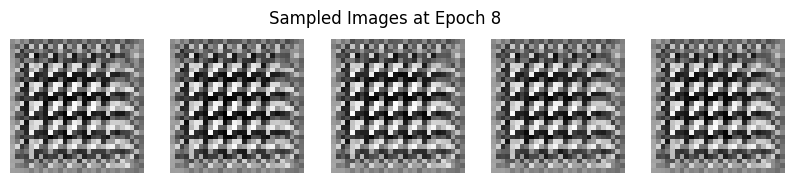

Epoch 9 | Loss_D: 0.3730 | Loss_G: 0.3808


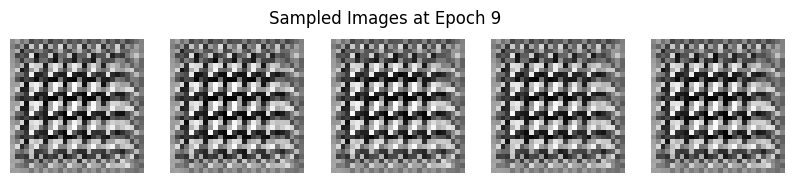

Epoch 10 | Loss_D: 0.3684 | Loss_G: 0.3922


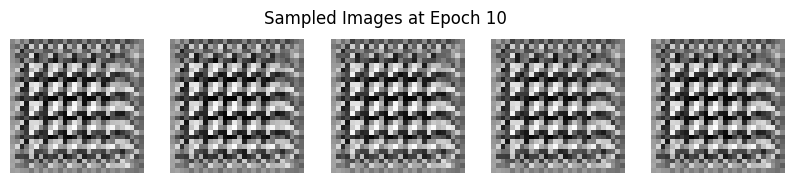

Epoch 11 | Loss_D: 0.3713 | Loss_G: 0.3811


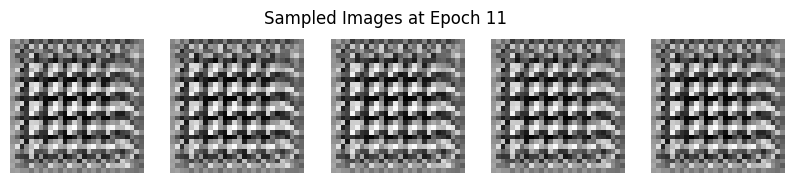

Epoch 12 | Loss_D: 0.3711 | Loss_G: 0.3847


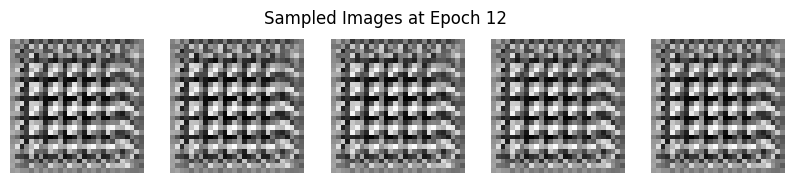

Epoch 13 | Loss_D: 0.3832 | Loss_G: 0.3753


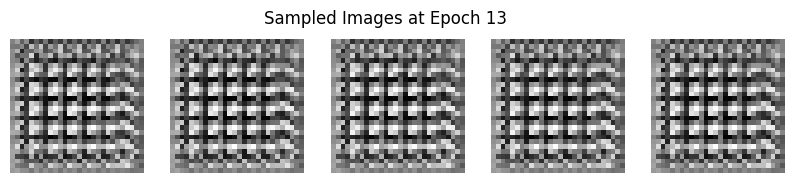

Epoch 14 | Loss_D: 0.3819 | Loss_G: 0.3583


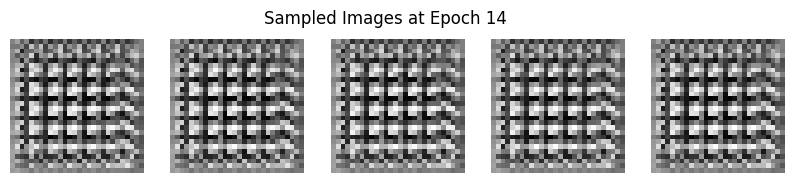

Epoch 15 | Loss_D: 0.3715 | Loss_G: 0.3742


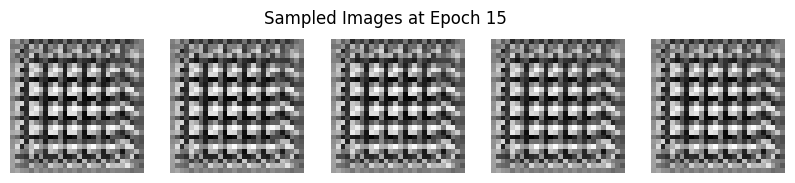

Epoch 16 | Loss_D: 0.3772 | Loss_G: 0.3599


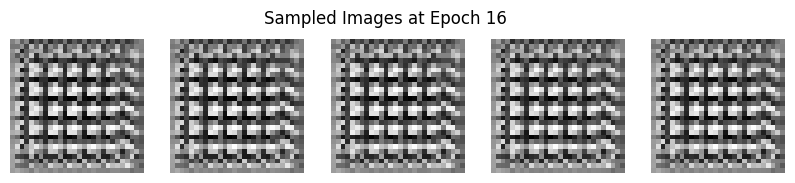

Epoch 17 | Loss_D: 0.3947 | Loss_G: 0.3719


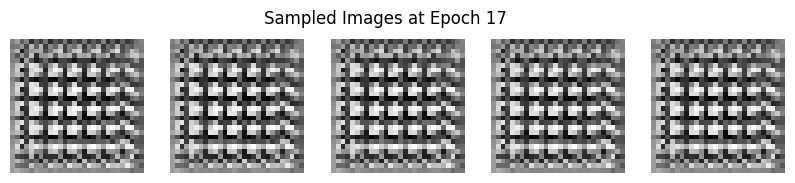

Epoch 18 | Loss_D: 0.3874 | Loss_G: 0.3773


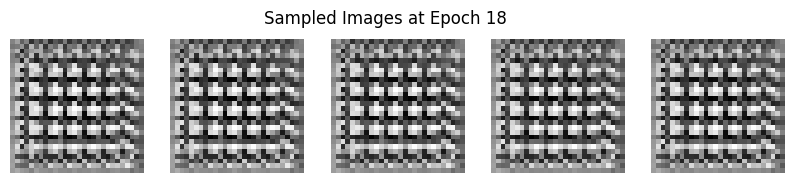

Epoch 19 | Loss_D: 0.3758 | Loss_G: 0.3662


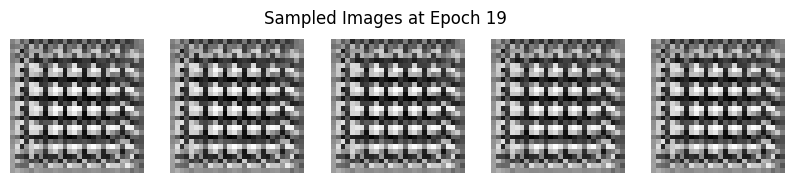

Epoch 20 | Loss_D: 0.3904 | Loss_G: 0.3970


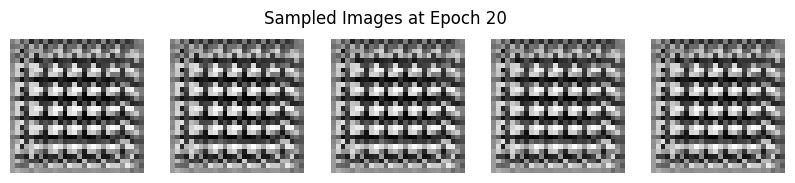

Epoch 21 | Loss_D: 0.3748 | Loss_G: 0.3743


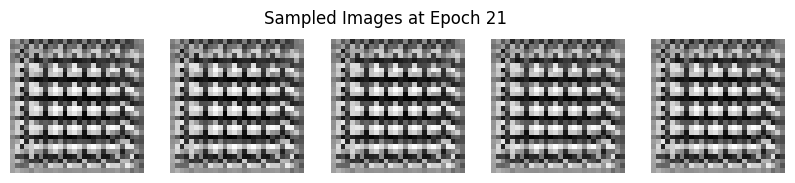

Epoch 22 | Loss_D: 0.3677 | Loss_G: 0.3564


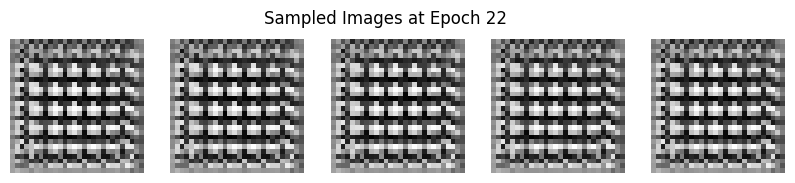

Epoch 23 | Loss_D: 0.3685 | Loss_G: 0.3596


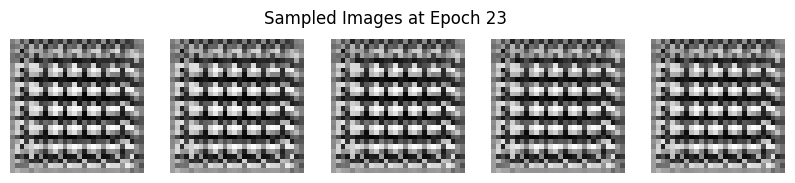

Epoch 24 | Loss_D: 0.3904 | Loss_G: 0.3677


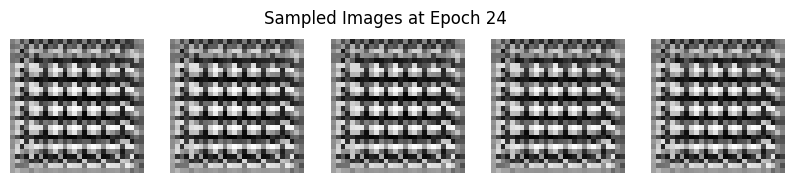

Epoch 25 | Loss_D: 0.3734 | Loss_G: 0.3961


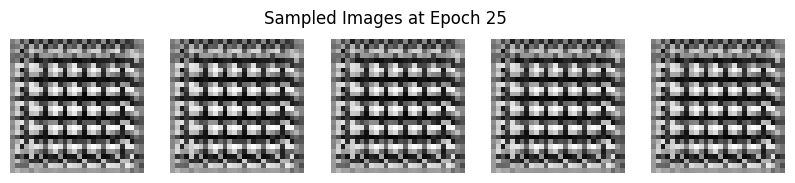

Epoch 26 | Loss_D: 0.3684 | Loss_G: 0.3681


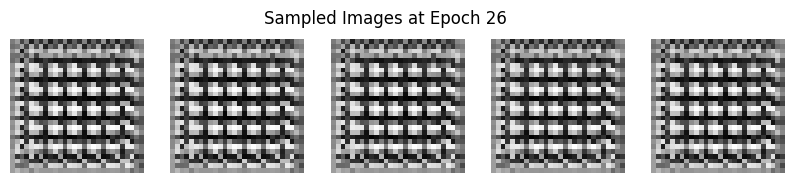

Epoch 27 | Loss_D: 0.3743 | Loss_G: 0.3592


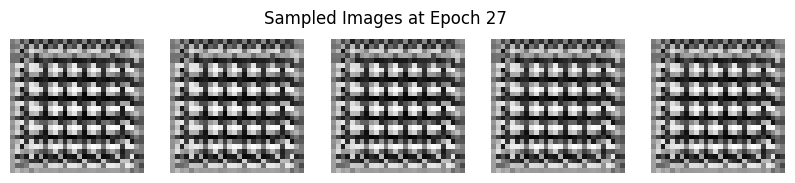

Epoch 28 | Loss_D: 0.3935 | Loss_G: 0.3780


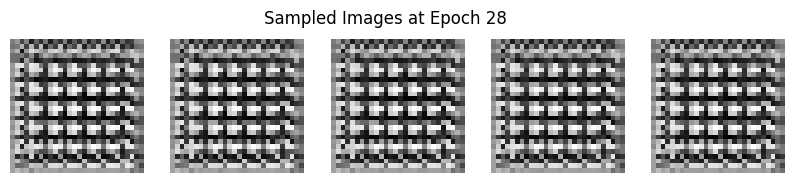

Epoch 29 | Loss_D: 0.3819 | Loss_G: 0.3831


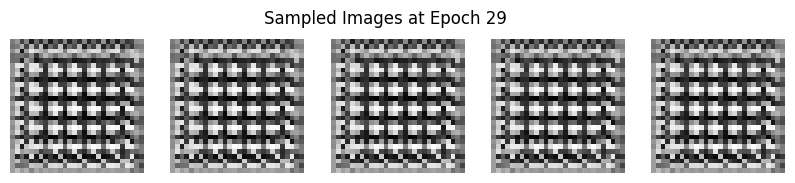

Epoch 30 | Loss_D: 0.3810 | Loss_G: 0.3986


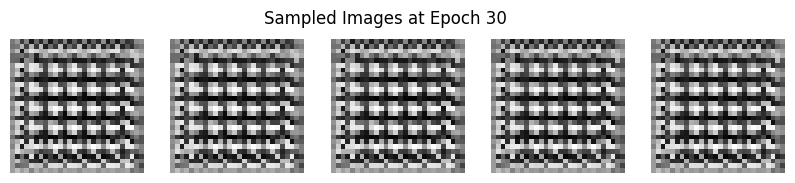

Epoch 31 | Loss_D: 0.3748 | Loss_G: 0.3745


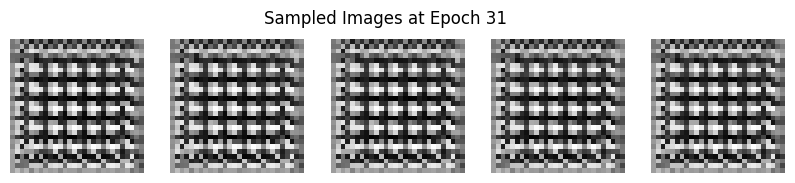

Epoch 32 | Loss_D: 0.3687 | Loss_G: 0.3790


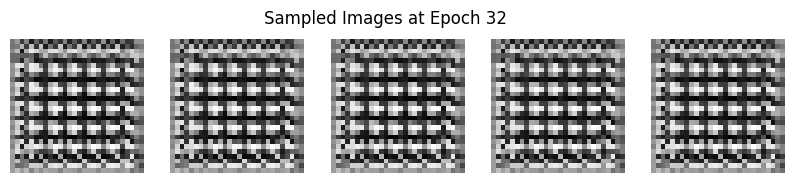

Epoch 33 | Loss_D: 0.3814 | Loss_G: 0.3674


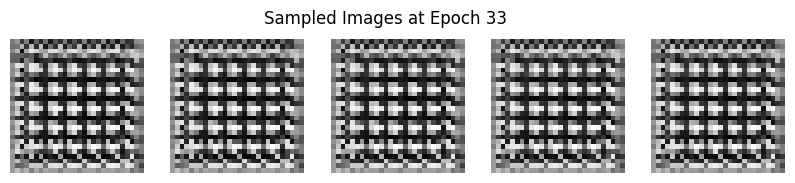

Epoch 34 | Loss_D: 0.3875 | Loss_G: 0.4117


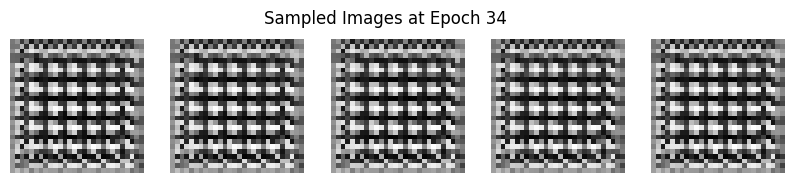

Epoch 35 | Loss_D: 0.3662 | Loss_G: 0.3784


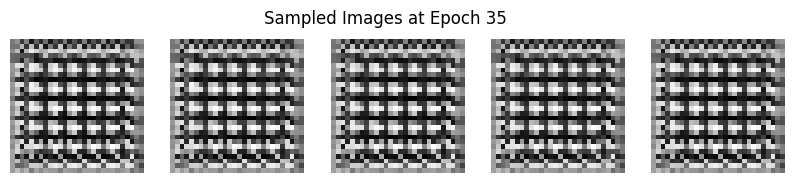

Epoch 36 | Loss_D: 0.3655 | Loss_G: 0.3758


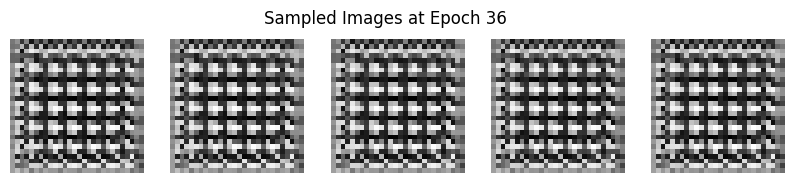

Epoch 37 | Loss_D: 0.3855 | Loss_G: 0.3930


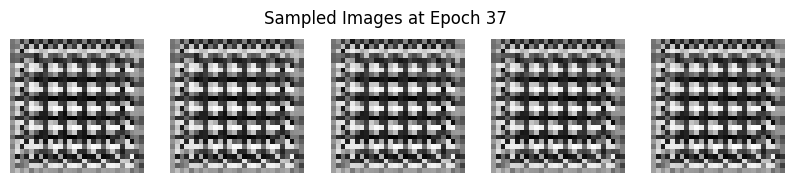

Epoch 38 | Loss_D: 0.3833 | Loss_G: 0.3697


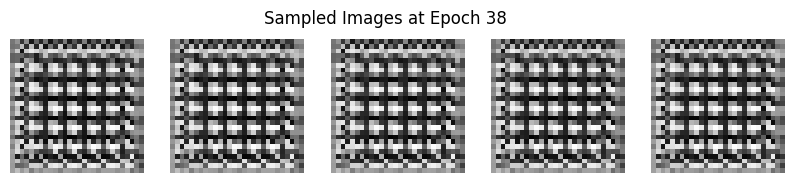

Epoch 39 | Loss_D: 0.3831 | Loss_G: 0.3866


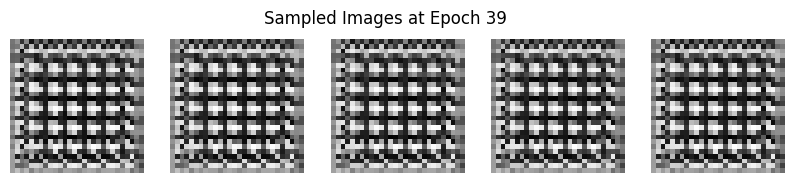

Epoch 40 | Loss_D: 0.3775 | Loss_G: 0.3743


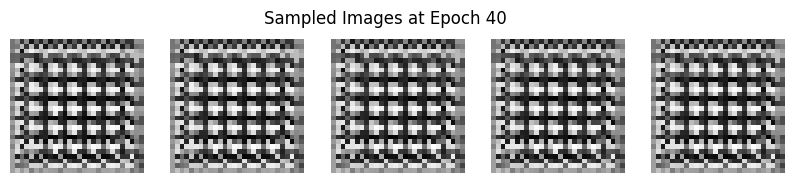

Epoch 41 | Loss_D: 0.3931 | Loss_G: 0.3831


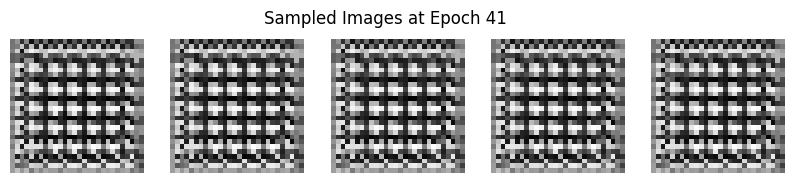

Epoch 42 | Loss_D: 0.3827 | Loss_G: 0.3968


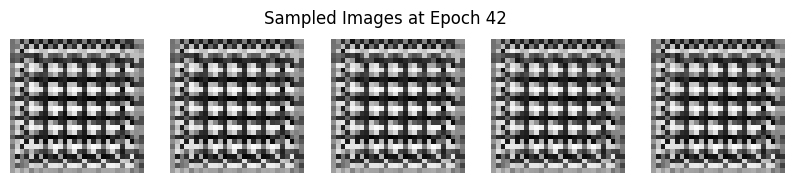

Epoch 43 | Loss_D: 0.3785 | Loss_G: 0.3954


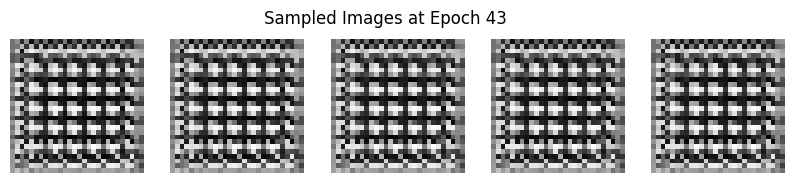

Epoch 44 | Loss_D: 0.3738 | Loss_G: 0.3746


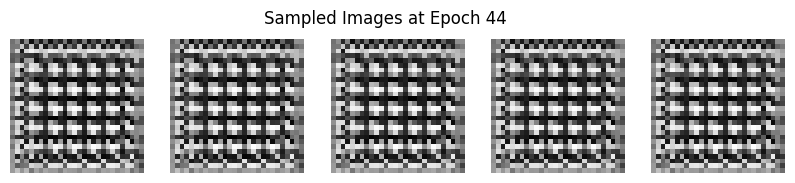

Epoch 45 | Loss_D: 0.3701 | Loss_G: 0.4092


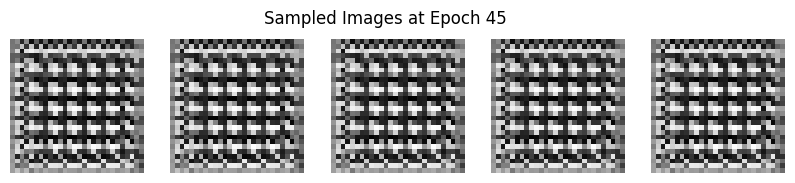

Epoch 46 | Loss_D: 0.3792 | Loss_G: 0.3839


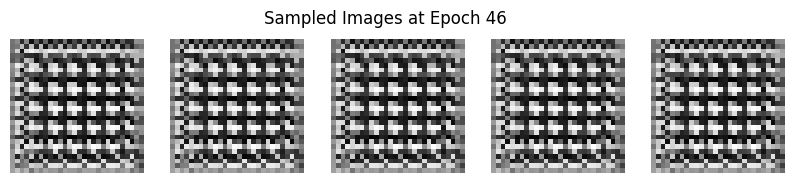

Epoch 47 | Loss_D: 0.3764 | Loss_G: 0.4005


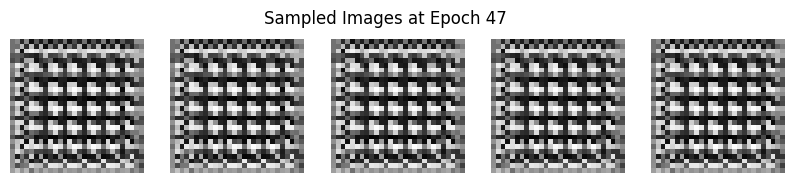

Epoch 48 | Loss_D: 0.3775 | Loss_G: 0.3448


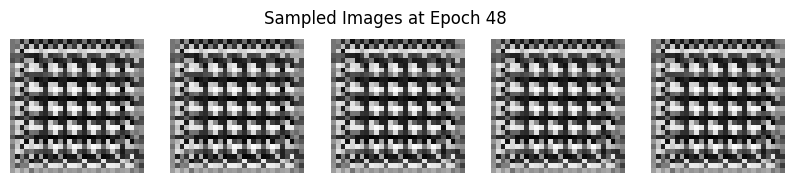

Epoch 49 | Loss_D: 0.3807 | Loss_G: 0.3733


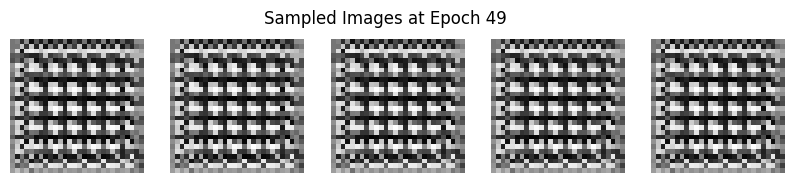

Epoch 50 | Loss_D: 0.3865 | Loss_G: 0.3810


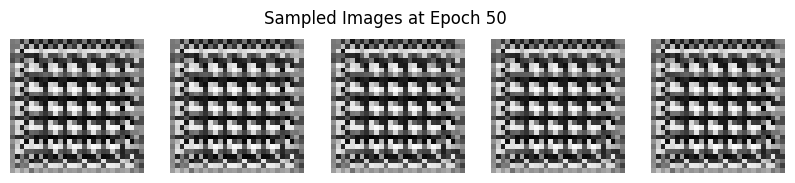

Training gan-binoculars completed!
Start training gan-rabbit
Epoch 1 | Loss_D: 0.3976 | Loss_G: 0.3784


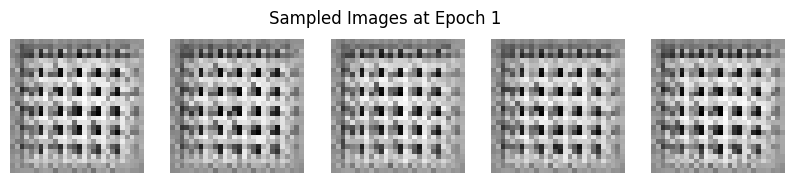

Epoch 2 | Loss_D: 0.3796 | Loss_G: 0.3618


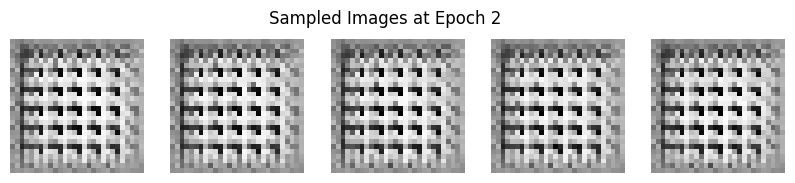

Epoch 3 | Loss_D: 0.3773 | Loss_G: 0.3902


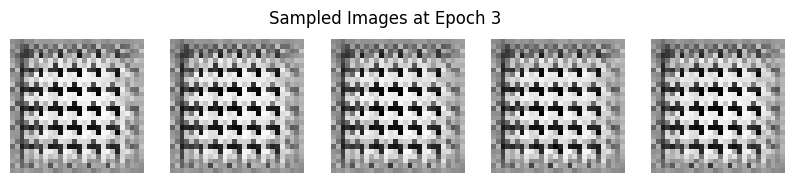

Epoch 4 | Loss_D: 0.3918 | Loss_G: 0.3710


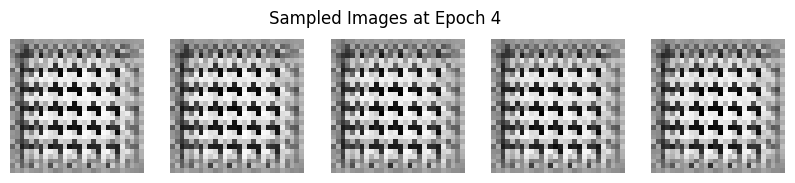

Epoch 5 | Loss_D: 0.3878 | Loss_G: 0.3885


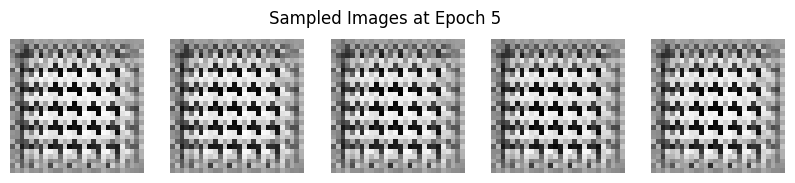

Epoch 6 | Loss_D: 0.3850 | Loss_G: 0.3724


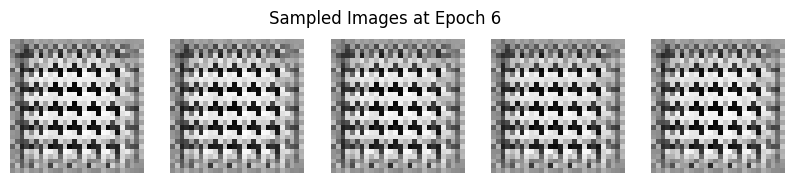

Epoch 7 | Loss_D: 0.3828 | Loss_G: 0.3888


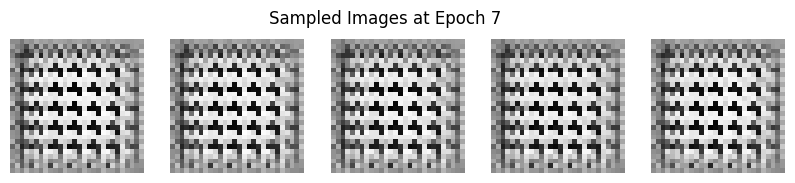

Epoch 8 | Loss_D: 0.3702 | Loss_G: 0.3839


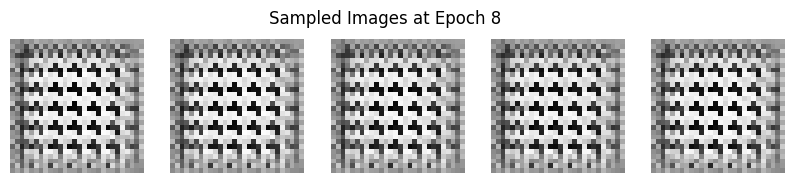

Epoch 9 | Loss_D: 0.3802 | Loss_G: 0.3710


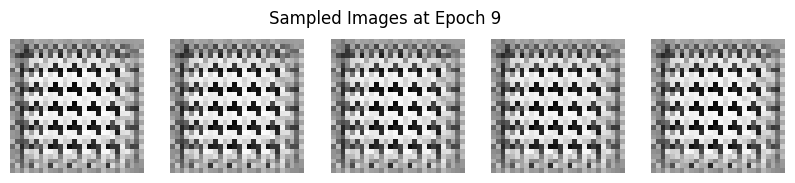

Epoch 10 | Loss_D: 0.3820 | Loss_G: 0.3861


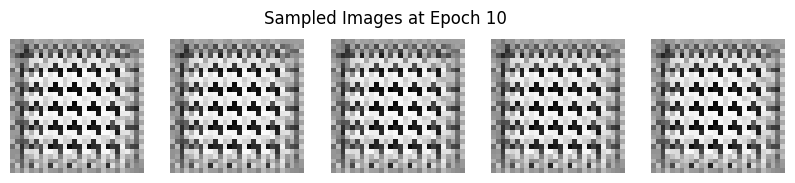

Epoch 11 | Loss_D: 0.3665 | Loss_G: 0.3637


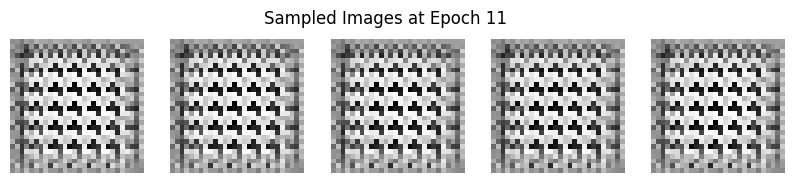

Epoch 12 | Loss_D: 0.3849 | Loss_G: 0.3717


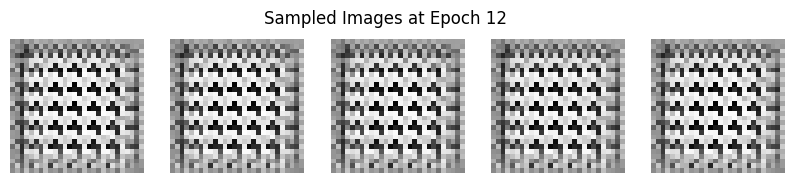

Epoch 13 | Loss_D: 0.3806 | Loss_G: 0.3603


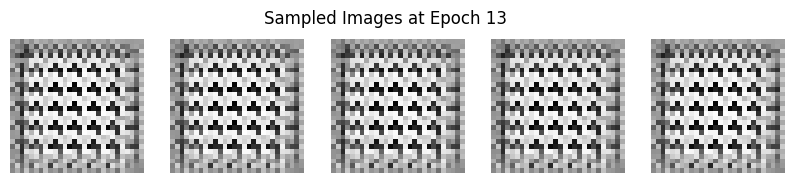

Epoch 14 | Loss_D: 0.3907 | Loss_G: 0.3726


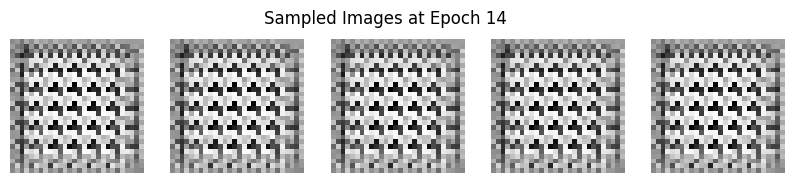

Epoch 15 | Loss_D: 0.3851 | Loss_G: 0.3806


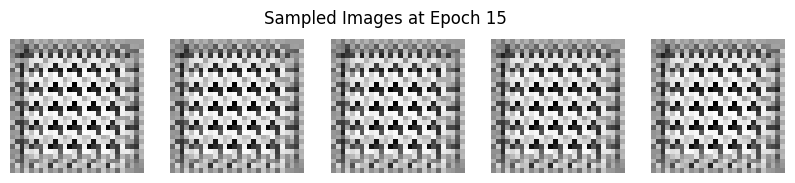

Epoch 16 | Loss_D: 0.3825 | Loss_G: 0.3750


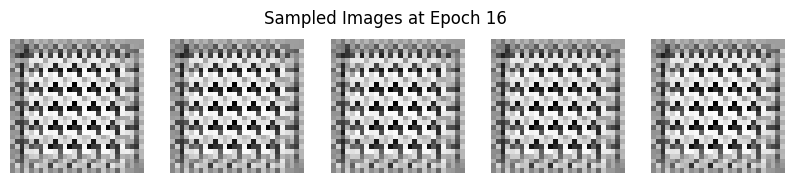

Epoch 17 | Loss_D: 0.3730 | Loss_G: 0.4120


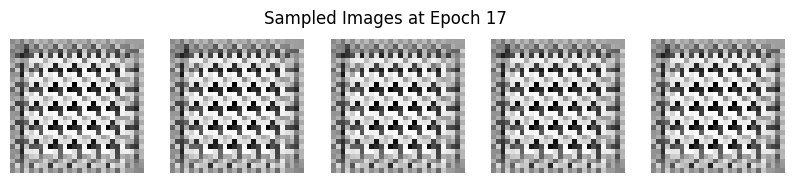

Epoch 18 | Loss_D: 0.3843 | Loss_G: 0.3758


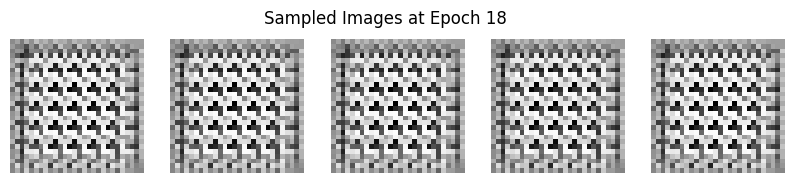

Epoch 19 | Loss_D: 0.3798 | Loss_G: 0.3893


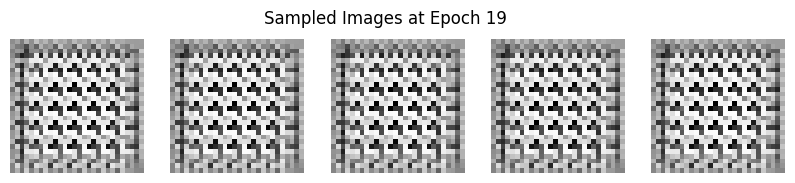

Epoch 20 | Loss_D: 0.3807 | Loss_G: 0.3935


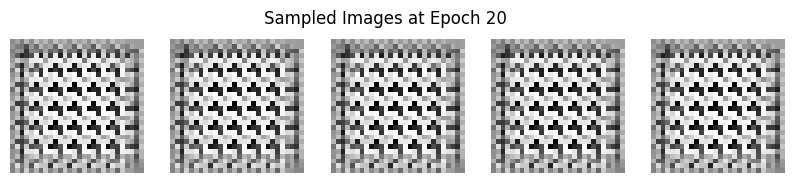

Epoch 21 | Loss_D: 0.3832 | Loss_G: 0.3761


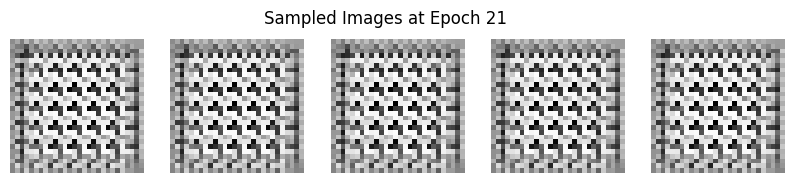

Epoch 22 | Loss_D: 0.3796 | Loss_G: 0.3567


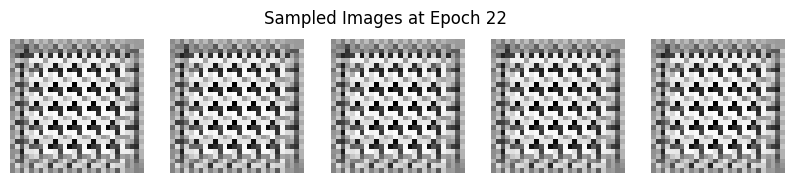

Epoch 23 | Loss_D: 0.3718 | Loss_G: 0.3716


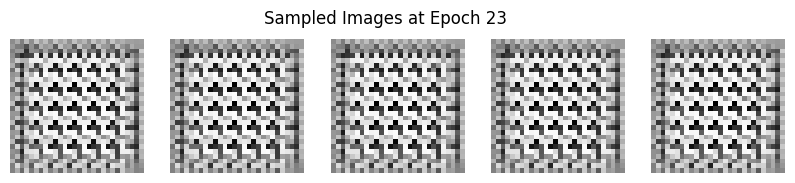

Epoch 24 | Loss_D: 0.3823 | Loss_G: 0.3633


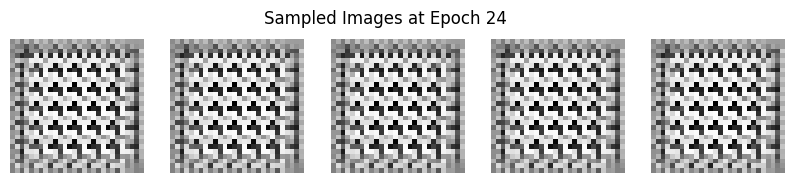

Epoch 25 | Loss_D: 0.3824 | Loss_G: 0.3789


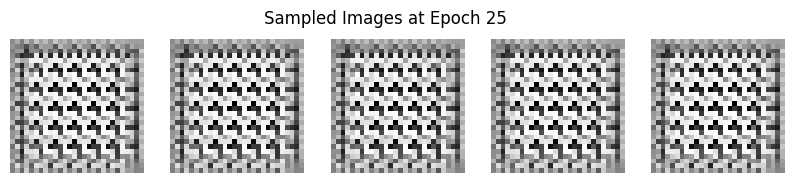

Epoch 26 | Loss_D: 0.3796 | Loss_G: 0.3714


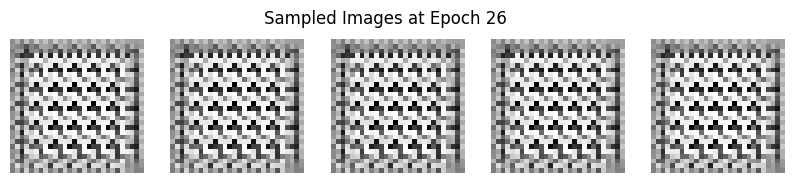

Epoch 27 | Loss_D: 0.3511 | Loss_G: 0.3525


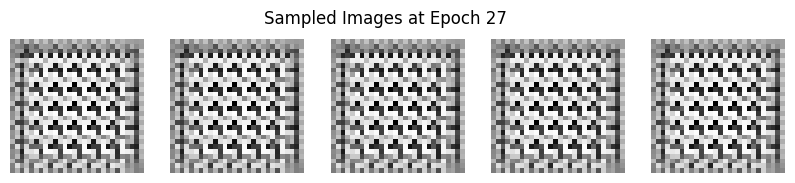

Epoch 28 | Loss_D: 0.3830 | Loss_G: 0.3703


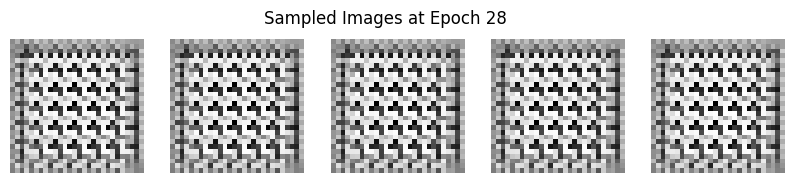

Epoch 29 | Loss_D: 0.3819 | Loss_G: 0.3897


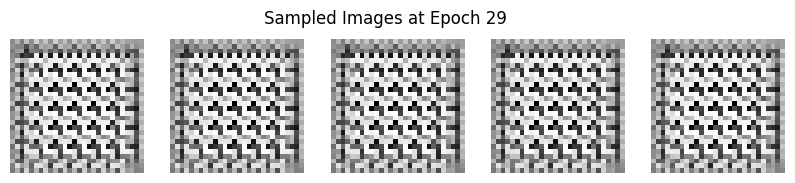

Epoch 30 | Loss_D: 0.3735 | Loss_G: 0.3446


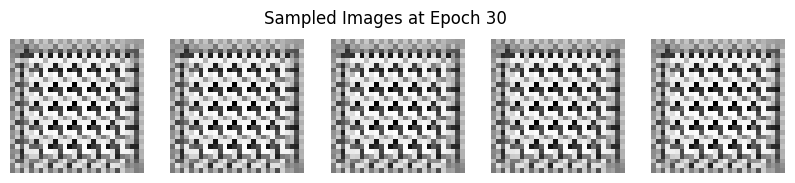

Epoch 31 | Loss_D: 0.3764 | Loss_G: 0.3667


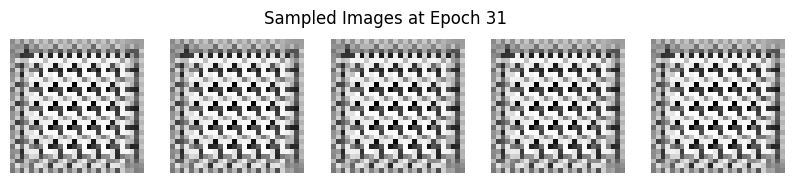

Epoch 32 | Loss_D: 0.3913 | Loss_G: 0.3792


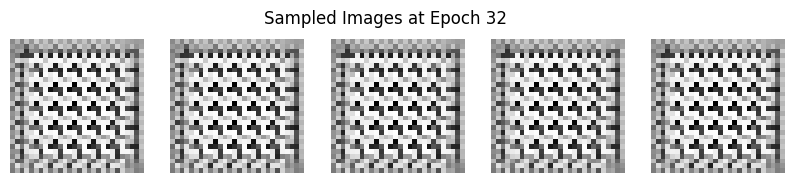

Epoch 33 | Loss_D: 0.3728 | Loss_G: 0.3758


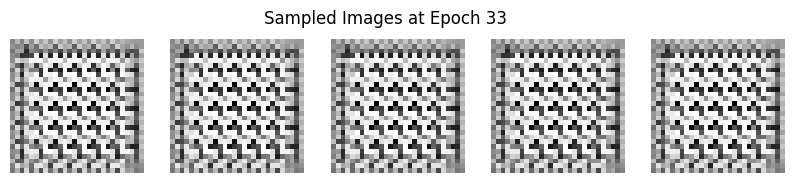

Epoch 34 | Loss_D: 0.3739 | Loss_G: 0.3670


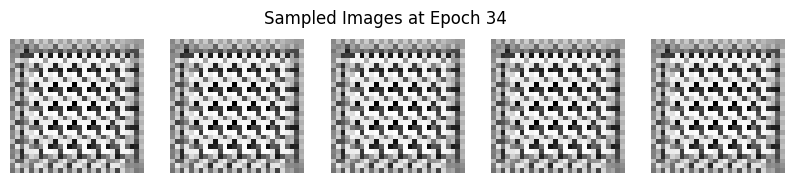

Epoch 35 | Loss_D: 0.3842 | Loss_G: 0.3723


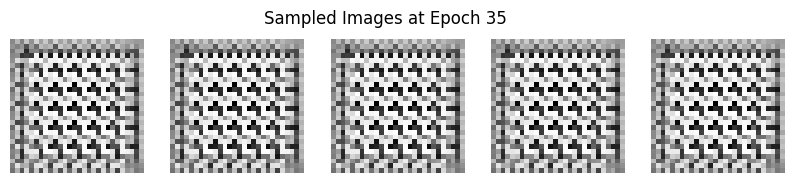

Epoch 36 | Loss_D: 0.3788 | Loss_G: 0.3703


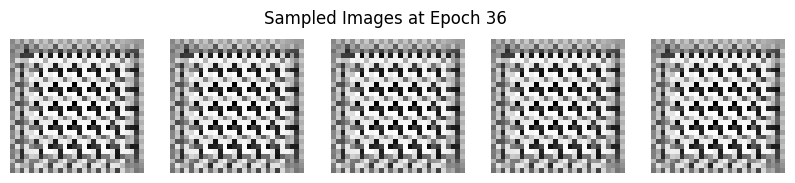

Epoch 37 | Loss_D: 0.3838 | Loss_G: 0.3631


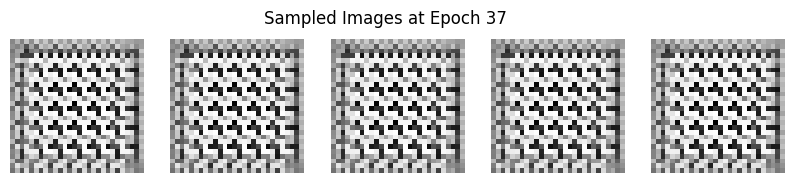

Epoch 38 | Loss_D: 0.3610 | Loss_G: 0.3724


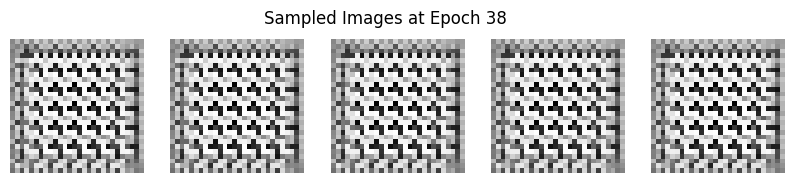

Epoch 39 | Loss_D: 0.3878 | Loss_G: 0.4014


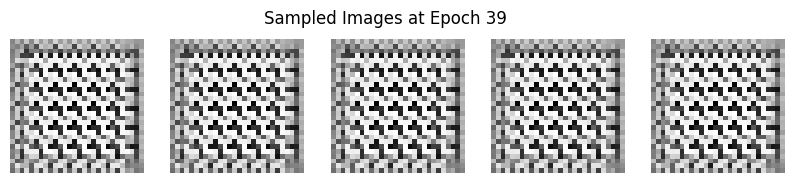

Epoch 40 | Loss_D: 0.3743 | Loss_G: 0.3751


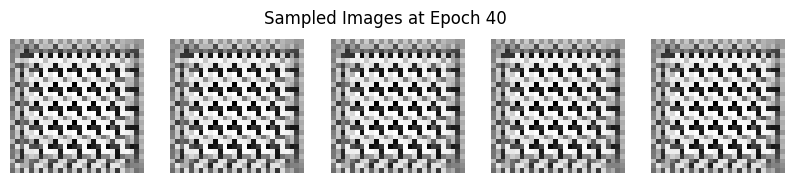

Epoch 41 | Loss_D: 0.3716 | Loss_G: 0.3899


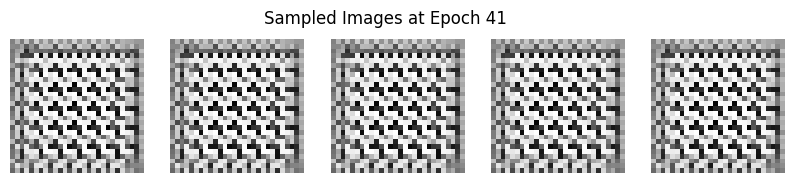

Epoch 42 | Loss_D: 0.3658 | Loss_G: 0.3690


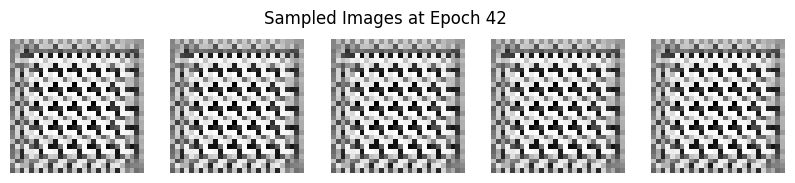

Epoch 43 | Loss_D: 0.3798 | Loss_G: 0.3591


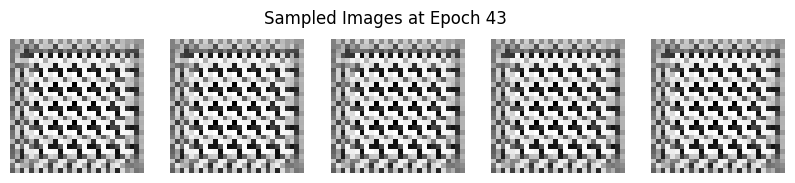

Epoch 44 | Loss_D: 0.3660 | Loss_G: 0.3815


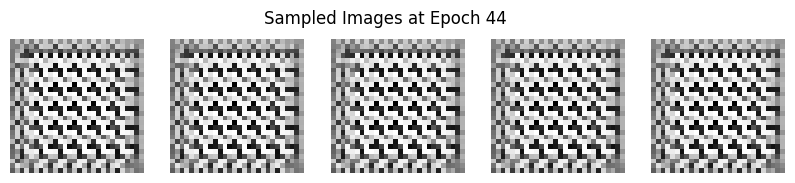

Epoch 45 | Loss_D: 0.3824 | Loss_G: 0.3807


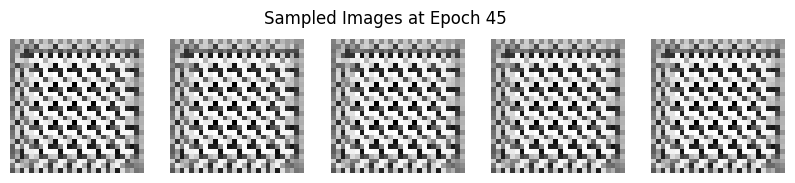

Epoch 46 | Loss_D: 0.3815 | Loss_G: 0.3786


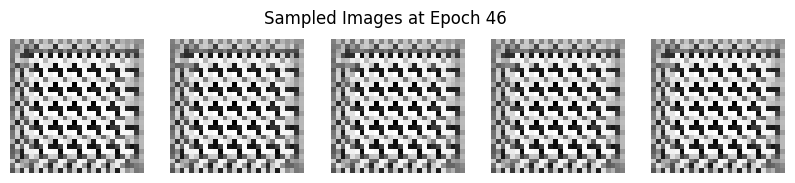

Epoch 47 | Loss_D: 0.3765 | Loss_G: 0.3662


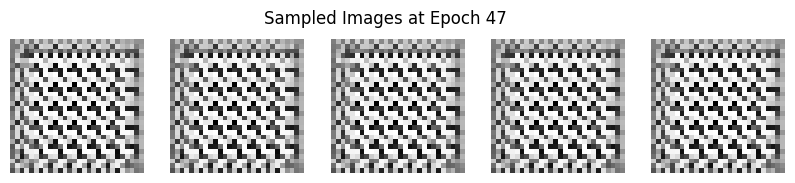

Epoch 48 | Loss_D: 0.3880 | Loss_G: 0.4000


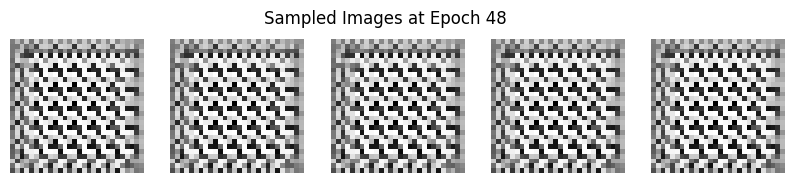

Epoch 49 | Loss_D: 0.3646 | Loss_G: 0.3892


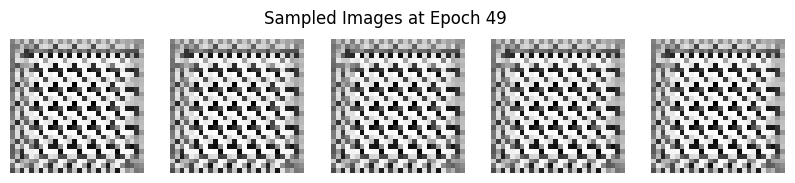

Epoch 50 | Loss_D: 0.3808 | Loss_G: 0.3636


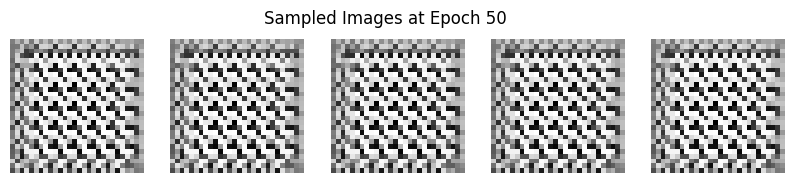

Training gan-rabbit completed!
Start training gan-hand
Epoch 1 | Loss_D: 0.3804 | Loss_G: 0.3890


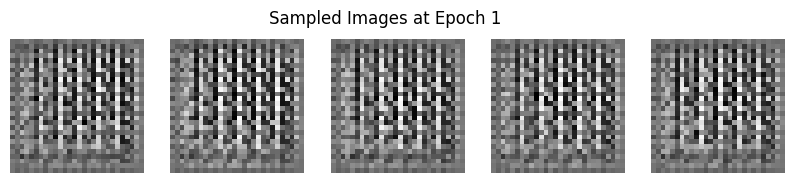

Epoch 2 | Loss_D: 0.3867 | Loss_G: 0.3700


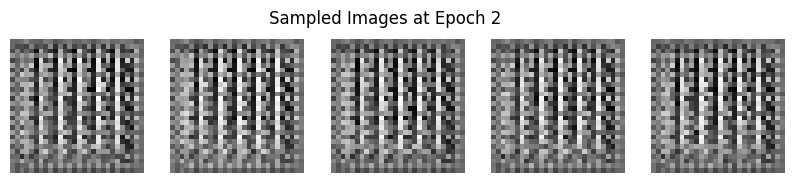

Epoch 3 | Loss_D: 0.3855 | Loss_G: 0.3523


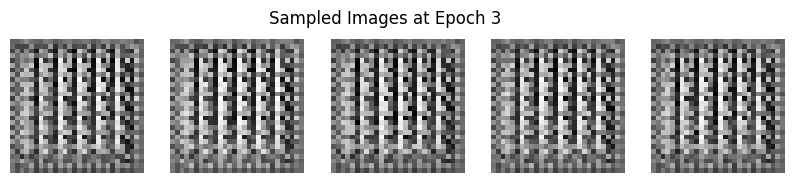

Epoch 4 | Loss_D: 0.3783 | Loss_G: 0.3577


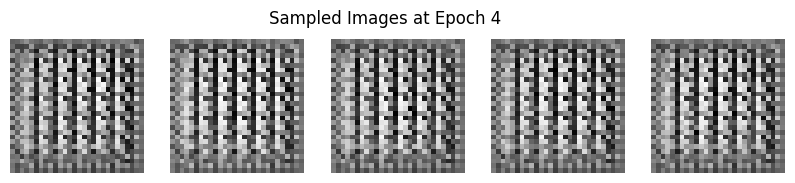

Epoch 5 | Loss_D: 0.3736 | Loss_G: 0.3773


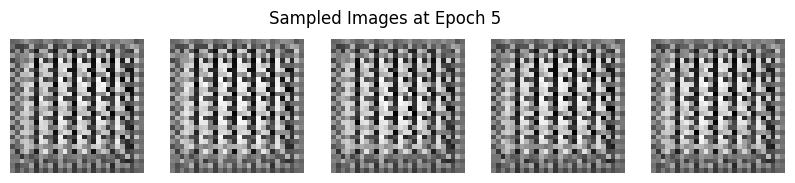

Epoch 6 | Loss_D: 0.3878 | Loss_G: 0.4188


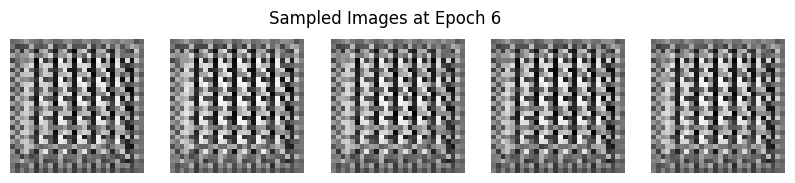

Epoch 7 | Loss_D: 0.3748 | Loss_G: 0.3926


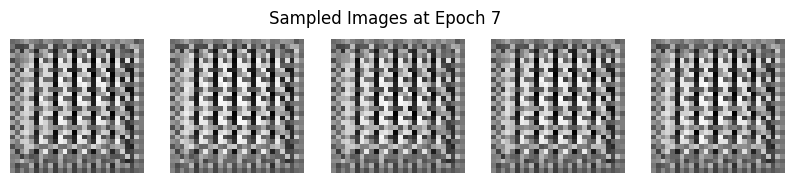

Epoch 8 | Loss_D: 0.3803 | Loss_G: 0.3584


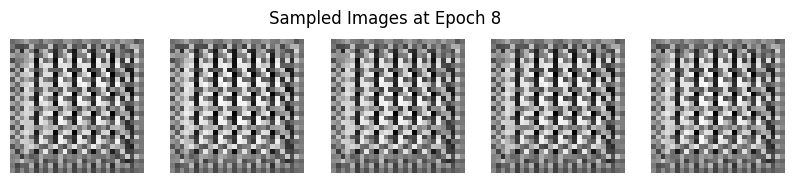

Epoch 9 | Loss_D: 0.3734 | Loss_G: 0.3866


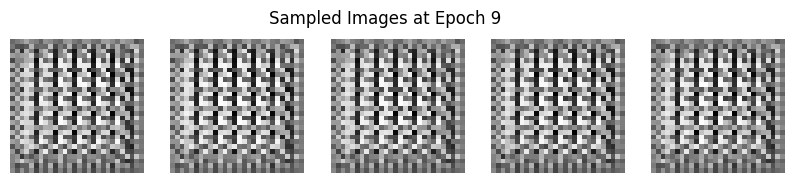

Epoch 10 | Loss_D: 0.3884 | Loss_G: 0.3785


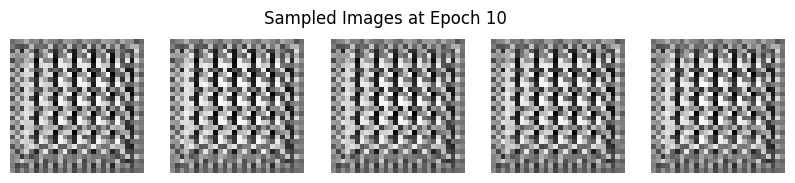

Epoch 11 | Loss_D: 0.3793 | Loss_G: 0.3803


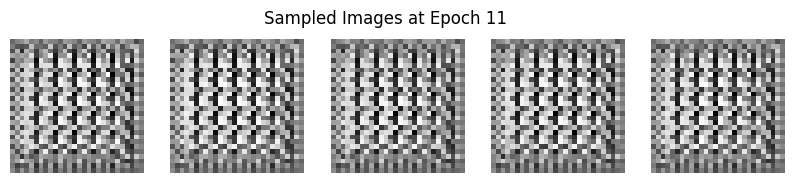

Epoch 12 | Loss_D: 0.3765 | Loss_G: 0.3734


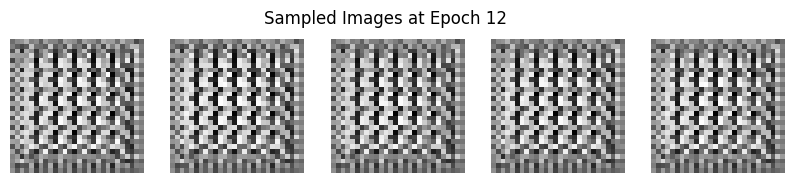

Epoch 13 | Loss_D: 0.3801 | Loss_G: 0.3866


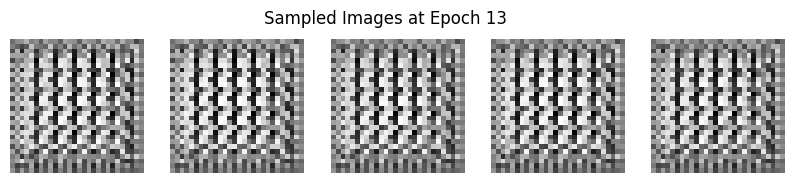

Epoch 14 | Loss_D: 0.3972 | Loss_G: 0.3841


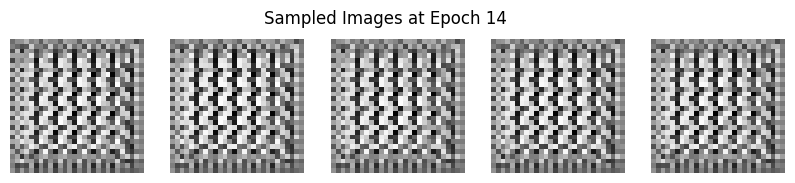

Epoch 15 | Loss_D: 0.3773 | Loss_G: 0.3838


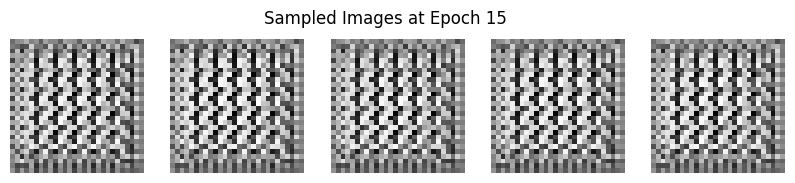

Epoch 16 | Loss_D: 0.3720 | Loss_G: 0.3635


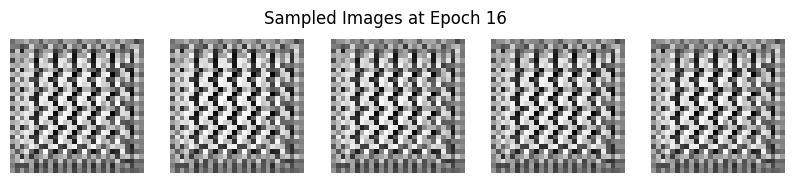

Epoch 17 | Loss_D: 0.3753 | Loss_G: 0.3829


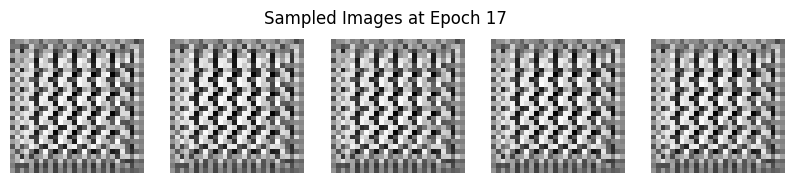

Epoch 18 | Loss_D: 0.3857 | Loss_G: 0.3782


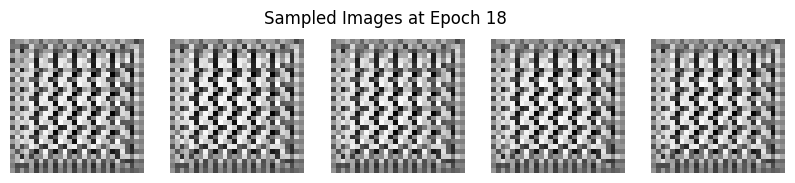

Epoch 19 | Loss_D: 0.3619 | Loss_G: 0.3808


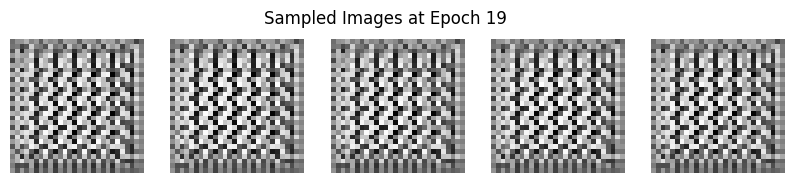

Epoch 20 | Loss_D: 0.3813 | Loss_G: 0.3782


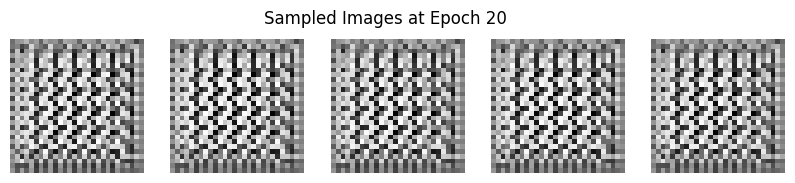

Epoch 21 | Loss_D: 0.3719 | Loss_G: 0.3683


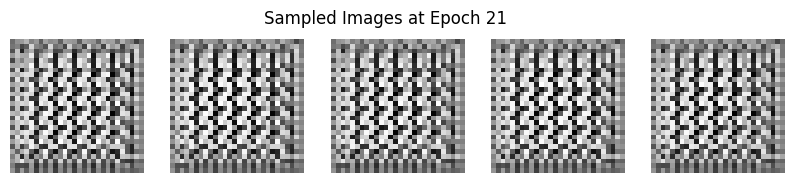

Epoch 22 | Loss_D: 0.3698 | Loss_G: 0.3814


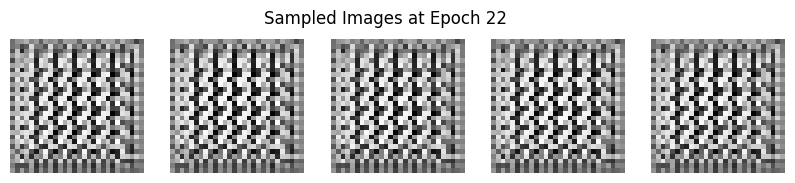

Epoch 23 | Loss_D: 0.3730 | Loss_G: 0.3781


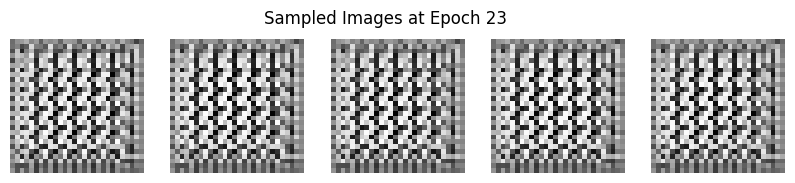

Epoch 24 | Loss_D: 0.3847 | Loss_G: 0.3652


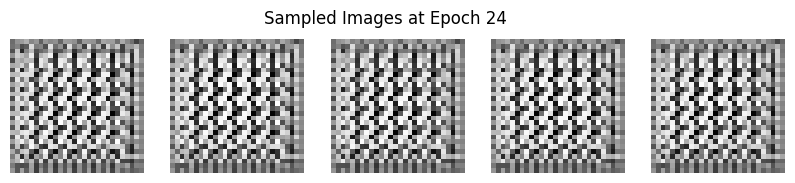

Epoch 25 | Loss_D: 0.3720 | Loss_G: 0.3869


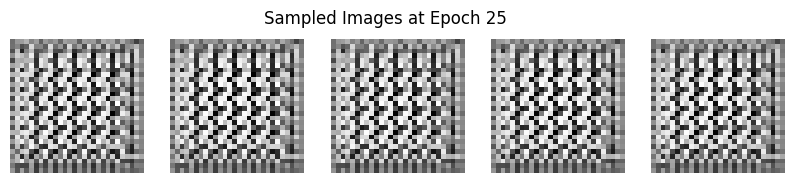

Epoch 26 | Loss_D: 0.3765 | Loss_G: 0.3695


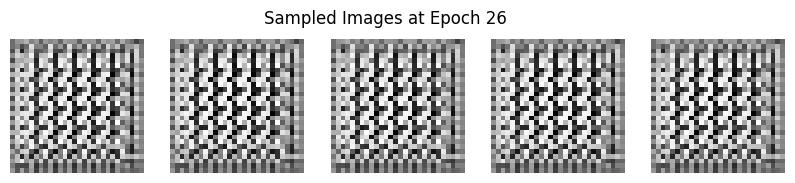

Epoch 27 | Loss_D: 0.3735 | Loss_G: 0.3559


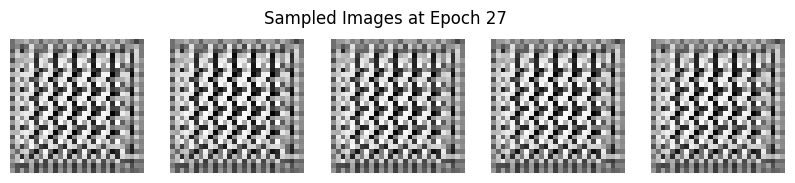

Epoch 28 | Loss_D: 0.3669 | Loss_G: 0.3926


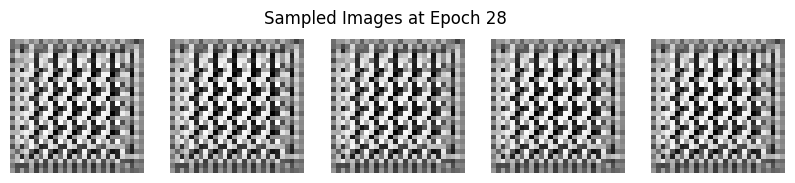

Epoch 29 | Loss_D: 0.3702 | Loss_G: 0.3710


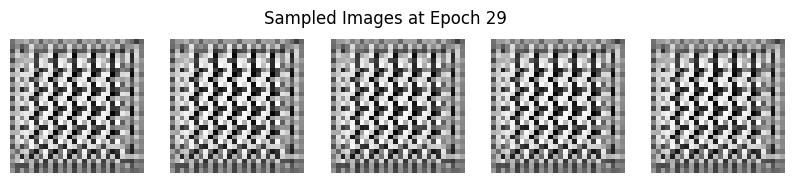

Epoch 30 | Loss_D: 0.3741 | Loss_G: 0.3717


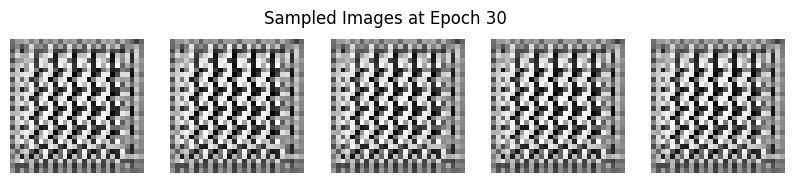

Epoch 31 | Loss_D: 0.3670 | Loss_G: 0.3821


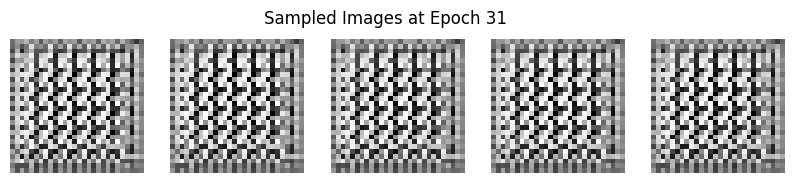

Epoch 32 | Loss_D: 0.3930 | Loss_G: 0.3798


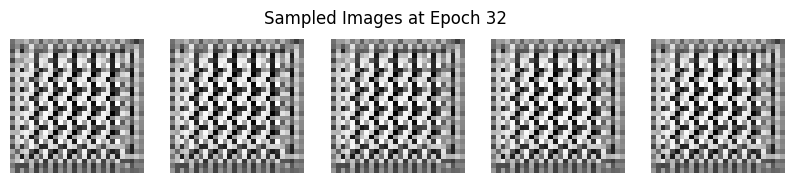

Epoch 33 | Loss_D: 0.3842 | Loss_G: 0.3728


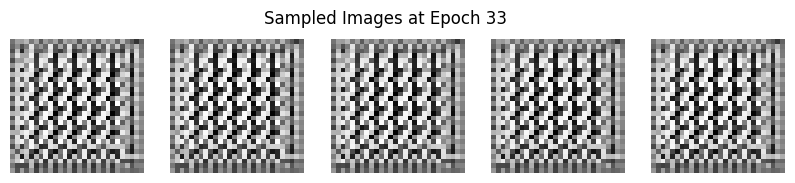

Epoch 34 | Loss_D: 0.3672 | Loss_G: 0.3961


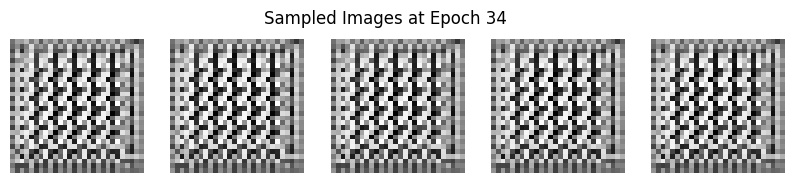

Epoch 35 | Loss_D: 0.3831 | Loss_G: 0.3722


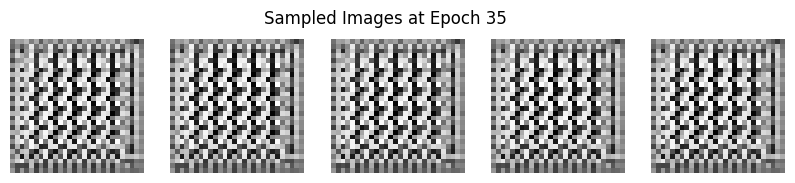

Epoch 36 | Loss_D: 0.3816 | Loss_G: 0.3993


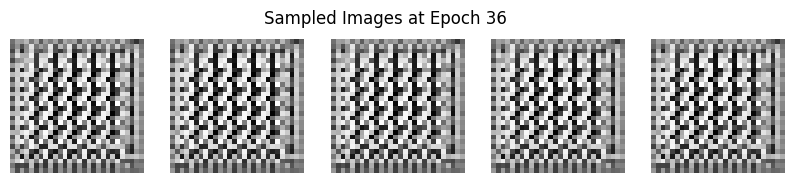

Epoch 37 | Loss_D: 0.3768 | Loss_G: 0.3694


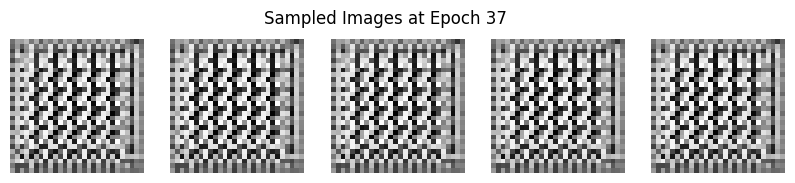

Epoch 38 | Loss_D: 0.3802 | Loss_G: 0.3868


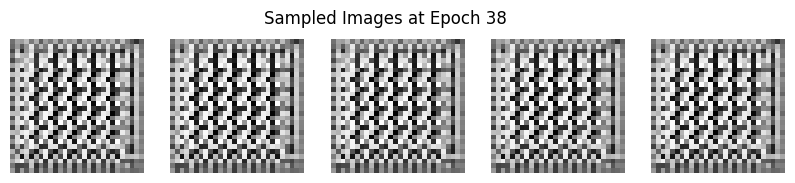

Epoch 39 | Loss_D: 0.3758 | Loss_G: 0.4014


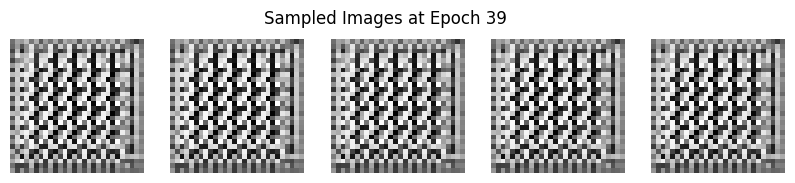

Epoch 40 | Loss_D: 0.3716 | Loss_G: 0.3726


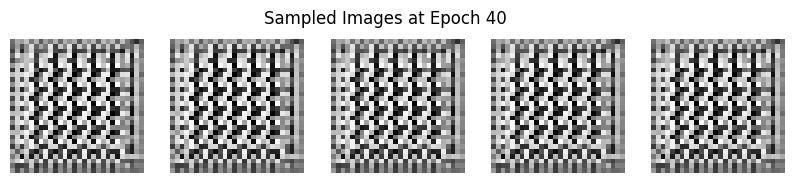

Epoch 41 | Loss_D: 0.3808 | Loss_G: 0.3694


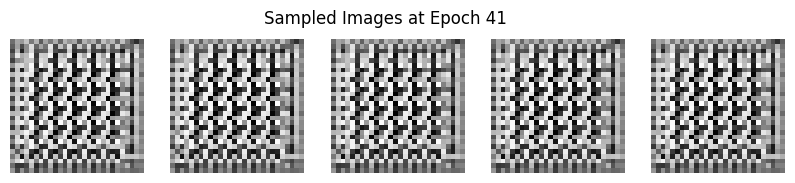

Epoch 42 | Loss_D: 0.3818 | Loss_G: 0.3651


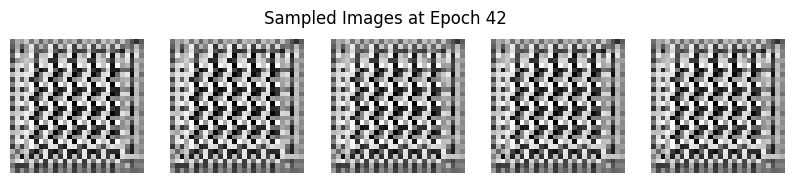

Epoch 43 | Loss_D: 0.3715 | Loss_G: 0.3952


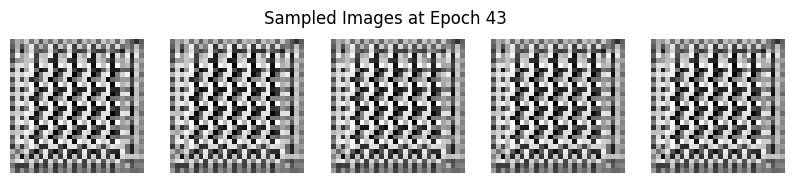

Epoch 44 | Loss_D: 0.3951 | Loss_G: 0.3588


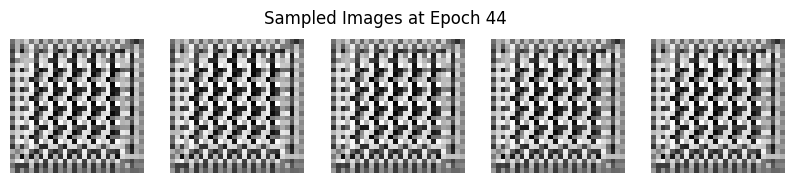

Epoch 45 | Loss_D: 0.3822 | Loss_G: 0.3780


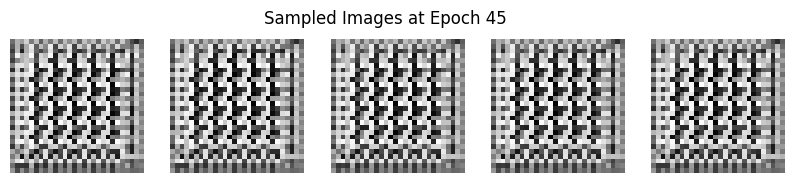

Epoch 46 | Loss_D: 0.3830 | Loss_G: 0.3894


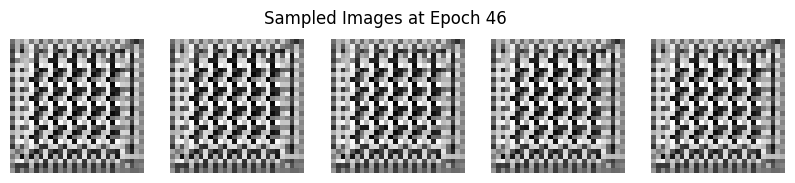

Epoch 47 | Loss_D: 0.3811 | Loss_G: 0.3752


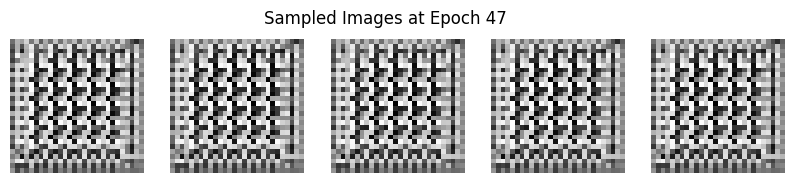

Epoch 48 | Loss_D: 0.3669 | Loss_G: 0.3734


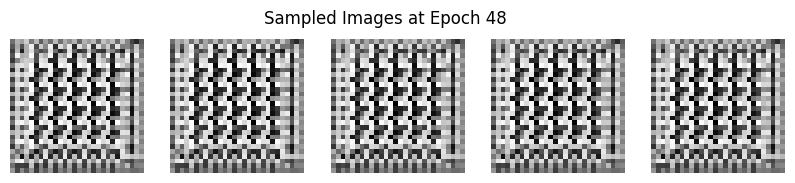

Epoch 49 | Loss_D: 0.3831 | Loss_G: 0.3839


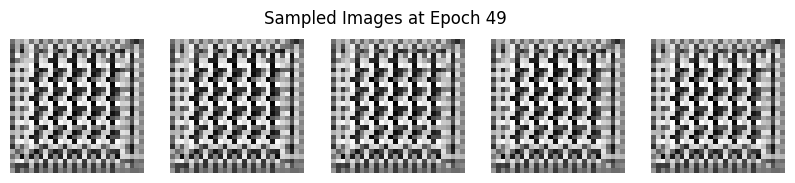

Epoch 50 | Loss_D: 0.3836 | Loss_G: 0.3726


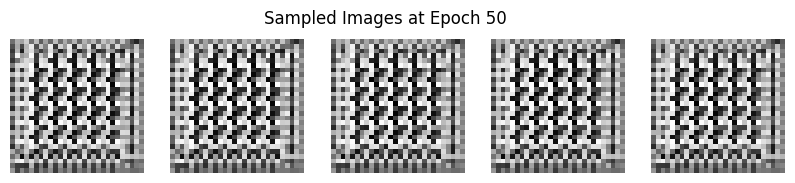

Training gan-hand completed!


In [114]:
gan_models = [(Generator(noise_dim=NOISE_DIM, base_channels=32), Discriminator(base_channels=4)) for i in range(len(classes))]
for idx, (G, D) in enumerate(gan_models):
    # Create Train Dataloader
    current_train_data = QuickDrawDataset('../dataset/train.csv', '../dataset/images', cgan_train_transforms, class_label=idx)
    current_train_loader = DataLoader(current_train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=6, pin_memory=True)

    name = f'gan-{classes[idx]}'
    train_gan_model(name, G, D, current_train_loader, f'../weights/generative/gan/{name}.pt')